# Modelling

This notebook details the implementation of a suite of nowcasting models. The primary objective is to leverage the preprocessed dataset from `data-preprocessing-nowcasting-thai-gdp.ipynb` to generate competing nowcasts for Thailand's 2019Q4 GDP. Following the development of these models, their performance is assessed in terms of both predictive accuracy and their respective capacities for economic interpretation. Finally, all relevant results are systematically exported to facilitate a final comparative evaluation. A full theoretical and practical account of the modelling procedures employed is provided in the methodology chapter of the accompanying thesis.

In [1]:
# Import libraries for feature scaling
# and prepare training and testing sets for modeling
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
# === LOAD DATA ===

# Quarterly inputs
df_prep_q = pd.read_csv('./preprocessed-dataset-nowcasting-thai-gdp-quarterly-dec.csv')

# Monthly inputs
df_prep_m = pd.read_csv('./preprocessed-dataset-nowcasting-thai-gdp-monthly-dec.csv')

# Target variable
df_gdp = pd.read_csv('./thai-gdp-quarterly-2011Q1-2019Q4.csv')

In [3]:
# === SPLIT DATA ===

# Quarterly inputs
Xq_train = df_prep_q[df_prep_q['quarter'] < '2019Q3'].copy()
Xq_val = df_prep_q[df_prep_q['quarter'] == '2019Q3'].copy()
Xq_train_full = df_prep_q[df_prep_q['quarter'] < '2019Q4'].copy()
Xq_test = df_prep_q[df_prep_q['quarter'] == '2019Q4'].copy()

# Monthly inputs
Xm_train_full = df_prep_m[df_prep_m['date'] < '2019-10-31'].copy()
Xm_test = df_prep_m[df_prep_m['date'] >= '2019-10-31'].copy()
Xm_train = Xm_train_full[Xm_train_full['date'] < '2019-07-31'].copy()
Xm_val = Xm_train_full[Xm_train_full['date'] >= '2019-07-31'].copy()

# GDP targets
y_train_full = df_gdp[df_gdp['quarter'] < '2019Q4'].copy()
y_train = y_train_full[y_train_full['quarter'] < '2019Q3'].copy()
y_val = y_train_full[y_train_full['quarter'] == '2019Q3'].copy()
y_test = df_gdp[df_gdp['quarter'] == '2019Q4'].copy()

In [4]:
# === PIVOT TO WIDE FORMAT ===

# Quarterly
Xq_train_wide = Xq_train.pivot(index='quarter', columns='series_name', values='value')
Xq_val_wide = Xq_val.pivot(index='quarter', columns='series_name', values='value')
Xq_train_full_wide = Xq_train_full.pivot(index='quarter', columns='series_name', values='value')
Xq_test_wide = Xq_test.pivot(index='quarter', columns='series_name', values='value')

# Monthly
Xm_train_wide = Xm_train.pivot(index='date', columns='series_name', values='value')
Xm_val_wide = Xm_val.pivot(index='date', columns='series_name', values='value')
Xm_train_full_wide = Xm_train_full.pivot(index='date', columns='series_name', values='value')
Xm_test_wide = Xm_test.pivot(index='date', columns='series_name', values='value')

In [5]:
# === STANDARDIZATION ===

# Quarterly: based on Xq_train
means_q = Xq_train_wide.mean()
stds_q = Xq_train_wide.std()

Xq_train_std = (Xq_train_wide - means_q) / stds_q
Xq_val_std = (Xq_val_wide - means_q) / stds_q
Xq_train_full_std = (Xq_train_full_wide - means_q) / stds_q
Xq_test_std = (Xq_test_wide - means_q) / stds_q

# Monthly: based on Xm_train
means_m = Xm_train_wide.mean()
stds_m = Xm_train_wide.std()

Xm_train_std = (Xm_train_wide - means_m) / stds_m
Xm_val_std = (Xm_val_wide - means_m) / stds_m
Xm_train_full_std = (Xm_train_full_wide - means_m) / stds_m
Xm_test_std = (Xm_test_wide - means_m) / stds_m

In [6]:
# === MIN-MAX SCALING ===

# Fit MinMaxScaler on train subsets only
scaler_Xq = MinMaxScaler()
scaler_Xq.fit(Xq_train_wide)

Xq_train_minmax = scaler_Xq.transform(Xq_train_wide)
Xq_val_minmax = scaler_Xq.transform(Xq_val_wide)
Xq_train_full_minmax = scaler_Xq.transform(Xq_train_full_wide)
Xq_test_minmax = scaler_Xq.transform(Xq_test_wide)

scaler_Xm = MinMaxScaler()
scaler_Xm.fit(Xm_train_wide)

Xm_train_minmax = scaler_Xm.transform(Xm_train_wide)
Xm_val_minmax = scaler_Xm.transform(Xm_val_wide)
Xm_train_full_minmax = scaler_Xm.transform(Xm_train_full_wide)
Xm_test_minmax = scaler_Xm.transform(Xm_test_wide)

# Fit MinMaxScaler on target (GDP growth)
scaler_y = MinMaxScaler()
scaler_y.fit(y_train['gdp_growth'].values.reshape(-1, 1))

y_train_minmax = scaler_y.transform(y_train['gdp_growth'].values.reshape(-1, 1)).flatten()
y_val_minmax = scaler_y.transform(y_val['gdp_growth'].values.reshape(-1, 1)).flatten()
y_train_full_minmax = scaler_y.transform(y_train_full['gdp_growth'].values.reshape(-1, 1)).flatten()
y_test_minmax = scaler_y.transform(y_test['gdp_growth'].values.reshape(-1, 1)).flatten()

## Econometric Models

### AR(1)

#### Accuracy

In [7]:
# Import required libraries
import statsmodels.api as sm

In [8]:
# === AR(p)  ===

class ARRegressor:
    """
    Flexible Autoregressive (AR(p)) model using OLS regression.

    This class implements a univariate AR(p) model following the standard 
    Ordinary Least Squares (OLS) estimation approach, as outlined in Tsay (2010).

    Parameters
    ----------
    p : int, optional
        Number of lags to include in the autoregressive model. Default is 1.

    Attributes
    ----------
    model_ : statsmodels.regression.linear_model.RegressionResultsWrapper or None
        Fitted OLS model after calling `fit()`. None until the model is fitted.
    fitted_values_ : pd.Series or None
        In-sample fitted values produced by the model. None until fitted.
    last_values_ : list of float or None
        Last `p` observed values of the series used for out-of-sample forecasting.
    """

    def __init__(self, p: int = 1):
        self.p = p
        self.model_ = None
        self.fitted_values_ = None
        self.last_values_ = None

    def fit(self, y: pd.Series):
        """
        Fits the AR(p) model to a univariate time series.

        The method constructs lagged features from the input series and estimates
        the model parameters using OLS regression.

        Parameters
        ----------
        y : pd.Series
            Target time series, typically a stationary sequence such as GDP growth.
            The index should represent time (e.g., datetime or PeriodIndex).

        Returns
        -------
        ARRegressor
            Self, with fitted model and stored state.
        """
        df = pd.DataFrame({'y': y})

        # Create lag features: y(t-1), y(t-2), ..., y(t-p)
        for lag in range(1, self.p + 1):
            df[f'y_lag{lag}'] = y.shift(lag)

        # Drop rows with NaNs introduced by lagging
        df = df.dropna()

        # Define predictors and response
        X = sm.add_constant(df[[f'y_lag{lag}' for lag in range(1, self.p + 1)]])
        y_clean = df['y']

        # Fit OLS regression
        self.model_ = sm.OLS(y_clean, X).fit()
        self.fitted_values_ = pd.Series(self.model_.fittedvalues, index=y_clean.index)

        # Store the last p values for forecasting
        self.last_values_ = list(y.iloc[-self.p:])

        return self

    def predict(self):
        """
        Performs a one-step-ahead forecast using the fitted AR(p) model.

        The forecast is computed as a linear combination of the most recent
        `p` observations and the estimated coefficients.

        Returns
        -------
        float
            Forecasted value for the next time step.

        Raises
        ------
        ValueError
            If the model has not been fitted before calling `predict()`.
        """
        if self.model_ is None or self.last_values_ is None:
            raise ValueError("Model not yet fitted.")

        # Extract model coefficients
        coef = self.model_.params
        const = coef.get('const', 0)

        # Get the latest p values in reverse lag order
        reg_input = [self.last_values_[-lag] for lag in range(1, self.p + 1)]

        # Forecast = const + sum(beta_i * y(t-i))
        forecast = const + np.dot(coef.values[1:], reg_input)

        return forecast

In [9]:
# Fit AR(1) model on full training data (up to 2019Q3)
ar1_model = ARRegressor(p=1)
ar1_model.fit(y_train_full['gdp_growth'])

# Nowcast for 2019Q4 (one-step-ahead forecast)
nowcast_value_ar1 = ar1_model.predict()
nowcast_ar1 = pd.Series([nowcast_value_ar1], index=[pd.Period('2019Q4', freq='Q')], name='nowcast')
print(f"AR(1) nowcast for 2019Q4: {nowcast_ar1.iloc[0]:.4f}")

AR(1) nowcast for 2019Q4: 2.9801


In [10]:
# Import plotting libraries
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [11]:
# Define a reusable helper function to plot actual values
# model-fitted values and nowcast forecasts
def plot_nowcast(actual_dates, actual_values, 
                 fitted_dates, fitted_values, 
                 nowcast_date, nowcast_value, 
                 title, fitted_label="Fitted", 
                 source='Source: Stefano Grassi calculation'):
    """
    Plot actual GDP growth, fitted values from a model, and a nowcast point.

    Parameters
    ----------
    actual_dates : pd.Series or list
        Dates for actual GDP growth.
    actual_values : pd.Series or list
        Actual GDP growth values.
    fitted_dates : pd.Series or list
        Dates corresponding to model's fitted predictions.
    fitted_values : pd.Series or list
        Fitted GDP values from the model.
    nowcast_date : str or pd.Timestamp
        Date of the nowcast (e.g., '2019Q4').
    nowcast_value : float
        Nowcasted GDP growth rate.
    title : str
        Title for the plot.
    fitted_label : str
        Label to show in the legend for fitted values.
    source : str, optional
        Text to display as the source.
    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(10, 5))

    # Actual GDP growth
    ax.plot(actual_dates, actual_values, label='Actual GDP Growth',
            color='black', marker='o', ms=4, linewidth=1)

    # Fitted model values
    ax.plot(fitted_dates, fitted_values, label=fitted_label,
            linestyle='--', color='royalblue', linewidth=2.5, marker='x')

    # Nowcast point
    ax.scatter([nowcast_date], [nowcast_value], color='firebrick',
               label='Nowcast', s=100, zorder=10, marker='*')

    # Titles and axes
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_ylabel("GDP Growth Rate (%)", fontsize=12)
    ax.set_xlabel("Quarter", fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.4)

    # Legend
    ax.legend(frameon=False, fontsize=10, loc='upper left')

    # Source
    plt.text(0.1, -0.50, source, ha='center', va='center',
             fontsize=10, color='black', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

In [12]:
# Get AR(1) fitted
ar1_model_fitted_dates = ar1_model.fitted_values_.index
ar1_model_fitted_values = ar1_model.fitted_values_.values

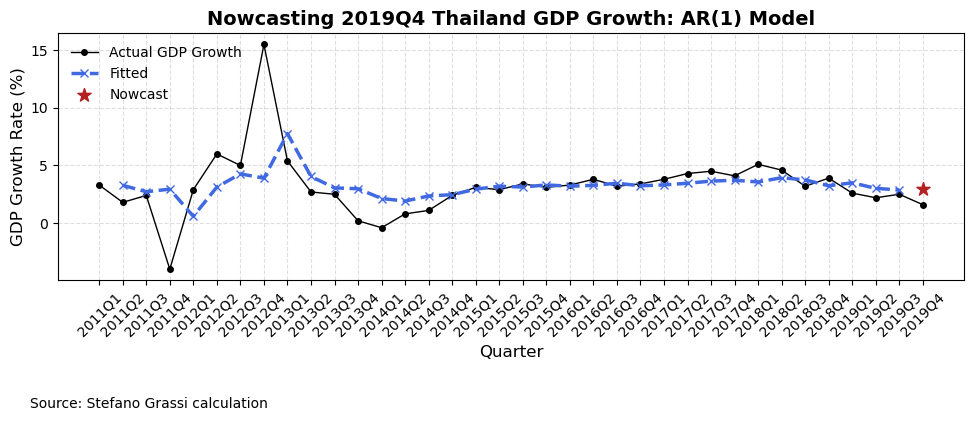

In [13]:
# Plot AR(1) Nowcast
plot_nowcast(
    actual_dates=df_gdp['quarter'],
    actual_values=df_gdp['gdp_growth'],
    fitted_dates=ar1_model_fitted_dates,
    fitted_values=ar1_model_fitted_values,
    nowcast_date=y_test['quarter'].iloc[0],
    nowcast_value=nowcast_ar1.iloc[0],
    title="Nowcasting 2019Q4 Thailand GDP Growth: AR(1) Model",
    fitted_label="Fitted",
    source="Source: Stefano Grassi calculation"
)

## DFM

#### Accuracy

In [14]:
# Import PCA and linear Regression methods from sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [15]:
# === DFM  ===

class DFM:
    """
    Dynamic Factor Model (DFM) using PCA for dimensionality reduction and linear regression for prediction.

    This implementation follows the approach of Stock and Watson (2002), which:
    
    - Extracts common factors from a large set of standardized indicators using PCA.
    - Uses lagged factors and lagged target variables in a dynamic regression to forecast one step ahead.
    - Applies a two-step estimation process: factor extraction followed by regression.

    Parameters
    ----------
    n_factors : int
        Number of principal components (latent factors) to retain.
    n_lags : int
        Number of lags to include in the regression design matrix.

    Attributes
    ----------
    pca : PCA
        PCA transformer for dimensionality reduction.
    reg : LinearRegression
        Linear regression model for forecasting.
    n_lags : int
        Number of lagged observations used.
    F_ : np.ndarray
        PCA-transformed factor scores.
    X_reg_ : np.ndarray
        Lagged feature matrix constructed for regression.
    y_reg_ : np.ndarray
        Target vector aligned with lagged features.
    y_train_ : pd.Series
        Original target series used for training.
    fitted_ : bool
        Indicator whether the model is fitted.
    fittedvalues : pd.Series
        Fitted values from regression, aligned with training dates.
    dates_ : pd.DatetimeIndex
        Index corresponding to fitted values.
    """

    def __init__(self, n_factors, n_lags):
        self.pca = PCA(n_components=n_factors)
        self.reg = LinearRegression()
        self.n_lags = n_lags
        self.fitted_ = False
        self.fittedvalues = None
        self.dates_ = None

    def _create_lagged_data(self, X, y):
        """
        Construct lagged predictor matrix and aligned target vector for regression.

        Parameters
        ----------
        X : np.ndarray
            PCA-transformed feature matrix (time x factors).
        y : pd.Series
            Original target variable indexed by time.

        Returns
        -------
        X_reg : np.ndarray
            2D array with concatenated lagged factors and lagged target values.
        y_reg : np.ndarray
            Array of target values shifted ahead by one period.
        """
        X_lagged, y_target = [], []
        for t in range(self.n_lags, len(y) - 1):
            # Extract lagged factors and target values, reversed for consistency
            ft_lags = X[t - self.n_lags + 1:t + 1].flatten()[::-1]
            y_lags = y.iloc[t - self.n_lags + 1:t + 1].values[::-1]
            X_row = np.concatenate([ft_lags, y_lags])
            X_lagged.append(X_row)
            y_target.append(y.iloc[t + 1])
        return np.array(X_lagged), np.array(y_target)

    def fit(self, X_train, y_train):
        """
        Fit the DFM to training data.

        Parameters
        ----------
        X_train : pd.DataFrame
            Input features (quarterly indicators), shape (n_samples, n_features).
        y_train : pd.Series
            Target variable (e.g., GDP growth), indexed by dates.

        Returns
        -------
        self : DFM
            Fitted DFM model instance.
        """
        self.y_train_ = y_train
        self.F_ = self.pca.fit_transform(X_train)
        self.X_reg_, self.y_reg_ = self._create_lagged_data(self.F_, y_train)
        self.reg.fit(self.X_reg_, self.y_reg_)
        self.fitted_ = True

        fitted_vals = self.reg.predict(self.X_reg_)
        # Align fitted values to match the time index (accounting for lag structure)
        self.fitted_values_ = pd.Series(fitted_vals, index=y_train.index[self.n_lags + 1:])

        return self

    def predict(self, X_test):
        """
        Predict the next period's target variable using new feature data.

        Parameters
        ----------
        X_test : pd.DataFrame
            Feature data for the prediction period, matching training format.

        Returns
        -------
        np.ndarray
            Predicted target value(s), shape (1,).

        Raises
        ------
        ValueError
            If the model is used before fitting.

        Notes
        -----
        The prediction uses lagged factors from training and the current period,
        concatenated with lagged target values, replicating training design matrix.
        """
        if not self.fitted_:
            raise ValueError("Model must be fitted before prediction.")

        # Transform current period features to factor space
        F_test = self.pca.transform(X_test)  # shape (1, n_factors)

        if self.n_lags == 1:
            # Use only current factors if lag = 1
            ft_lags = F_test.flatten()[::-1]
        else:
            # Stack last (n_lags - 1) factors from training plus current factors
            ft_seq = np.vstack([self.F_[-(self.n_lags - 1):], F_test])
            ft_lags = ft_seq.flatten()[::-1]

        # Retrieve last n_lags of target variable from training, reversed
        yt_lags = self.y_train_.iloc[-self.n_lags:].values[::-1]

        # Concatenate lagged factors and lagged target values as regression input
        X_last = np.concatenate([ft_lags, yt_lags]).reshape(1, -1)

        return self.reg.predict(X_last)

In [16]:
# Train the model

# Import Mean Squared Error
from sklearn.metrics import mean_squared_error

# Define candidate values for number of factors and lags
factor_range = [1, 2, 3]
lag_range = [1, 2, 3, 4]

best_rmse = np.inf
best_factors = None
best_lags = None

# Grid search over combinations
for n_factors in factor_range:
    for n_lags in lag_range:
        try:
            # Initialize and fit model on training set only
            dfm = DFM(n_factors=n_factors, n_lags=n_lags)
            dfm.fit(Xq_train_std, y_train['gdp_growth'])

            # Predict on validation set
            y_val_pred = dfm.predict(Xq_val_std)

            # Compute RMSE on validation
            rmse = np.sqrt(mean_squared_error(y_val['gdp_growth'], y_val_pred))

            # Store best configuration
            if rmse < best_rmse:
                best_rmse = rmse
                best_factors = n_factors
                best_lags = n_lags

        except Exception as e:
            print(f"Failed for factors={n_factors}, lags={n_lags}: {e}")

print(f"Best validation RMSE from Grid Search: {best_rmse:.4f} with {best_factors} Factors and {best_lags} Lags")

Best validation RMSE from Grid Search: 0.0842 with 3 Factors and 3 Lags


In [17]:
# Initialize model with n factors and n lags
dfm_model = DFM(n_factors=2, n_lags=2)

# Fit model on standardized quarterly predictors and target GDP growth
dfm_model.fit(Xq_train_full_std, y_train_full['gdp_growth'])

# Nowcast GDP growth for 2019Q4
nowcast_value_dfm = dfm_model.predict(Xq_test_std) 
nowcast_dfm = pd.Series([nowcast_value_dfm[0]], index=[pd.Period('2019Q4', freq='Q')], name='nowcast')
print(f"DFM nowcast for 2019Q4: {nowcast_dfm.iloc[0]:.4f}")

DFM nowcast for 2019Q4: 1.5945


In [18]:
# Get DFM fitted
dfm_model_fitted_dates = dfm_model.fitted_values_.index
dfm_model_fitted_values = dfm_model.fitted_values_.values

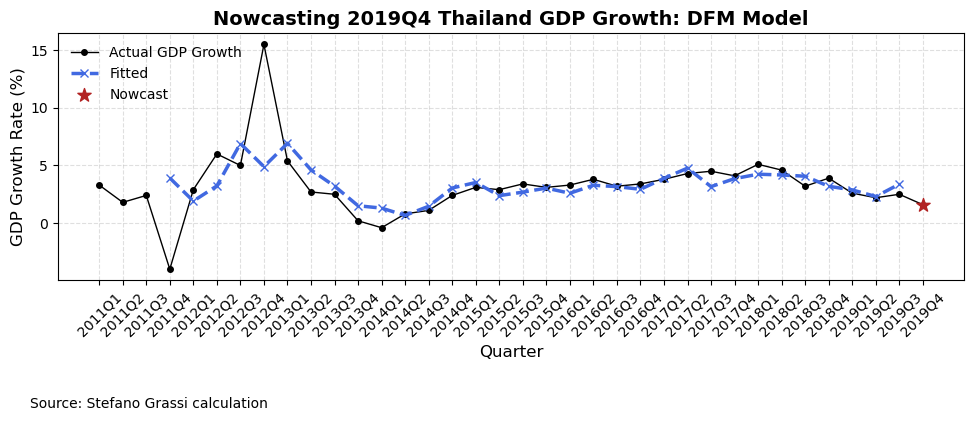

In [19]:
# Plot DFM Nowcast
plot_nowcast(
    actual_dates=df_gdp['quarter'],
    actual_values=df_gdp['gdp_growth'],
    fitted_dates=dfm_model_fitted_dates,
    fitted_values=dfm_model_fitted_values,
    nowcast_date=y_test['quarter'].iloc[0],
    nowcast_value=nowcast_dfm.iloc[0],
    title="Nowcasting 2019Q4 Thailand GDP Growth: DFM Model",
    fitted_label="Fitted",
    source="Source: Stefano Grassi calculation"
)

## Factor-MIDAS

#### Accuracy

In [20]:
# Import Least Squares method
from scipy.optimize import least_squares

In [21]:
# === Factor-MIDAS ===

class FACTORMIDAS:
    """
    Base Factor-MIDAS model implementation based on Marcellino and Schumacher (2007).

    This model extracts latent factors via PCA from monthly indicators,
    and uses a parameterized MIDAS polynomial to weight lagged monthly factors
    for use in predicting quarterly targets such as GDP growth.

    Parameters
    ----------
    n_factors : int, default=1
        Number of principal components (latent factors) to extract from monthly data.
    n_lags : int, default=1
        Number of monthly lags to include for each factor in the MIDAS regression.

    Attributes
    ----------
    alpha1_, alpha2_ : float
        MIDAS polynomial parameters estimated via nonlinear least squares.
    beta0_ : float
        Intercept term estimated via nonlinear least squares.
    coeffs_ : ndarray of shape (n_factors,)
        Coefficients for the weighted sum of factors.
    pca_ : PCA object
        Fitted PCA transformer.
    series_list_ : list of str
        Names of input monthly variables used for PCA.
    last_train_factors_ : pd.DataFrame
        Final `n_lags` factor observations used for continuity in prediction.
    fitted_values_ : pd.Series
        In-sample fitted values (quarterly predictions during training).
    """

    def __init__(self, n_factors=3, n_lags=3):
        self.n_factors = n_factors
        self.n_lags = n_lags
        self.alpha1_ = None
        self.alpha2_ = None
        self.beta0_ = None
        self.coeffs_ = None
        self.pca_ = None
        self.series_list_ = None
        self.last_train_factors_ = None
        self.fitted_values_ = None

    def _apply_pca(self, df_wide, fit_pca):
        """
        Extracts latent factors using PCA from monthly panel data.

        Parameters
        ----------
        df_wide : pd.DataFrame
            Monthly data with rows as dates and columns as individual indicators.
        fit_pca : bool
            If True, fit a new PCA model; otherwise use the previously fitted PCA.

        Returns
        -------
        factor_df : pd.DataFrame
            DataFrame containing 'date' and the extracted latent factors.
        """
        df_wide = df_wide.sort_index()

        # If predicting, restrict to columns used during training
        if not fit_pca:
            # Check if self.series_list_ exists before trying to access it
            if self.series_list_ is None:
                raise ValueError("Model not fitted. series_list_ is not initialized.")
            df_wide = df_wide[self.series_list_]
        else:
            self.series_list_ = df_wide.columns.tolist()

        # Fit PCA to extract latent factors from monthly panel
        if fit_pca:
            self.pca_ = PCA(n_components=self.n_factors)
            transformed = self.pca_.fit_transform(df_wide)
        else:
            # Check if self.pca_ exists before trying to use it
            if self.pca_ is None:
                raise ValueError("Model not fitted. PCA model is not initialized.")
            transformed = self.pca_.transform(df_wide)

        # Convert factor matrix to DataFrame with datetime
        factor_df = pd.DataFrame(
            transformed,
            columns=[f'factor_{i+1}' for i in range(self.n_factors)],
            index=df_wide.index
        ).reset_index().rename(columns={'index': 'date'})

        return factor_df

    def _build_design_matrix(self, factor_df, quarters):
        """
        Builds the 3D design matrix of lagged factor values aligned to quarterly periods.

        Parameters
        ----------
        factor_df : pd.DataFrame
            DataFrame with columns ['date', 'factor_1', ..., 'factor_n'].
        quarters : array-like
            Target quarters for which to build lagged factor features.

        Returns
        -------
        X : ndarray of shape (n_quarters, n_factors, n_lags)
            3D array containing lagged factor values for each quarter.
        valid_quarters : pd.Series
            Quarters for which a complete lag window is available.
        """
        factor_df = factor_df.sort_values('date').reset_index(drop=True)
        factor_df['quarter'] = factor_df['date'].dt.to_period('Q')

        X = []
        valid_quarters = []

        for q in quarters:
            # Identify monthly observations within the target quarter
            idx = factor_df.index[factor_df['quarter'] == q]
            if len(idx) == 0:
                continue

            end_idx = idx.max()
            start_idx = end_idx - self.n_lags + 1

            # Skip if not enough lags
            if start_idx < 0:
                continue

            # Extract lagged window of factors for this quarter
            window = factor_df.loc[start_idx:end_idx, 
            [f'factor_{i+1}' for i in range(self.n_factors)]].values

            # Check window length (handle missing data edge case)
            if window.shape[0] == self.n_lags:
                X.append(window.T)  # Transpose to get (factors, lags)
                valid_quarters.append(q)

        # Final design matrix: shape (n_quarters, n_factors, n_lags)
        X = np.array(X) if X else np.empty((0, self.n_factors, self.n_lags))
        return X, pd.Series(valid_quarters)

    def _get_weights(self, alpha1, alpha2):
        """
        Computes exponential Almon polynomial weights used in the MIDAS regression.

        Parameters
        ----------
        alpha1 : float
            Controls the linear decay in the exponential weighting function.
        alpha2 : float
            Controls the curvature in the exponential weighting function.

        Returns
        -------
        weights : ndarray of shape (n_factors, n_lags)
            Normalized weights applied to lagged factors, identical across all factors.
        """
        k_values = np.arange(self.n_lags)  # k from 0 to K-1 (where K = self.n_lags)
        numerator = np.exp(alpha1 * k_values + alpha2 * (k_values**2))
        denominator = np.sum(numerator)

        if denominator == 0: # Handle potential division by zero for extreme alpha values
            # Return zeros if denominator is 0, indicating effectively zero weight
            # This can happen if alpha1 and alpha2 lead to extremely small exp values
            normalized_weights_single_factor = np.zeros(self.n_lags)
        else:
            normalized_weights_single_factor = numerator / denominator

        # All factors share the same weight structure as per common MIDAS practice
        # and the structure of the`params` array.
        return np.tile(normalized_weights_single_factor, (self.n_factors, 1))


    def fit(self, X_monthly_train, y_quarterly_train):
        """
        Fits the Factor-MIDAS model to training data using nonlinear least squares.

        Parameters
        ----------
        X_monthly_train : pd.DataFrame
            Monthly indicators in wide format used to extract latent factors.
        y_quarterly_train : pd.DataFrame
            Quarterly targets to predict, with columns ['quarter', 'gdp_growth'].

        Returns
        -------
        self : FACTORMIDAS
            Fitted model instance with estimated parameters.
        """
        # Step 1: Extract latent factors from monthly panel
        factor_df = self._apply_pca(X_monthly_train, fit_pca=True)
        # Ensure 'date' column is datetime type for consistent operations
        factor_df['date'] = pd.to_datetime(factor_df['date'])

        # Step 2: Build design matrix of lagged monthly factors per quarter
        quarters = y_quarterly_train['quarter'].values
        X_lagged, valid_quarters = self._build_design_matrix(factor_df, quarters)

        # Align y to valid quarters with sufficient data
        y_aligned = y_quarterly_train.set_index('quarter').loc[valid_quarters, 'gdp_growth'].values
        n_obs, n_factors, n_lags = X_lagged.shape

        def residuals(params):
            # Parameters: beta0 (intercept), alpha1, alpha2, 
            # then n_factors regression coefficients
            beta0 = params[0]
            alpha1, alpha2 = params[1], params[2]
            coeffs = params[3:].reshape(n_factors)

            # Construct MIDAS weights
            weights = self._get_weights(alpha1, alpha2)

            # Apply weights to each factor's lag structure
            X_weighted = X_lagged * weights[None, :, :]  # Shape (n_obs, n_factors, n_lags)

            # Collapse lag dimension using sum (this gives the B(L_m; theta) * f_i,t term)
            X_compressed = X_weighted.sum(axis=2)  # Shape (n_obs, n_factors)

            # Predicted values: intercept + linear combination of weighted factors
            y_pred = beta0 + (X_compressed @ coeffs)

            return y_aligned - y_pred  # Residuals for least squares

        # Initial values: now include an initial guess for the intercept (e.g., 0.0)
        # Order: [beta0, alpha1, alpha2, coeffs...]
        initial_params = np.concatenate([[0.0, 1.0, 1.0], np.zeros(n_factors)])
        # Bounds: [beta0_lower, alpha1_lower, alpha2_lower, coeffs_lower...]
        bounds_lower = [-np.inf, 0.01, 0.01] + [-np.inf] * n_factors
        # Bounds: [beta0_upper, alpha1_upper, alpha2_upper, coeffs_upper...]
        bounds_upper = [np.inf, 10.0, 10.0] + [np.inf] * n_factors

        # Nonlinear least squares optimization
        result = least_squares(residuals, initial_params, bounds=(bounds_lower, bounds_upper),
                               method='trf')

        # Store estimated parameters
        self.beta0_ = result.x[0] # Store intercept
        self.alpha1_, self.alpha2_ = result.x[1], result.x[2]
        self.coeffs_ = result.x[3:]

        # Save last monthly factor observations for future prediction
        self.last_train_factors_ = factor_df.sort_values('date').tail(self.n_lags).copy()
        # If n_lags = 3, we need the last 3 observations for the next prediction's lags.
        # The first prediction will use the last 3 obs from training.

        # Store in-sample fitted values for diagnostics
        # Re-calculate with optimal parameters
        weights = self._get_weights(self.alpha1_, self.alpha2_)
        X_weighted = X_lagged * weights[None, :, :]
        X_compressed = X_weighted.sum(axis=2)
        fitted_vals = self.beta0_ + (X_compressed @ self.coeffs_) # Include intercept here
        self.fitted_values_ = pd.Series(fitted_vals, index=valid_quarters)

        return self

    def predict(self, X_monthly_test):
        """
        Predicts quarterly values using new monthly data.

        Parameters
        ----------
        X_monthly_test : pd.DataFrame
            Monthly indicators in the same format as during training.

        Returns
        -------
        predictions : pd.Series
            Predicted quarterly values, indexed by quarter.
        """
        # Sanity check to ensure model is trained
        if (self.pca_ is None or self.series_list_ is None or
            self.beta0_ is None or self.coeffs_ is None): # Check for beta0_ as well
            raise ValueError("Model must be fitted before calling predict().")

        # Transform new monthly data using trained PCA
        factor_df_test = self._apply_pca(X_monthly_test, fit_pca=False)
        factor_df_test['date'] = pd.to_datetime(factor_df_test['date'])


        # Combine last factors from training with new data for continuity
        # Ensure proper column alignment and indexing for concatenation
        # The 'date' column needs to be the index for concat to work well if not ignoring index
        # or just ensure all necessary columns are present.
        # It's safer to ensure column order before concat
        cols = [f'factor_{i+1}' for i in range(self.n_factors)] + ['date']
        factor_df_full = pd.concat([self.last_train_factors_[cols], factor_df_test[cols]], ignore_index=True)
        # Ensure date is sorted again after concatenation
        factor_df_full = factor_df_full.sort_values('date').reset_index(drop=True)
        
        # Let's predict for quarters whose last monthly observation falls within X_monthly_test
        # Get quarters from the test data only
        test_quarters = factor_df_test['date'].dt.to_period('Q').unique()


        # Rebuild design matrix for forecasting. This matrix will be longer if X_monthly_test spans multiple quarters
        X_lagged, valid_quarters = self._build_design_matrix(factor_df_full, test_quarters)

        # Apply learned MIDAS weights and coefficients
        weights = self._get_weights(self.alpha1_, self.alpha2_)
        X_weighted = X_lagged * weights[None, :, :]
        X_compressed = X_weighted.sum(axis=2)

        # Final quarterly predictions
        y_pred = self.beta0_ + (X_compressed @ self.coeffs_) # Include intercept here

        # Return predictions with corresponding quarters
        return pd.Series(y_pred, index=valid_quarters, name='prediction')

In [22]:
# Train the model

# Re-initialize values for MIDAS
best_rmse = np.inf
best_factors = None
best_lags = None

# Grid search
for n_factors in factor_range:
    for n_lags in lag_range:
        try:
            # Initialize and fit model on training set only
            midas = FACTORMIDAS(n_factors=n_factors, n_lags=n_lags)
            midas.fit(Xm_train_std, y_train)

            # Predict on validation set
            y_val_pred = midas.predict(Xm_val_std)

            # Compute RMSE on validation
            rmse = np.sqrt(mean_squared_error(y_val['gdp_growth'], y_val_pred))

            # Store best
            if rmse < best_rmse:
                best_rmse = rmse
                best_factors = n_factors
                best_lags = n_lags

        except Exception as e:
            print(f"Failed for factors={n_factors}, lags={n_lags}: {e}")
print(f"Best validation RMSE from Grid Search: {best_rmse:.4f} with {best_factors} Factors and {best_lags} Lags")

Best validation RMSE from Grid Search: 0.1510 with 2 Factors and 1 Lags


In [23]:
# Initialize Factor-MIDAS model with n factor and n lags
midas_model = FACTORMIDAS(n_factors=2, n_lags=1)

# Fit model on standardized monthly predictors and quarterly GDP growth
midas_model.fit(Xm_train_full_std, y_train_full)

# Nowcast GDP growth for 2019Q4
nowcast_value_midas = midas_model.predict(Xm_test_std)
nowcast_midas = pd.Series([nowcast_value_midas.iloc[0]], index=[pd.Period('2019Q4', freq='Q')], name='nowcast')
print(f"Factor-MIDAS nowcast for 2019Q4: {nowcast_midas.iloc[0]:.4f}")

Factor-MIDAS nowcast for 2019Q4: 1.7945


In [24]:
# Get Factor-MIDAS fitted
midas_model_fitted_dates = midas_model.fitted_values_.index
midas_model_fitted_values = midas_model.fitted_values_.values

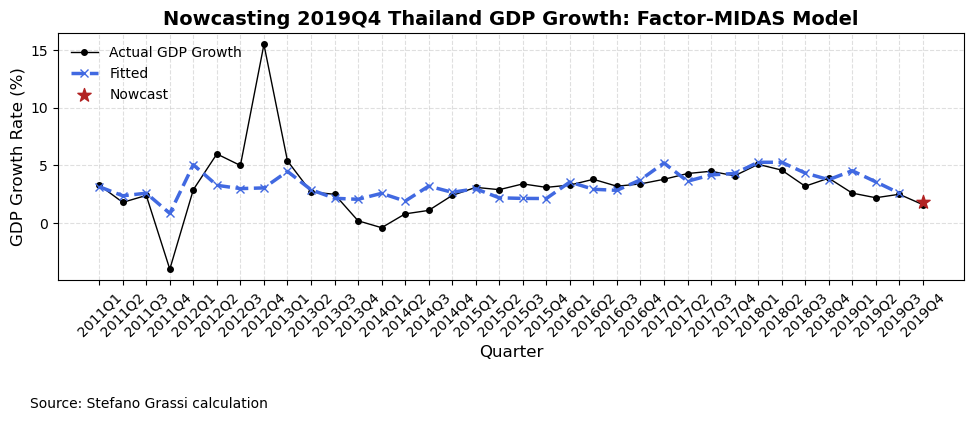

In [25]:
# Plot Factor-MIDAS Nowcast
plot_nowcast(
    actual_dates=df_gdp['quarter'],
    actual_values=df_gdp['gdp_growth'],
    fitted_dates=midas_model_fitted_dates,
    fitted_values=midas_model_fitted_values,
    nowcast_date=y_test['quarter'].iloc[0],
    nowcast_value=nowcast_midas.iloc[0],
    title="Nowcasting 2019Q4 Thailand GDP Growth: Factor-MIDAS Model",
    fitted_label="Fitted",
    source="Source: Stefano Grassi calculation"
)

## Machine Learning Models

## SVR

#### Accuracy

In [26]:
# === Support Vector Regression (SVR) — Vapnik (1995) ===
# SVR implementation using Bayesian Optimization (Snoek et al. 2012)
# to efficiently tune hyperparameters for each kernel type.

from bayes_opt import BayesianOptimization
from sklearn.svm import SVR

# Supported SVR kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
best_results = {}

for kernel in kernels:

    print(f"\n=== Optimizing SVR with kernel: '{kernel}' ===\n")

    # Define kernel-specific hyperparameter search bounds
    if kernel == 'linear':
        pbounds = {
            'C': (1e-6, 1e-0),
            'epsilon': (1e-4, 1e-1),
        }
    elif kernel == 'rbf':
        pbounds = {
            'C': (1e-6, 1e-1),
            'epsilon': (1e-3, 1e-1),
            'gamma': (1e-4, 1e-1),
        }
    elif kernel == 'poly':
        pbounds = {
            'C': (1e-4, 1e-1),
            'epsilon': (1e-4, 1e-1),
            'degree': (2, 5),
            'gamma': (1e-4, 1e-1),
            'coef0': (1e-4, 1e-1),
        }
    elif kernel == 'sigmoid':
        pbounds = {
            'C': (0.1, 1),
            'epsilon': (0.1, 1),
            'gamma': (1e-4, 1e-1),
            'coef0': (0, 1e-4),
        }

    # Objective function for SVR
    def svr_objective(C, epsilon, degree=1, gamma=0.01, coef0=0):
        """
        Objective function for Bayesian Optimization.

        Fits an SVR model on the training set using specified hyperparameters,
        then computes the negative RMSE on the validation set (to be maximized).

        Parameters
        ----------
        C : float
            Regularization parameter.
        epsilon : float
            Epsilon-tube within which no penalty is associated in the training loss.
        degree : float, optional
            Degree of the polynomial kernel (rounded to nearest integer).
        gamma : float, optional
            Kernel coefficient for 'rbf', 'poly', and 'sigmoid'.
        coef0 : float, optional
            Independent term in 'poly' and 'sigmoid' kernels.

        Returns
        -------
        score : float
            Negative RMSE on the validation set.
        """
        degree_int = int(round(degree))

        model_params = {
            'kernel': kernel,
            'C': C,
            'epsilon': epsilon,
        }
        if kernel in ['rbf', 'poly', 'sigmoid']:
            model_params['gamma'] = gamma
        if kernel in ['poly', 'sigmoid']:
            model_params['coef0'] = coef0
        if kernel == 'poly':
            model_params['degree'] = degree_int

        # Train SVR model on training set
        model = SVR(**model_params)
        model.fit(Xq_train_minmax, y_train_minmax)

        # Predict on validation set and evaluate RMSE
        y_pred_scaled = model.predict(Xq_val_minmax)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
        val_true = y_val['gdp_growth'].values

        return -np.sqrt(mean_squared_error(val_true, y_pred))  # Return negative RMSE

    # Perform Bayesian Optimization
    optimizer = BayesianOptimization(
        f=svr_objective,
        pbounds=pbounds,
        verbose=1,  # Prints progress during optimization
        random_state=1
    )

    optimizer.maximize(init_points=5, n_iter=15)

    # Store best results per kernel
    best_results[kernel] = optimizer.max


=== Optimizing SVR with kernel: 'linear' ===

|   iter    |  target   |     C     |  epsilon  |
-------------------------------------------------
| 5         | -0.06322  | 0.3968    | 0.05393   |
| 8         | -0.018    | 0.1493    | 0.06292   |
| 19        | -0.01358  | 0.1479    | 0.06315   |

=== Optimizing SVR with kernel: 'poly' ===

|   iter    |  target   |     C     |   coef0   |  degree   |  epsilon  |   gamma   |
-------------------------------------------------------------------------------------
| 3         | -0.5873   | 0.04198   | 0.06855   | 2.613     | 0.08782   | 0.002836  |
| 5         | -0.3621   | 0.08009   | 0.09683   | 2.94      | 0.06926   | 0.08765   |
| 8         | -0.006608 | 0.09554   | 0.1       | 2.918     | 0.07583   | 0.09456   |

=== Optimizing SVR with kernel: 'rbf' ===

|   iter    |  target   |     C     |  epsilon  |   gamma   |
-------------------------------------------------------------
| 2         | -0.6682   | 0.03023   | 0.01553   | 0.009325  

In [27]:
# --- Model Selection and Evaluation ---

# Select kernel with best validation RMSE (smallest RMSE → largest negative RMSE)
best_overall = None
best_kernel = None

for kernel, res in best_results.items():
    val_rmse_neg = res['target']
    if (best_overall is None) or (val_rmse_neg > best_overall):
        best_overall = val_rmse_neg
        best_kernel = kernel

print(f"Best kernel selected: {best_kernel} with validation RMSE: {-best_overall:.4f}")

# Extract optimal hyperparameters for the best-performing kernel
best_params = best_results[best_kernel]['params']
best_C = best_params['C']
best_epsilon = best_params['epsilon']
best_degree = int(round(best_params.get('degree', 3)))
best_coef0 = best_params.get('coef0', 0)
best_gamma = best_params.get('gamma', 'scale')

# If gamma is a float, keep it; otherwise, fallback to default
gamma_val = best_gamma if isinstance(best_gamma, float) else 'scale'

# Finalize parameters for SVR model
best_svr_params = {
    'kernel': best_kernel,
    'C': best_C,
    'epsilon': best_epsilon
}
if best_kernel in ['rbf', 'poly', 'sigmoid']:
    best_svr_params['gamma'] = gamma_val
if best_kernel in ['poly', 'sigmoid']:
    best_svr_params['coef0'] = best_coef0
if best_kernel == 'poly':
    best_svr_params['degree'] = best_degree

# Display best parameters
print("\nBest SVR hyperparameters found via Bayesian Optimization (RMSE):\n")
print(best_svr_params)

Best kernel selected: poly with validation RMSE: 0.0066

Best SVR hyperparameters found via Bayesian Optimization (RMSE):

{'kernel': 'poly', 'C': np.float64(0.09553604745464689), 'epsilon': np.float64(0.07583061051354603), 'gamma': np.float64(0.09455770961570496), 'coef0': np.float64(0.1), 'degree': 3}


In [28]:
# Initialize final SVR model with optimized hyperparameters
svr_model_final = SVR(**best_svr_params)

# Fit model on full training set (training + validation)
svr_model_final.fit(Xq_train_full_minmax, y_train_full_minmax)

# Predict GDP growth on standardized test predictors
y_test_pred_scaled = svr_model_final.predict(Xq_test_minmax)

# Inverse transform predictions to original GDP growth scale
nowcast_value_svr = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
nowcast_svr = pd.Series([nowcast_value_svr[0]], index=[pd.Period('2019Q4', freq='Q')], name='nowcast')

# Print SVR nowcast for 2019Q4
print(f"SVR nowcast for 2019Q4: {nowcast_svr.iloc[0]:.4f}")

SVR nowcast for 2019Q4: 2.7382


In [29]:
# Get fitted values (in-sample predictions on the training set)
svr_fitted_scaled = svr_model_final.predict(Xq_train_full_minmax)

# Inverse transform to original GDP growth scale
svr_fitted_values = scaler_y.inverse_transform(svr_fitted_scaled.reshape(-1, 1)).flatten()

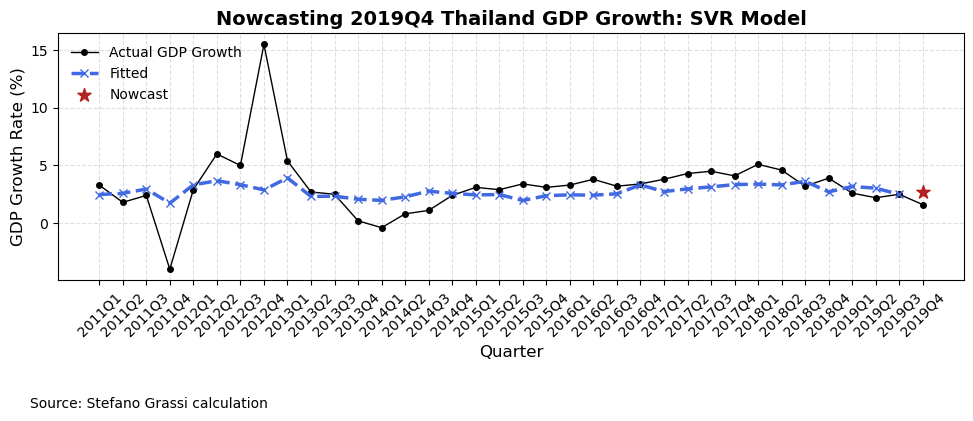

In [30]:
# Plot SVR Nowcast
plot_nowcast(
    actual_dates=df_gdp['quarter'],
    actual_values=df_gdp['gdp_growth'],
    fitted_dates=y_train_full['quarter'], 
    fitted_values=svr_fitted_values,  
    nowcast_date=y_test['quarter'].iloc[0],
    nowcast_value=nowcast_svr.iloc[0],
    title="Nowcasting 2019Q4 Thailand GDP Growth: SVR Model",
    fitted_label="Fitted",
    source="Source: Stefano Grassi calculation"
)

#### Interpretability

In [31]:
#==== Interpretability ====
# SHAP integration (Lundberg and Lee 2017)


# Import SHAP
import shap

# Define function for running SHAP explanation
def run_shap_explanation(model, X_train, X_explain, feature_names, explainer_type='auto', sample_size=100):
    """
    Computes SHAP values for a given model and dataset using an appropriate explainer.

    Parameters
    ----------
    model : object
        Trained machine learning model. Can be a tree-based model (e.g., XGBoost),
        kernel model (e.g., SVR), or a neural network.
    X_train : array-like or pd.DataFrame
        Training dataset used to select a background sample for SHAP.
    X_explain : array-like or pd.DataFrame
        Data to compute SHAP values for (i.e., the samples to explain).
    feature_names : list of str
        Names of the features used for explanation (optional in SHAP, but often helpful for visualization).
    explainer_type : {'auto', 'tree', 'deep', 'gradient', 'linear', 'kernel'}, default='auto'
        Type of SHAP explainer to use. If 'auto', the type is inferred from the model class.
    sample_size : int, default=100
        Number of training samples to use as the background set for the SHAP explainer.

    Returns
    -------
    shap_values : list or np.ndarray
        Computed SHAP values for the input data `X_explain`.
    explainer : shap.Explainer
        The SHAP explainer instance used to compute the values.
    """
    # Use the first `sample_size` samples as background
    if isinstance(X_train, np.ndarray):
        background = X_train[:sample_size]
    else:
        background = X_train.iloc[:sample_size]

    # Auto-select explainer type if 'auto'
    if explainer_type == 'auto':
        model_type = str(type(model))
        if any(x in model_type for x in ['XGB', 'LightGBM', 'RandomForest']):
            explainer_type = 'tree'
        elif 'SVR' in model_type:
            explainer_type = 'kernel'
        elif 'Keras' in model_type or 'tensorflow' in model_type:
            # Use gradient explainer for neural nets (good for RNNs)
            explainer_type = 'gradient'
        elif 'Ridge' in model_type or 'Lasso' in model_type or 'Linear' in model_type:
            explainer_type = 'linear'
        else:
            explainer_type = 'kernel'

    # Choose explainer based on type
    if explainer_type == 'tree':
        explainer = shap.TreeExplainer(model)
    elif explainer_type == 'deep':
        explainer = shap.DeepExplainer(model, background)
    elif explainer_type == 'gradient':
        explainer = shap.GradientExplainer(model, background)
    elif explainer_type == 'linear':
        explainer = shap.LinearExplainer(model, background)
    else:  # kernel fallback
        explainer = shap.KernelExplainer(model.predict, background)

    # Compute SHAP values
    shap_values = explainer.shap_values(X_explain)

    return shap_values, explainer

In [32]:
# === Level of Alignment in Interpretative Signals (LAIS) ===
# Developed by Stefano Grassi (2025)

def calculate_relative_lais(feature_scores_data):
    """
    Calculates the Relative Level of Alignment in Interpretative Signals (Relative LAIS),
    normalized between -1 and 1. Neutral (0) scores are excluded.
    The score is relative to the maximum possible alignment given the number
    of non-neutral features (i.e., if all non-neutral scores were +1).

    Parameters
    ----------
    feature_scores_data : list of dict
        Each dict should contain:
        - 'variable_name': str
            Name of the feature.
        - 'likert_score': int
            Narrative alignment score: -1 (misaligned), 0 (neutral/unmentioned), +1 (aligned).

    Returns
    -------
    relative_lais : float
        Final normalized interpretability score in [-1, 1].
        Returns 0.0 if no directional alignment is present.
    """
    directional_scores = [item['likert_score'] for item in feature_scores_data if item['likert_score'] in [-1, 1]]

    if not directional_scores:
        return 0.0

    total_score = sum(directional_scores)
    max_possible = len(directional_scores)  # all +1s

    relative_lais = total_score / max_possible
    return round(relative_lais, 3)

In [33]:
# Get Features name
feature_names = Xq_train_full_wide.columns.tolist()

# Define X_explain
X_explain = Xq_test_minmax[:17]

In [34]:
# Get SHAP values for SVR
svr_shap_vals, svr_explainer = run_shap_explanation(
    model=svr_model_final,
    X_train=Xq_train_full_minmax,
    X_explain=X_explain,
    feature_names=feature_names,
    explainer_type='kernel',
    
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
# === Plot SHAP summary bar ===
def plot_shap_bar(shap_values, expected_value, X_explain_row, feature_names, 
                           max_display=17, figsize=(8, 6), title="SHAP Feature Importance", 
                           save_path=None, show=True):
    """
    Plots and optionally saves a SHAP summary bar plot.

    Parameters
    ----------
    shap_values : array-like
        SHAP values for a single sample or aggregated values.
    expected_value : float
        Expected value from the SHAP explainer.
    X_explain_row : array-like
        Row of the input data corresponding to shap_values.
    feature_names : list of str
        Names of the features.
    max_display : int, optional
        Maximum number of features to display.
    figsize : tuple, optional
        Size of the figure.
    title : str, optional
        Plot title.
    save_path : str or None, optional
        File path to save the figure. If None, the figure is not saved.
    show : bool, optional
        Whether to display the plot.
    """
    # Create SHAP explanation object
    explanation = shap.Explanation(
        values=shap_values,
        base_values=expected_value,
        data=X_explain_row,
        feature_names=feature_names
    )

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # Plot SHAP bar chart
    shap.plots.bar(explanation, ax=ax, max_display=max_display, show=False)

    # Add legend
    handles = [
        plt.Line2D([0], [0], color='#FF0D57', lw=4),
        plt.Line2D([0], [0], color='#1E88E5', lw=4)
    ]
    labels = ["Positive impact on prediction", "Negative impact on prediction"]

    ax.legend(
        handles, labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.18),  
        ncol=2,                      
        frameon=True
    )

    # Add title
    ax.set_title(title, pad=40)
    plt.tight_layout()

    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    
    # Show plot if requested
    if show:
        plt.show()
    else:
        plt.close(fig)

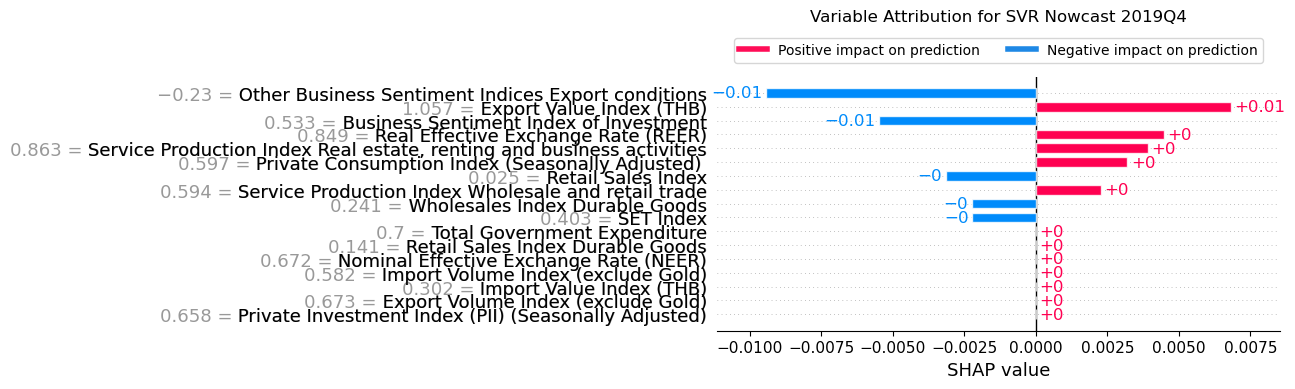

In [36]:
# === Plot SVR SHAP summary bar ===
plot_shap_bar(shap_values = svr_shap_vals[0], 
              expected_value = svr_explainer.expected_value, 
              X_explain_row = X_explain[0], 
              feature_names = feature_names, 
              max_display=17, figsize=(13, 4), title="Variable Attribution for SVR Nowcast 2019Q4", 
              save_path=None
             )

In [37]:
# Create SHAP dataframe
def create_shap_df(shap_values, feature_names, top_n=None):
    """
    Creates and returns a pandas DataFrame of SHAP values and their
    corresponding feature names, sorted by absolute SHAP value.

    Parameters
    ----------
    shap_values : np.ndarray
        An array of SHAP values for a single instance.
    feature_names : list
        A list of feature names.
    top_n : int, optional
        The number of top features to display. 
        Defaults to None (display all).

    Returns
    -------
    pd.DataFrame
        A DataFrame with 'Feature' and 'SHAP Value' columns.
    """
    if len(shap_values) != len(feature_names):
        raise ValueError("The number of SHAP values must match the number of feature names.")

    # Create a DataFrame
    shap_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP Value': shap_values
    })

    # Sort by the absolute value of SHAP to see the most important features first
    shap_df['Absolute SHAP'] = shap_df['SHAP Value'].abs()
    shap_df = shap_df.sort_values(by='Absolute SHAP', ascending=False).drop(columns='Absolute SHAP')
    # Reset index
    shap_df = shap_df.reset_index(drop=True)

    # Return the top N features if specified
    if top_n is not None:
        return shap_df.head(top_n)
    else:
        return shap_df

In [38]:
# Print SVR SHAP df
create_shap_df(svr_shap_vals[0], feature_names, top_n=None)

Feature  SHAP Value
0   Other Business Sentiment Indices Export condit...   -0.009437
1                            Export Value Index (THB)    0.006824
2              Business Sentiment Index of Investment   -0.005486
3                 Real Effective Exchange Rate (REER)    0.004484
4   Service Production Index Real estate, renting ...    0.003910
5    Private Consumption Index (Seasonally Adjusted)     0.003201
6                                  Retail Sales Index   -0.003151
7   Service Production Index Wholesale and retail ...    0.002273
8                      Wholesales Index Durable Goods   -0.002242
9                                           SET Index   -0.002228
10             Nominal Effective Exchange Rate (NEER)    0.000000
11                 Import Volume Index (exclude Gold)    0.000000
12                   Retail Sales Index Durable Goods    0.000000
13                           Import Value Index (THB)    0.000000
14                 Export Volume Index (exclude Gold)    0.000000
15                       Total Government Expenditure    0.000000
16  Private Investment Index (PII) (Seasonally Adj...    0.000000

In [39]:
# Define model scores for calculation of model agnostic interpretability scores
svr_lais_scores = [
    {
        'variable_name': 'Service Production Index Wholesale and retail trade',
        'likert_score': -1
    },
    {
        'variable_name': 'Business Sentiment Index of Investment',
        'likert_score': 0
    },
    {
        'variable_name': 'Other Business Sentiment Indices Export conditions',
        'likert_score': 1
    },
    {
        'variable_name': 'Total Government Expenditure',
        'likert_score': 0
    },
    {
        'variable_name': 'Service Production Index Real estate, renting and business activities',
        'likert_score': 1
    },
    {
        'variable_name': 'Retail Sales Index Durable Goods',
        'likert_score': 0    },
    {
        'variable_name': 'Real Effective Exchange Rate (REER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Import Volume Index (exclude Gold)',
        'likert_score': 0
    },
    {
        'variable_name': 'SET Index',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Investment Index (PII) (Seasonally Adjusted)',
        'likert_score': 0
    },
    {
        'variable_name': 'Wholesales Index Durable Goods',
        'likert_score': 0
    },
    {
        'variable_name': 'Retail Sales Index',
        'likert_score': 1
    },
    {
        'variable_name': 'Export Volume Index (exclude Gold)',
        'likert_score': 0
    },
    {
        'variable_name': 'Nominal Effective Exchange Rate (NEER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Consumption Index (Seasonally Adjusted)',
        'likert_score': -1
    },
    {
        'variable_name': 'Export Value Index (THB)',
        'likert_score': -1
    },
    {
        'variable_name': 'Import Value Index (THB)',
        'likert_score': 0
    },
]

# Get Relative LAIS 
svr_lais = calculate_relative_lais(svr_lais_scores)
print(f"Interpretability (Relative LAIS) score for SVR nowcast for 2019Q4: {svr_lais}")

Interpretability (Relative LAIS) score for SVR nowcast for 2019Q4: 0.0


### k-Nearest Neighbors (kNN)

#### Accuracy

In [40]:
# === k-Nearest Neighbors (kNN) (Fix & Hodges, 1951) ===
# kNN implementation using Bayesian Optimization to tune n_neighbors, p, leaf_size and weights.

from sklearn.neighbors import KNeighborsRegressor

# Define search bounds for kNN hyperparameters
pbounds = {
    'n_neighbors': (2, 10),
    'p': (1, 2),           # 1 = Manhattan distance, 2 = Euclidean
    'leaf_size': (1, 30),  # Leaf size for KD-tree/ball-tree
    'weights_float': (0, 1)  # Categorical weights: 0 -> 'uniform', 1 -> 'distance'
}

# Objective function: Negative RMSE on validation set
def knn_objective(n_neighbors, p, leaf_size, weights_float):
    """
    Objective function for Bayesian Optimization of k-Nearest Neighbors.

    Trains a KNeighborsRegressor using the specified hyperparameters,
    then computes the negative RMSE on the validation set (to be maximized).

    Parameters
    ----------
    n_neighbors : float
        Number of neighbors to use (rounded to nearest integer).
    p : float
        Power parameter for the Minkowski distance metric (1 = Manhattan, 2 = Euclidean).
    leaf_size : float
        Leaf size for KD-tree or Ball-tree (rounded to nearest integer).
    weights_float : float
        Encoded weights parameter (0 = 'uniform', 1 = 'distance').

    Returns
    -------
    score : float
        Negative root mean squared error (RMSE) on the validation set.
    """
    n_neighbors = int(round(n_neighbors))
    p = round(p, 1)
    leaf_size = int(round(leaf_size))
    weights = 'uniform' if weights_float < 0.5 else 'distance'

    model = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        p=p,
        leaf_size=leaf_size,
        weights=weights
    )

    model.fit(Xq_train_minmax, y_train_minmax)

    y_pred_scaled = model.predict(Xq_val_minmax)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    val_true = y_val['gdp_growth'].values

    return -np.sqrt(mean_squared_error(val_true, y_pred))  # Return negative RMSE

# Perform Bayesian Optimization
optimizer_knn = BayesianOptimization(
    f=knn_objective,
    pbounds=pbounds,
    verbose=1,
    random_state=1
)

optimizer_knn.maximize(init_points=5, n_iter=15)

# Extract best parameters
best_knn_params = optimizer_knn.max['params']
best_n_neighbors = int(round(best_knn_params['n_neighbors']))
best_p = round(best_knn_params['p'], 1)
best_leaf_size = int(round(best_knn_params['leaf_size']))
best_weights = 'uniform' if best_knn_params['weights_float'] < 0.5 else 'distance'

# Extract best validation RMSE
best_val_rmse_knn = -optimizer_knn.max['target']
print(f"Best validation RMSE from Bayesian Optimization: {best_val_rmse_knn:.4f}")

# Display best parameters
print("\nBest kNN hyperparameters found via Bayesian Optimization (RMSE):\n")
print({
    'n_neighbors': best_n_neighbors,
    'p': best_p,
    'leaf_size': best_leaf_size,
    'weights': best_weights
})

|   iter    |  target   | leaf_size | n_neig... |     p     | weight... |
-------------------------------------------------------------------------
| 7         | -0.1143   | 20.21     | 6.701     | 1.014     | 0.1016    |
Best validation RMSE from Bayesian Optimization: 0.1143

Best kNN hyperparameters found via Bayesian Optimization (RMSE):

{'n_neighbors': 7, 'p': np.float64(1.0), 'leaf_size': 20, 'weights': 'uniform'}


In [41]:
# Finalize and retrain on full training set
knn_model_final = KNeighborsRegressor(
    n_neighbors=best_n_neighbors,
    weights=best_weights,
    p=best_p,
    leaf_size= best_leaf_size
)
knn_model_final.fit(Xq_train_full_minmax, y_train_full_minmax)

# Predict on test set and inverse-transform
y_test_pred_scaled_knn = knn_model_final.predict(Xq_test_minmax)
nowcast_value_knn = scaler_y.inverse_transform(y_test_pred_scaled_knn.reshape(-1, 1)).flatten()
nowcast_knn = pd.Series([nowcast_value_knn[0]], index=[pd.Period('2019Q4', freq='Q')], name='nowcast')

print(f"kNN nowcast for 2019Q4: {nowcast_knn.iloc[0]:.4f}")

kNN nowcast for 2019Q4: 3.2286


In [42]:
# Get fitted values (in-sample predictions on the training set)
knn_fitted_scaled = knn_model_final.predict(Xq_train_full_minmax)

# Inverse transform to original GDP growth scale
knn_fitted_values = scaler_y.inverse_transform(knn_fitted_scaled.reshape(-1, 1)).flatten()

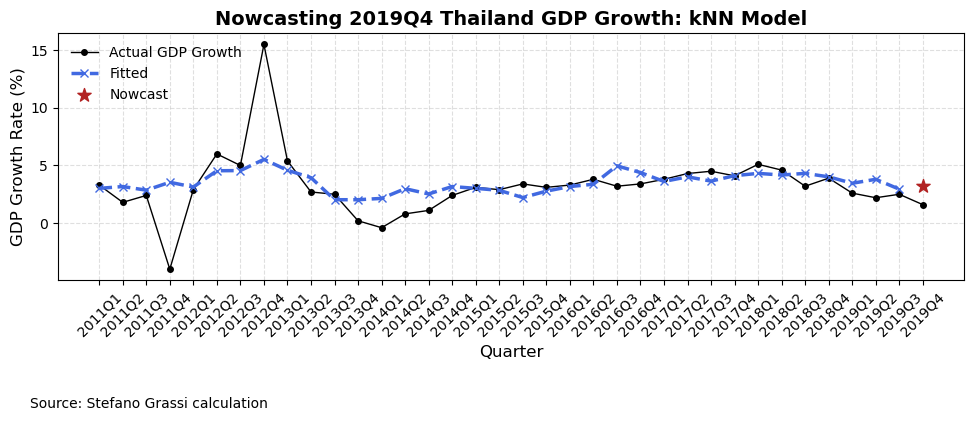

In [43]:
# Plot kNN Nowcast
plot_nowcast(
    actual_dates=df_gdp['quarter'],
    actual_values=df_gdp['gdp_growth'],
    fitted_dates=y_train_full['quarter'], 
    fitted_values=knn_fitted_values,  
    nowcast_date=y_test['quarter'].iloc[0],
    nowcast_value=nowcast_knn.iloc[0],
    title="Nowcasting 2019Q4 Thailand GDP Growth: kNN Model",
    fitted_label="Fitted",
    source="Source: Stefano Grassi calculation"
)

#### Interpretability

In [44]:
# Get SHAP values for kNN model 
knn_shap_vals, knn_explainer = run_shap_explanation(
    model=knn_model_final,
    X_train=Xq_train_full_minmax,
    X_explain=X_explain,
    feature_names=feature_names,
    explainer_type='kernel', 
)

  0%|          | 0/1 [00:00<?, ?it/s]

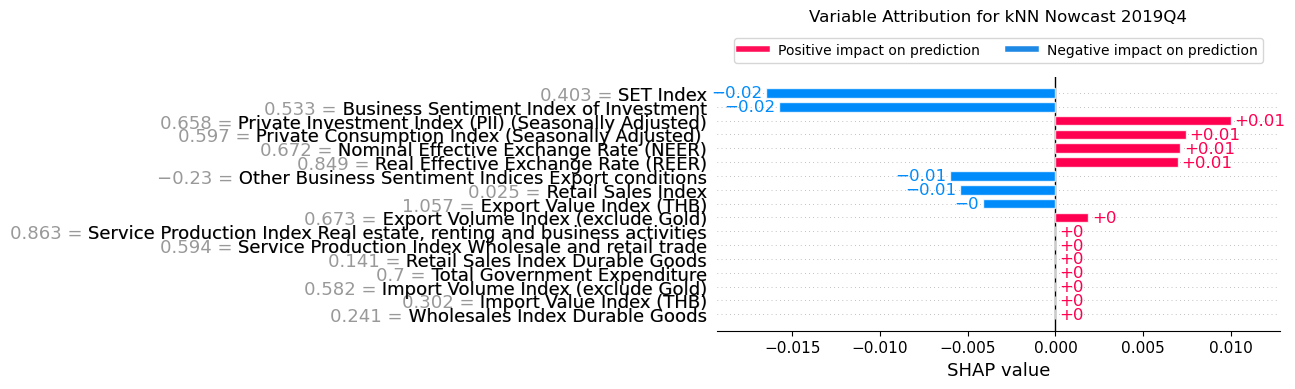

In [45]:
# === Plot kNN SHAP summary bar ===
plot_shap_bar(shap_values = knn_shap_vals[0], 
              expected_value = knn_explainer.expected_value, 
              X_explain_row = X_explain[0], 
              feature_names = feature_names, 
              max_display=17, figsize=(13, 4), title="Variable Attribution for kNN Nowcast 2019Q4", 
              save_path=None)

In [46]:
# Print kNN SHAP df
create_shap_df(knn_shap_vals[0], feature_names, top_n=None)

Feature  SHAP Value
0                                           SET Index   -0.016519
1              Business Sentiment Index of Investment   -0.015752
2   Private Investment Index (PII) (Seasonally Adj...    0.010013
3    Private Consumption Index (Seasonally Adjusted)     0.007435
4              Nominal Effective Exchange Rate (NEER)    0.007116
5                 Real Effective Exchange Rate (REER)    0.006961
6   Other Business Sentiment Indices Export condit...   -0.006027
7                                  Retail Sales Index   -0.005464
8                            Export Value Index (THB)   -0.004137
9                  Export Volume Index (exclude Gold)    0.001868
10                           Import Value Index (THB)    0.000000
11                 Import Volume Index (exclude Gold)    0.000000
12                   Retail Sales Index Durable Goods    0.000000
13  Service Production Index Real estate, renting ...    0.000000
14  Service Production Index Wholesale and retail ...    0.000000
15                       Total Government Expenditure    0.000000
16                     Wholesales Index Durable Goods    0.000000

In [47]:
# Define model scores for calculation of model agnostic interpretability scores
knn_lais_scores = [
    {
        'variable_name': 'Service Production Index Wholesale and retail trade',
        'likert_score': 0
    },
    {
        'variable_name': 'Business Sentiment Index of Investment',
        'likert_score': 0
    },
    {
        'variable_name': 'Other Business Sentiment Indices Export conditions',
        'likert_score': 1
    },
    {
        'variable_name': 'Total Government Expenditure',
        'likert_score': 0
    },
    {
        'variable_name': 'Service Production Index Real estate, renting and business activities',
        'likert_score': 0
    },
    {
        'variable_name': 'Retail Sales Index Durable Goods',
        'likert_score': 0    },
    {
        'variable_name': 'Real Effective Exchange Rate (REER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Import Volume Index (exclude Gold)',
        'likert_score': 0
    },
    {
        'variable_name': 'SET Index',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Investment Index (PII) (Seasonally Adjusted)',
        'likert_score': 0
    },
    {
        'variable_name': 'Wholesales Index Durable Goods',
        'likert_score': 0
    },
    {
        'variable_name': 'Retail Sales Index',
        'likert_score': 1
    },
    {
        'variable_name': 'Export Volume Index (exclude Gold)',
        'likert_score': -1
    },
    {
        'variable_name': 'Nominal Effective Exchange Rate (NEER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Consumption Index (Seasonally Adjusted)',
        'likert_score': -1
    },
    {
        'variable_name': 'Export Value Index (THB)',
        'likert_score': 1
    },
    {
        'variable_name': 'Import Value Index (THB)',
        'likert_score': 0
    },
]

# Get LAIS score
knn_lais = calculate_relative_lais(knn_lais_scores)
print(f"Interpretability (Relative LAIS) score for KNN nowcast for 2019Q4: {knn_lais}")

Interpretability (Relative LAIS) score for KNN nowcast for 2019Q4: 0.2


### Ridge

#### Accuracy

In [48]:
# === Ridge Regression (Hoerl & Kennard, 1970) ===
# Hyperparameter tuning for alpha using Bayesian Optimization

from sklearn.linear_model import Ridge

# Dictionary to store best Ridge result
best_ridge_result = {}

# Define the objective function for Ridge
def ridge_objective(alpha):
    """
    Objective function for Bayesian Optimization of Ridge Regression.

    Trains a Ridge regression model using the specified regularization strength (alpha),
    and evaluates performance using the negative RMSE on a validation set.

    Parameters
    ----------
    alpha : float
        Regularization strength (L2 penalty term) for Ridge regression.

    Returns
    -------
    score : float
        Negative root mean squared error (RMSE) on the validation set.
    """
    # Create and train Ridge model with given alpha
    model = Ridge(alpha=alpha)
    model.fit(Xq_train_minmax, y_train_minmax)

    # Predict on validation set
    y_pred_scaled = model.predict(Xq_val_minmax)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    val_true = y_val['gdp_growth'].values

    # Return negative RMSE for maximization
    return -np.sqrt(mean_squared_error(val_true, y_pred))

# Define search bounds for alpha 
pbounds_ridge = {
    'alpha': (0.1, 10)
}

# Perform Bayesian Optimization
optimizer_ridge = BayesianOptimization(
    f=ridge_objective,
    pbounds=pbounds_ridge,
    verbose=1,
    random_state=42
)

print("\n=== Optimizing Ridge Regression ===\n")
optimizer_ridge.maximize(init_points=5, n_iter=15)

# Store best result and corresponding validation RMSE
best_ridge_result = optimizer_ridge.max
best_val_rmse_ridge = -best_ridge_result['target']
print(f"Best validation RMSE from Bayesian Optimization: {best_val_rmse_ridge:.4f}")

# Display best parameters
print("\nBest Ridge hyperparameters found via Bayesian Optimization (RMSE):\n")
print(best_ridge_result)


=== Optimizing Ridge Regression ===

|   iter    |  target   |   alpha   |
-------------------------------------
| 6         | -0.8143   | 3.759     |
| 7         | -0.8126   | 2.996     |
| 19        | -0.8125   | 2.633     |
Best validation RMSE from Bayesian Optimization: 0.8125

Best Ridge hyperparameters found via Bayesian Optimization (RMSE):

{'target': np.float64(-0.8124641895622005), 'params': {'alpha': np.float64(2.633187207969218)}}


In [49]:
# Extract best alpha from Bayesian Optimization result
final_alpha = best_ridge_result['params']['alpha']

# Initialize final Ridge model with optimized alpha
ridge_model_final = Ridge(alpha=final_alpha)

# Fit model on full training set (training + validation combined)
ridge_model_final.fit(Xq_train_full_minmax, y_train_full_minmax)

# Predict GDP growth using standardized test data (Xq_test_minmax)
y_test_pred_scaled = ridge_model_final.predict(Xq_test_minmax)

# Inverse transform prediction to original GDP growth scale
nowcast_value_ridge = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
nowcast_ridge = pd.Series([nowcast_value_ridge[0]], index=[pd.Period('2019Q4', freq='Q')], name='nowcast')

# Print Ridge nowcast for 2019Q4
print(f"Ridge nowcast for 2019Q4: {nowcast_ridge.iloc[0]:.4f}")

Ridge nowcast for 2019Q4: 3.9751


In [50]:
# Get fitted values (in-sample predictions on full training set)
ridge_fitted_scaled = ridge_model_final.predict(Xq_train_full_minmax)

# Inverse transform to original GDP growth scale
ridge_fitted_values = scaler_y.inverse_transform(ridge_fitted_scaled.reshape(-1, 1)).flatten()

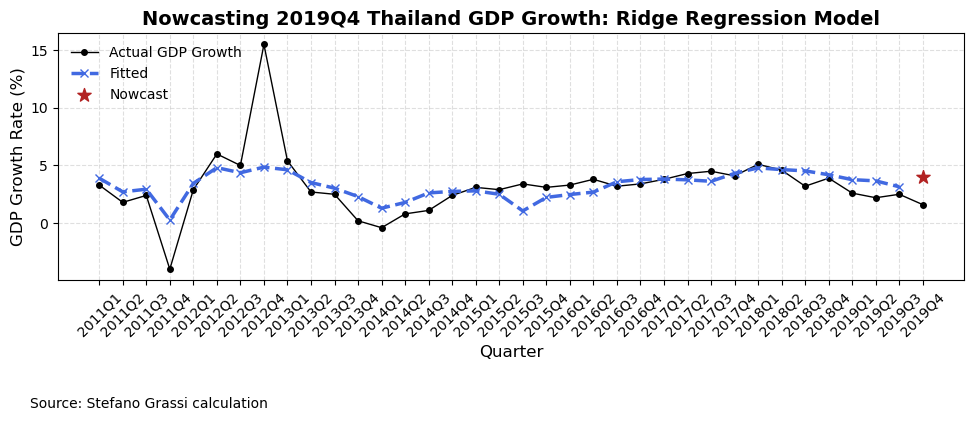

In [51]:
# Plot Ridge Nowcast
plot_nowcast(
    actual_dates=df_gdp['quarter'],
    actual_values=df_gdp['gdp_growth'],
    fitted_dates=y_train_full['quarter'],
    fitted_values=ridge_fitted_values,
    nowcast_date=y_test['quarter'].iloc[0],
    nowcast_value=nowcast_ridge.iloc[0],
    title="Nowcasting 2019Q4 Thailand GDP Growth: Ridge Regression Model",
    fitted_label="Fitted",
    source="Source: Stefano Grassi calculation"
)

#### Interpretability

In [52]:
# Get SHAP values for Ridge model 
ridge_shap_vals, ridge_explainer = run_shap_explanation(
    model=ridge_model_final,
    X_train=Xq_train_full_minmax,
    X_explain=X_explain,
    feature_names=feature_names,
    explainer_type='linear', 
)

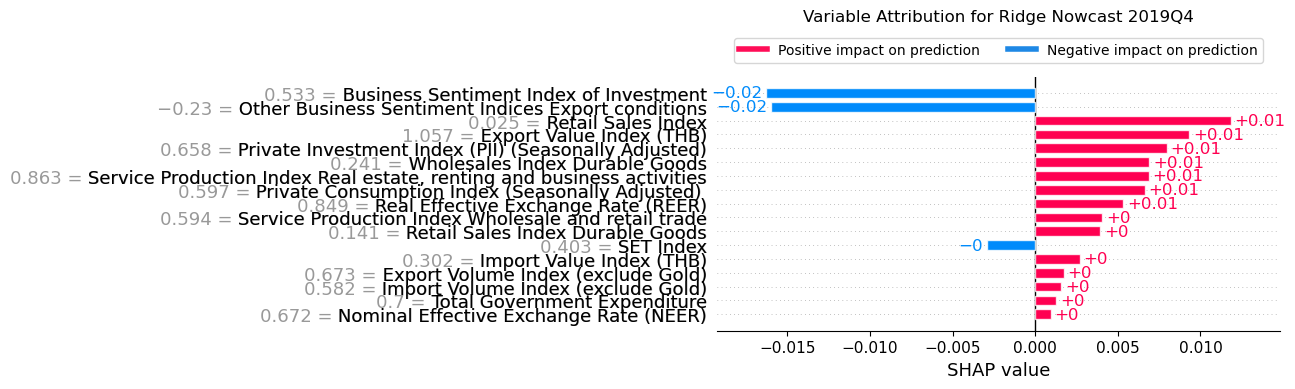

In [53]:
# === Plot Ridge SHAP summary bar ===
plot_shap_bar(shap_values = ridge_shap_vals[0], 
              expected_value = ridge_explainer.expected_value, 
              X_explain_row = X_explain[0], 
              feature_names = feature_names, 
              max_display=17, figsize=(13, 4), title="Variable Attribution for Ridge Nowcast 2019Q4", 
              save_path=None)

In [54]:
# Print Ridge SHAP df
create_shap_df(ridge_shap_vals[0], feature_names, top_n=None)

Feature  SHAP Value
0              Business Sentiment Index of Investment   -0.016307
1   Other Business Sentiment Indices Export condit...   -0.015969
2                                  Retail Sales Index    0.011855
3                            Export Value Index (THB)    0.009327
4   Private Investment Index (PII) (Seasonally Adj...    0.007950
5                      Wholesales Index Durable Goods    0.006914
6   Service Production Index Real estate, renting ...    0.006880
7    Private Consumption Index (Seasonally Adjusted)     0.006639
8                 Real Effective Exchange Rate (REER)    0.005337
9   Service Production Index Wholesale and retail ...    0.004066
10                   Retail Sales Index Durable Goods    0.003945
11                                          SET Index   -0.002930
12                           Import Value Index (THB)    0.002694
13                 Export Volume Index (exclude Gold)    0.001734
14                 Import Volume Index (exclude Gold)    0.001586
15                       Total Government Expenditure    0.001284
16             Nominal Effective Exchange Rate (NEER)    0.000934

In [55]:
# Define model scores for calculation of model agnostic interpretability scores
ridge_lais_scores = [
    {
        'variable_name': 'Service Production Index Wholesale and retail trade',
        'likert_score': -1
    },
    {
        'variable_name': 'Business Sentiment Index of Investment',
        'likert_score': 0
    },
    {
        'variable_name': 'Other Business Sentiment Indices Export conditions',
        'likert_score': 1
    },
    {
        'variable_name': 'Total Government Expenditure',
        'likert_score': -1
    },
    {
        'variable_name': 'Service Production Index Real estate, renting and business activities',
        'likert_score': 1
    },
    {
        'variable_name': 'Retail Sales Index Durable Goods',
        'likert_score': -1    },
    {
        'variable_name': 'Real Effective Exchange Rate (REER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Import Volume Index (exclude Gold)',
        'likert_score': -1
    },
    {
        'variable_name': 'SET Index',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Investment Index (PII) (Seasonally Adjusted)',
        'likert_score': 0
    },
    {
        'variable_name': 'Wholesales Index Durable Goods',
        'likert_score': 0
    },
    {
        'variable_name': 'Retail Sales Index',
        'likert_score': -1
    },
    {
        'variable_name': 'Export Volume Index (exclude Gold)',
        'likert_score': -1
    },
    {
        'variable_name': 'Nominal Effective Exchange Rate (NEER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Consumption Index (Seasonally Adjusted)',
        'likert_score': -1
    },
    {
        'variable_name': 'Export Value Index (THB)',
        'likert_score': -1
    },
    {
        'variable_name': 'Import Value Index (THB)',
        'likert_score': -1
    },
]


# Get LAIS score
ridge_lais = calculate_relative_lais(ridge_lais_scores)
print(f"Interpretability (Relative LAIS) score for Ridge nowcast for 2019Q4: {ridge_lais}")

Interpretability (Relative LAIS) score for Ridge nowcast for 2019Q4: -0.636


### LASSO

#### Accuracy

In [56]:
# === LASSO (Tibshirani, 1996) ===
# Hyperparameter tuning for alpha using Bayesian Optimization

from sklearn.linear_model import Lasso

# Objective function for LASSO Regression
def lasso_objective(alpha):
    """
    Objective function for Bayesian Optimization of LASSO Regression.

    Trains a LASSO regression model using the specified regularization strength (alpha),
    and evaluates its performance by computing the negative RMSE on a validation set.

    Parameters
    ----------
    alpha : float
        Regularization strength (L1 penalty term) for LASSO regression.

    Returns
    -------
    score : float
        Negative root mean squared error (RMSE) on the validation set.
    """
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(Xq_train_minmax, y_train_minmax)
    
    y_pred_scaled = model.predict(Xq_val_minmax)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    val_true = y_val['gdp_growth'].values
    
    return -np.sqrt(mean_squared_error(val_true, y_pred))  # Negative RMSE

# Bayesian Optimization for alpha
optimizer_lasso = BayesianOptimization(
    f=lasso_objective,
    pbounds={'alpha': (1e-3, 1e-2)},
    random_state=1,
    verbose=1
)

optimizer_lasso.maximize(init_points=5, n_iter=15)

# Get best alpha
best_alpha_lasso = optimizer_lasso.max['params']['alpha']
print(f"\nBest alpha for LASSO: {best_alpha_lasso:.6f}")

# Get best corresponding validation RMSE
best_lasso_result = optimizer_lasso.max
best_val_rmse_lasso = -best_lasso_result['target'] 
print(f"Best validation RMSE from Bayesian Optimization: {best_val_rmse_lasso:.4f}")

|   iter    |  target   |   alpha   |
-------------------------------------
| 2         | -0.5419   | 0.007483  |
| 10        | -0.54     | 0.00736   |
| 12        | -0.5366   | 0.007134  |
| 15        | -0.5359   | 0.007087  |
| 19        | -0.5358   | 0.00708   |
| 20        | -0.5358   | 0.007078  |

Best alpha for LASSO: 0.007078
Best validation RMSE from Bayesian Optimization: 0.5358


In [57]:
# Final LASSO model with optimal alpha
lasso_model_final = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_model_final.fit(Xq_train_full_minmax, y_train_full_minmax)

# Predict for test set (nowcast)
y_test_pred_scaled = lasso_model_final.predict(Xq_test_minmax)

# Inverse transform prediction to original GDP growth scale
nowcast_value_lasso = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
nowcast_lasso = pd.Series([nowcast_value_lasso[0]], index=[pd.Period('2019Q4', freq='Q')], name='nowcast')

# Print LASSO nowcast for 2019Q4
print(f"LASSO nowcast for 2019Q4: {nowcast_lasso.iloc[0]:.4f}")

LASSO nowcast for 2019Q4: 2.7330


In [58]:
# Get fitted values (in-sample predictions on the training set)
lasso_fitted_scaled = lasso_model_final.predict(Xq_train_full_minmax)
lasso_fitted_values = scaler_y.inverse_transform(lasso_fitted_scaled.reshape(-1, 1)).flatten()

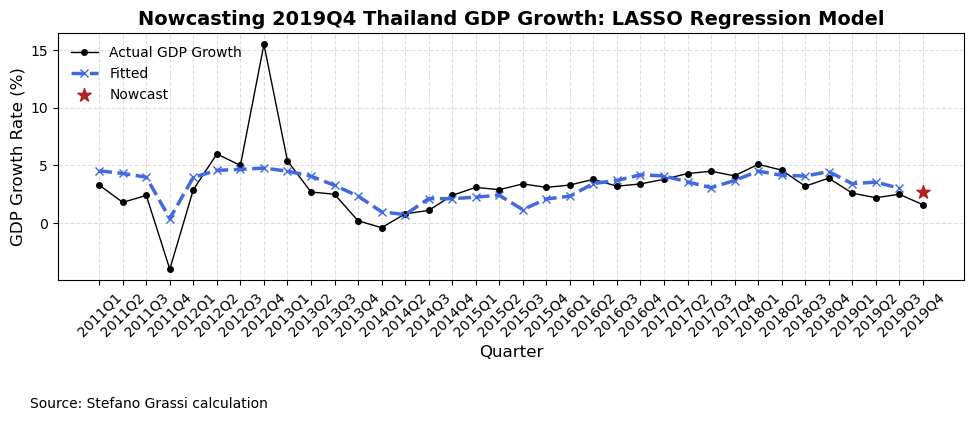

In [59]:
# Plot LASSO Nowcast
plot_nowcast(
    actual_dates=df_gdp['quarter'],
    actual_values=df_gdp['gdp_growth'],
    fitted_dates=y_train_full['quarter'],
    fitted_values=lasso_fitted_values,
    nowcast_date=y_test['quarter'].iloc[0],
    nowcast_value=nowcast_lasso.iloc[0],
    title="Nowcasting 2019Q4 Thailand GDP Growth: LASSO Regression Model",
    fitted_label="Fitted",
    source="Source: Stefano Grassi calculation"
)

#### Interpretability

In [60]:
# Get SHAP values for LASSO model using linear explainer
lasso_shap_vals, lasso_explainer = run_shap_explanation(
    model=lasso_model_final,
    X_train=Xq_train_full_minmax,
    X_explain=X_explain,
    feature_names=feature_names,
    explainer_type='linear',
)

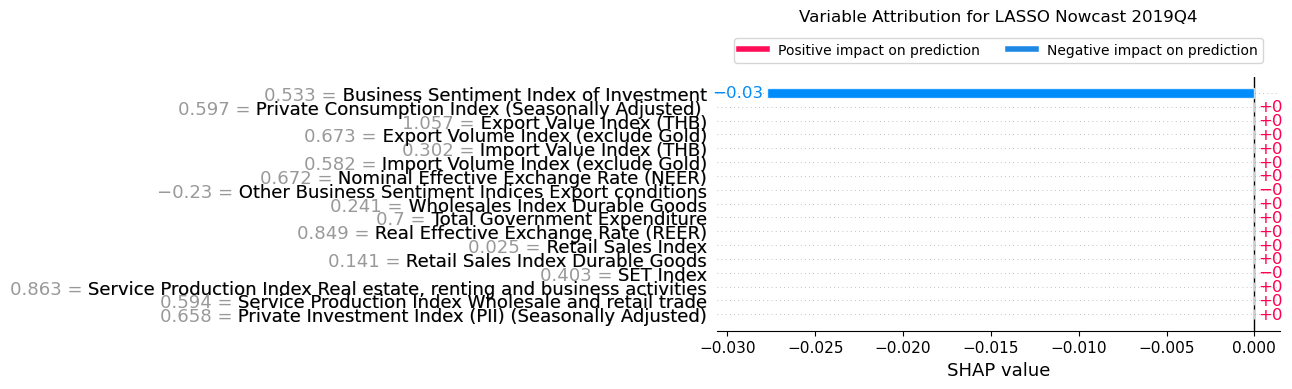

In [61]:
# === Plot LASSO SHAP summary bar ===
plot_shap_bar(shap_values = lasso_shap_vals[0], 
              expected_value = lasso_explainer.expected_value, 
              X_explain_row = X_explain[0], 
              feature_names = feature_names, 
              max_display=17, figsize=(13, 4), title="Variable Attribution for LASSO Nowcast 2019Q4", 
              save_path=None)

In [62]:
# Print LASSO SHAP df
create_shap_df(lasso_shap_vals[0], feature_names, top_n=None)

Feature  SHAP Value
0              Business Sentiment Index of Investment   -0.027761
1                 Real Effective Exchange Rate (REER)    0.000000
2                        Total Government Expenditure    0.000000
3   Service Production Index Wholesale and retail ...    0.000000
4   Service Production Index Real estate, renting ...    0.000000
5                                           SET Index   -0.000000
6                    Retail Sales Index Durable Goods    0.000000
7                                  Retail Sales Index    0.000000
8   Private Investment Index (PII) (Seasonally Adj...    0.000000
9                            Export Value Index (THB)    0.000000
10   Private Consumption Index (Seasonally Adjusted)     0.000000
11  Other Business Sentiment Indices Export condit...   -0.000000
12             Nominal Effective Exchange Rate (NEER)    0.000000
13                 Import Volume Index (exclude Gold)    0.000000
14                           Import Value Index (THB)    0.000000
15                 Export Volume Index (exclude Gold)    0.000000
16                     Wholesales Index Durable Goods    0.000000

In [63]:
# Define model scores for calculation of model agnostic interpretability scores
lasso_lais_scores = [
    {
        'variable_name': 'Service Production Index Wholesale and retail trade',
        'likert_score': 0
    },
    {
        'variable_name': 'Business Sentiment Index of Investment',
        'likert_score': 0
    },
    {
        'variable_name': 'Other Business Sentiment Indices Export conditions',
        'likert_score': 0
    },
    {
        'variable_name': 'Total Government Expenditure',
        'likert_score': 0
    },
    {
        'variable_name': 'Service Production Index Real estate, renting and business activities',
        'likert_score': 0
    },
    {
        'variable_name': 'Retail Sales Index Durable Goods',
        'likert_score': 0    },
    {
        'variable_name': 'Real Effective Exchange Rate (REER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Import Volume Index (exclude Gold)',
        'likert_score': 0
    },
    {
        'variable_name': 'SET Index',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Investment Index (PII) (Seasonally Adjusted)',
        'likert_score': 0
    },
    {
        'variable_name': 'Wholesales Index Durable Goods',
        'likert_score': 0
    },
    {
        'variable_name': 'Retail Sales Index',
        'likert_score': 0
    },
    {
        'variable_name': 'Export Volume Index (exclude Gold)',
        'likert_score': 0
    },
    {
        'variable_name': 'Nominal Effective Exchange Rate (NEER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Consumption Index (Seasonally Adjusted)',
        'likert_score': 0
    },
    {
        'variable_name': 'Export Value Index (THB)',
        'likert_score': 0
    },
    {
        'variable_name': 'Import Value Index (THB)',
        'likert_score': 0
    },
]

# Get LAIS score
lasso_lais = calculate_relative_lais(lasso_lais_scores)
print(f"Interpretability (Relative LAIS) score for LASSO nowcast for 2019Q4: {lasso_lais}")

Interpretability (Relative LAIS) score for LASSO nowcast for 2019Q4: 0.0


### Random Forest

#### Accuracy

In [64]:
# === Random Forest (Breiman, 2001) ===

from sklearn.ensemble import RandomForestRegressor


# Objective function for RF
def rf_objective(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    """
    Objective function for Bayesian Optimization of Random Forest hyperparameters.

    This function trains a Random Forest Regressor using the specified hyperparameters 
    and evaluates its performance by computing the negative root mean squared error (RMSE) 
    on a validation set. Hyperparameters are converted to integers as required.

    Parameters
    ----------
    n_estimators : float
        Number of trees in the forest (rounded to nearest integer).
    max_depth : float
        Maximum depth of each tree (rounded to nearest integer; if <= 0, depth is unlimited).
    min_samples_split : float
        Minimum number of samples required to split an internal node (rounded to nearest integer).
    min_samples_leaf : float
        Minimum number of samples required to be at a leaf node (rounded to nearest integer).

    Returns
    -------
    float
        Negative RMSE on the validation set (used for maximization in Bayesian Optimization).
    """
    # Convert hyperparameters to integer where needed
    n_estimators = int(round(n_estimators))
    max_depth = int(round(max_depth))
    min_samples_split = int(round(min_samples_split))
    min_samples_leaf = int(round(min_samples_leaf))
    
    # Initialize Random Forest model with current hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth if max_depth > 0 else None,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=False,
        random_state=42,
        n_jobs=-1  # Use all cores for faster training
    )
    
    # Train model on training data 
    model.fit(Xq_train_minmax, y_train_minmax)
    
    # Predict on validation data
    y_pred = model.predict(Xq_val_minmax)
    
    # Calculate RMSE on validation set
    rmse = np.sqrt(mean_squared_error(y_val_minmax, y_pred))
    
    # BayesianOptimization maximizes the function, so return negative RMSE
    return -rmse

# Define hyperparameter search space
pbounds_rf = {
    'n_estimators': (50, 200),       # Number of trees in the forest
    'max_depth': (2, 10),            # Maximum depth of each tree
    'min_samples_split': (2, 5),    # Minimum samples required to split a node
    'min_samples_leaf': (1, 5)       # Minimum samples required at a leaf node
}

# Initialize Bayesian optimizer for Random Forest
optimizer_rf = BayesianOptimization(
    f=rf_objective,
    pbounds=pbounds_rf,
    random_state=42,
    verbose=2  # Detailed output for each iteration
)

# Run optimization 

# Start with 5 initial random points, then 15 iterations of guided search
optimizer_rf.maximize(init_points=5, n_iter=15)

# Extract best hyperparameters
best_rf_params = optimizer_rf.max['params']

# Round integer hyperparameters explicitly
best_rf_params['n_estimators'] = int(round(best_rf_params['n_estimators']))
best_rf_params['max_depth'] = int(round(best_rf_params['max_depth']))
best_rf_params['min_samples_split'] = int(round(best_rf_params['min_samples_split']))
best_rf_params['min_samples_leaf'] = int(round(best_rf_params['min_samples_leaf']))

print("Best RF hyperparameters found via Bayesian Optimization (RMSE):")
print(best_rf_params)

# Extract best RMSE
best_rf_result = optimizer_rf.max
best_val_rmse_rf = -best_rf_result['target']
print(f"Best validation RMSE from Bayesian Optimization: {best_val_rmse_rf:.4f}")

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -0.08205  | 4.996     | 4.803     | 4.196     | 139.8     |
| 2         | -0.006838 | 3.248     | 1.624     | 2.174     | 179.9     |
| 3         | -0.04835  | 6.809     | 3.832     | 2.062     | 195.5     |
| 4         | -0.08856  | 8.66      | 1.849     | 2.545     | 77.51     |
| 5         | -0.03974  | 4.434     | 3.099     | 3.296     | 93.68     |
| 6         | -0.05385  | 4.109     | 1.566     | 2.482     | 180.0     |
| 7         | -0.04308  | 2.394     | 1.074     | 3.802     | 158.6     |
| 8         | -0.04308  | 2.036     | 1.161     | 3.399     | 102.8     |
| 9         | -0.04835  | 9.766     | 3.838     | 4.982     | 106.1     |
| 10        | -0.08846  | 5.772     | 1.642     | 4.406     | 64.48     |
| 11        | -0.006838 | 2.957     | 1.523     | 2.564     | 179.7     |
| 12        | -0.006838 | 3.449     | 

In [65]:
# Initialize final Random Forest model with optimized hyperparameters
rf_model_final = RandomForestRegressor(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    random_state=42,
    n_jobs=-1
)

# Fit model on full training set (training + validation)
rf_model_final.fit(Xq_train_full_minmax, y_train_full_minmax)

# Predict GDP growth on standardized test predictors
y_test_pred_scaled_rf = rf_model_final.predict(Xq_test_minmax)

# Inverse transform predictions to original GDP growth scale
nowcast_value_rf = scaler_y.inverse_transform(y_test_pred_scaled_rf.reshape(-1, 1)).flatten()
nowcast_rf = pd.Series([nowcast_value_lasso[0]], index=[pd.Period('2019Q4', freq='Q')], name='nowcast')

# Print Random Forest nowcast for 2019Q4
print(f"Random Forest nowcast for 2019Q4: {nowcast_rf.iloc[0]:.4f}")

Random Forest nowcast for 2019Q4: 2.7330


In [66]:
# Predict fitted values on full training data
rf_fitted_scaled = rf_model_final.predict(Xq_train_full_minmax)

# Inverse transform fitted predictions to original scale
rf_fitted_values = scaler_y.inverse_transform(rf_fitted_scaled.reshape(-1, 1)).flatten()

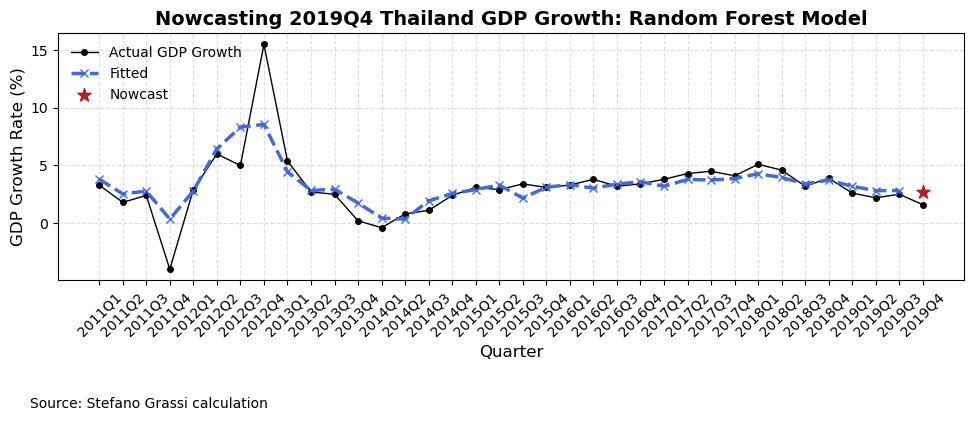

In [67]:
# Plot Random Forest Nowcast 
plot_nowcast(
    actual_dates=df_gdp['quarter'],
    actual_values=df_gdp['gdp_growth'],
    fitted_dates=y_train_full['quarter'], 
    fitted_values=rf_fitted_values,
    nowcast_date=y_test['quarter'].iloc[0],
    nowcast_value=nowcast_rf.iloc[0],
    title="Nowcasting 2019Q4 Thailand GDP Growth: Random Forest Model",
    fitted_label="Fitted",
    source="Source: Stefano Grassi calculation"
)

#### Interpretability

In [68]:
# Run SHAP explanation for Random Forest using TreeExplainer
rf_shap_vals, rf_explainer = run_shap_explanation(
    model=rf_model_final,
    X_train=Xq_train_full_minmax,
    X_explain=X_explain,
    feature_names=feature_names,
    explainer_type='tree',  # explicitly specify tree explainer for RF
)

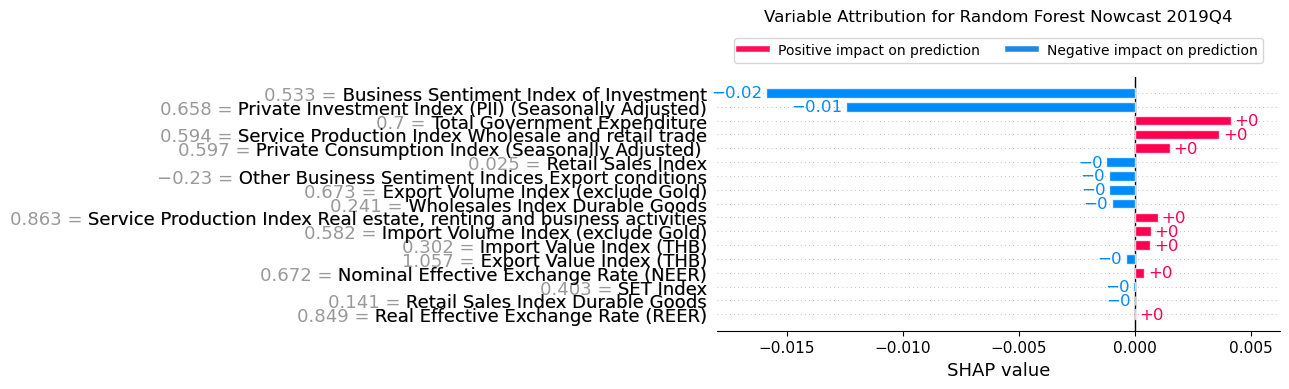

In [69]:
# === Plot RF SHAP summary bar ===
plot_shap_bar(shap_values = rf_shap_vals[0], 
              expected_value = rf_explainer.expected_value, 
              X_explain_row = X_explain[0], 
              feature_names = feature_names, 
              max_display=17, figsize=(13, 4), title="Variable Attribution for Random Forest Nowcast 2019Q4", 
              save_path=None)

In [70]:
# Print RF SHAP df
create_shap_df(rf_shap_vals[0], feature_names, top_n=None)

Feature  SHAP Value
0              Business Sentiment Index of Investment   -0.015916
1   Private Investment Index (PII) (Seasonally Adj...   -0.012459
2                        Total Government Expenditure    0.004128
3   Service Production Index Wholesale and retail ...    0.003619
4    Private Consumption Index (Seasonally Adjusted)     0.001476
5                                  Retail Sales Index   -0.001244
6   Other Business Sentiment Indices Export condit...   -0.001137
7                  Export Volume Index (exclude Gold)   -0.001127
8                      Wholesales Index Durable Goods   -0.001017
9   Service Production Index Real estate, renting ...    0.000965
10                 Import Volume Index (exclude Gold)    0.000664
11                           Import Value Index (THB)    0.000656
12                           Export Value Index (THB)   -0.000410
13             Nominal Effective Exchange Rate (NEER)    0.000387
14                                          SET Index   -0.000080
15                   Retail Sales Index Durable Goods   -0.000028
16                Real Effective Exchange Rate (REER)    0.000012

In [71]:
# Define model scores for calculation of model agnostic interpretability scores
rf_lais_scores = [
    {
        'variable_name': 'Service Production Index Wholesale and retail trade',
        'likert_score': -1
    },
    {
        'variable_name': 'Business Sentiment Index of Investment',
        'likert_score': 0
    },
    {
        'variable_name': 'Other Business Sentiment Indices Export conditions',
        'likert_score': 1
    },
    {
        'variable_name': 'Total Government Expenditure',
        'likert_score': -1
    },
    {
        'variable_name': 'Service Production Index Real estate, renting and business activities',
        'likert_score': 1
    },
    {
        'variable_name': 'Retail Sales Index Durable Goods',
        'likert_score': 1   
    },
    {
        'variable_name': 'Real Effective Exchange Rate (REER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Import Volume Index (exclude Gold)',
        'likert_score': -1
    },
    {
        'variable_name': 'SET Index',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Investment Index (PII) (Seasonally Adjusted)',
        'likert_score': 0
    },
    {
        'variable_name': 'Wholesales Index Durable Goods',
        'likert_score': 0
    },
    {
        'variable_name': 'Retail Sales Index',
        'likert_score': 1
    },
    {
        'variable_name': 'Export Volume Index (exclude Gold)',
        'likert_score': 1
    },
    {
        'variable_name': 'Nominal Effective Exchange Rate (NEER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Consumption Index (Seasonally Adjusted)',
        'likert_score': -1
    },
    {
        'variable_name': 'Export Value Index (THB)',
        'likert_score': 1
    },
    {
        'variable_name': 'Import Value Index (THB)',
        'likert_score': -1
    },
]

# Get LAIS score
rf_lais = calculate_relative_lais(rf_lais_scores)
print(f"Interpretability (Relative LAIS) score for RF nowcast for 2019Q4: {rf_lais}")

Interpretability (Relative LAIS) score for RF nowcast for 2019Q4: 0.091


### XGBoost

#### Accuracy

In [72]:
# === XGBoost (Chen & Guestrin 2016) ===

import xgboost as xgb

# Objective function for XGBoost
def xgb_objective(max_depth, learning_rate, n_estimators, subsample, colsample_bytree,
                  min_child_weight, reg_alpha, reg_lambda):
    """
    Objective function for Bayesian Optimization of XGBoost hyperparameters.

    This function fits an XGBoost regressor using the given hyperparameters and returns 
    the negative root mean squared error (RMSE) on a validation set. The negative value 
    is used to enable Bayesian Optimization, which performs maximization.

    Parameters
    ----------
    max_depth : float
        Maximum depth of each decision tree (rounded to nearest integer).
    learning_rate : float
        Boosting learning rate (shrinkage).
    n_estimators : float
        Number of boosting rounds (rounded to nearest integer).
    subsample : float
        Fraction of training samples to use for each boosting round.
    colsample_bytree : float
        Fraction of features to consider when building each tree.
    min_child_weight : float
        Minimum sum of instance weights (hessian) needed in a child node (rounded to int).
    reg_alpha : float
        L1 regularization term on weights (Lasso penalty).
    reg_lambda : float
        L2 regularization term on weights (Ridge penalty).

    Returns
    -------
    float
        Negative RMSE on the validation set.
    """
    # Round integer-valued parameters
    max_depth = int(round(max_depth))
    n_estimators = int(round(n_estimators))
    min_child_weight = int(round(min_child_weight))
    
    # Instantiate XGBoost model with trial hyperparameters
    model = xgb.XGBRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    # Fit model on training data
    model.fit(Xq_train_minmax, y_train_minmax)
    
    # Predict on validation set
    y_pred = model.predict(Xq_val_minmax)
    
    # Return negative RMSE for maximization
    rmse = mean_squared_error(y_val_minmax, y_pred)
    return -rmse

# Define hyperparameter bounds for Bayesian Optimization
pbounds_xgb = {
    'max_depth': (2, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 300),
    'subsample': (0.3, 1),
    'colsample_bytree': (0.005, 1),
    'min_child_weight': (1, 10),
    'reg_alpha': (0.001, 1),     
    'reg_lambda': (0.001, 1)    
}

# Initialize Bayesian Optimizer
optimizer_xgb = BayesianOptimization(
    f=xgb_objective,
    pbounds=pbounds_xgb,
    random_state=42,
    verbose=2
)

# Run optimization (init_points: random start, n_iter: subsequent guided search)
optimizer_xgb.maximize(init_points=5, n_iter=15)

# Extract best parameters
best_xgb_params = optimizer_xgb.max['params']
best_xgb_params['max_depth'] = int(round(best_xgb_params['max_depth']))
best_xgb_params['n_estimators'] = int(round(best_xgb_params['n_estimators']))
best_xgb_params['min_child_weight'] = int(round(best_xgb_params['min_child_weight']))

# Display best parameters
print("\nBest XGBoost hyperparameters found via Bayesian Optimization (RMSE):\n")
print(best_xgb_params)

# Extract best RMSE
best_xgb_result = optimizer_xgb.max
best_val_rmse_xgb = -best_xgb_result['target']
print(f"Best validation RMSE: {best_val_rmse_xgb:.6f}")

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -0.02851  | 0.3777    | 0.2857    | 7.856     | 6.388     | 89.0      | 0.1568    | 0.05903   | 0.9063    |
| 2         | -0.000177 | 0.6031    | 0.2153    | 2.165     | 9.729     | 258.1     | 0.2131    | 0.1826    | 0.4284    |
| 3         | -0.02039  | 0.3077    | 0.1622    | 5.456     | 3.621     | 203.0     | 0.1404    | 0.2929    | 0.5565    |
| 4         | -0.007167 | 0.4588    | 0.2377    | 3.597     | 5.628     | 198.1     | 0.0474    | 0.6079    | 0.4194    |
| 5         | -0.004328 | 0.06973   | 0.2852    | 9.725     | 8.276     | 126.2     | 0.09857   | 0.6845    | 0.6081    |
| 6         | -0.009058 | 0.142     | 0.1875    | 3.332     | 5.758     | 197.5     | 0.2987    | 0.03603   | 0.3261    |
| 7         | -0.02337  

In [73]:
# Initialize XGBoost with best parameters from Bayesian Optimization
xgb_model_final = xgb.XGBRegressor(
    max_depth=best_xgb_params['max_depth'],
    learning_rate=best_xgb_params['learning_rate'],
    n_estimators=best_xgb_params['n_estimators'],
    subsample=best_xgb_params['subsample'],
    colsample_bytree=best_xgb_params['colsample_bytree'],
    min_child_weight=best_xgb_params['min_child_weight'],
    reg_alpha=best_xgb_params['reg_alpha'],
    reg_lambda=best_xgb_params['reg_lambda'],
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Fit model on the full training set (training + validation)
xgb_model_final.fit(Xq_train_full_minmax, y_train_full_minmax)

# Predict on test data
y_test_pred_scaled_xgb = xgb_model_final.predict(Xq_test_minmax)

# Inverse transform predictions to original GDP scale
nowcast_value_xgb = scaler_y.inverse_transform(y_test_pred_scaled_xgb.reshape(-1, 1)).flatten()
nowcast_xgb = pd.Series([nowcast_value_xgb[0]], index=[pd.Period('2019Q4', freq='Q')], name='nowcast')

# Print XGBoost nowcast for 2019Q4
print(f"XGBoost nowcast for 2019Q4: {nowcast_xgb.iloc[0]:.4f}")

XGBoost nowcast for 2019Q4: 3.2528


In [74]:
# Predict on the same full training data used for fitting
y_train_fitted_scaled_xgb = xgb_model_final.predict(Xq_train_full_minmax)

# Inverse transform to original GDP growth scale
xgb_fitted_values = scaler_y.inverse_transform(y_train_fitted_scaled_xgb.reshape(-1, 1)).flatten()

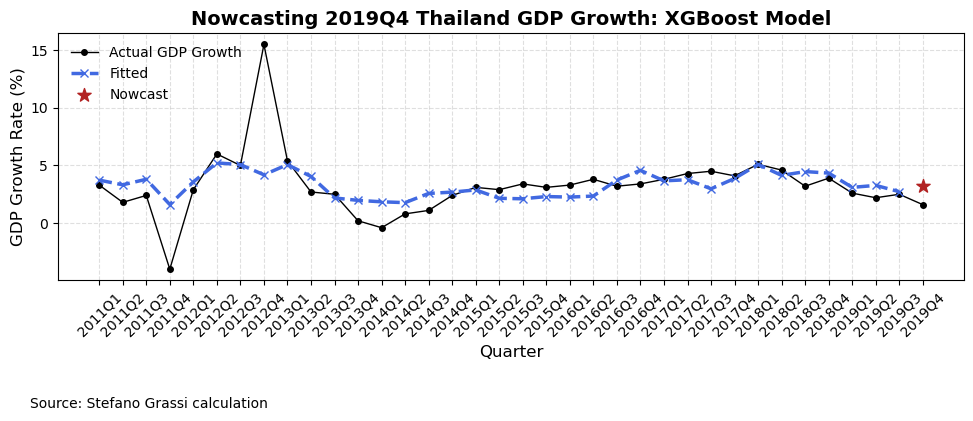

In [75]:
# Plot XGBoost Nowcast
plot_nowcast(
    actual_dates=df_gdp['quarter'],                    
    actual_values=df_gdp['gdp_growth'],                 
    fitted_dates=y_train_full['quarter'],               
    fitted_values=xgb_fitted_values,                          
    nowcast_date=y_test['quarter'].iloc[0],             
    nowcast_value=nowcast_xgb.iloc[0],                       
    title="Nowcasting 2019Q4 Thailand GDP Growth: XGBoost Model", 
    fitted_label="Fitted",                              
    source="Source: Stefano Grassi calculation" )        

#### Interpretability

In [76]:
# Run SHAP explanation for XGBoost using TreeExplainer
xgb_shap_vals, xgb_explainer = run_shap_explanation(
    model=xgb_model_final,
    X_train=Xq_train_full_minmax,
    X_explain=X_explain,
    feature_names=feature_names,
    explainer_type='tree',
)

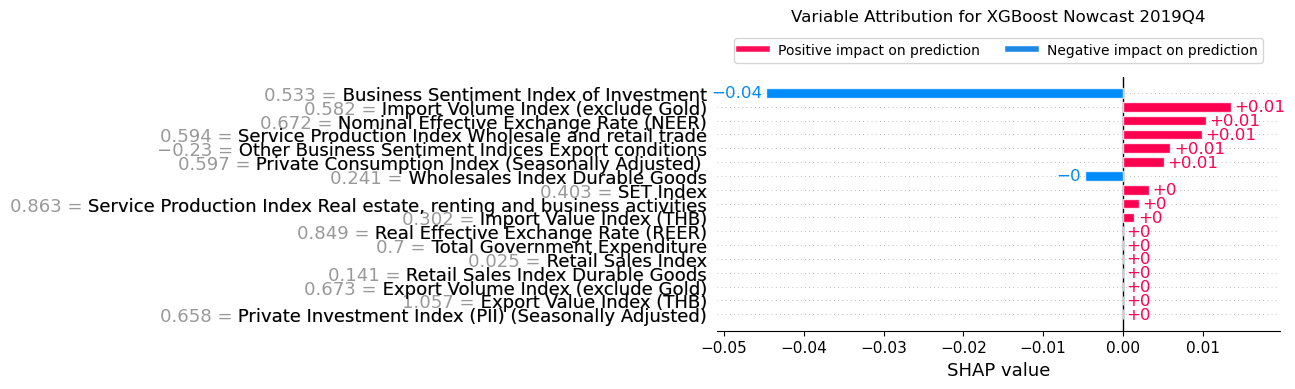

In [77]:
# === Plot XGBooost SHAP summary bar ===
plot_shap_bar(shap_values = xgb_shap_vals[0], 
              expected_value = xgb_explainer.expected_value, 
              X_explain_row = X_explain[0], 
              feature_names = feature_names, 
              max_display=17, figsize=(13, 4), title="Variable Attribution for XGBoost Nowcast 2019Q4", 
              save_path=None)

In [78]:
# Print XGBoost SHAP df
create_shap_df(xgb_shap_vals[0], feature_names, top_n=None)

Feature  SHAP Value
0              Business Sentiment Index of Investment   -0.044747
1                  Import Volume Index (exclude Gold)    0.013512
2              Nominal Effective Exchange Rate (NEER)    0.010334
3   Service Production Index Wholesale and retail ...    0.009839
4   Other Business Sentiment Indices Export condit...    0.005911
5    Private Consumption Index (Seasonally Adjusted)     0.005123
6                      Wholesales Index Durable Goods   -0.004838
7                                           SET Index    0.003255
8   Service Production Index Real estate, renting ...    0.001980
9                            Import Value Index (THB)    0.001392
10                           Export Value Index (THB)    0.000000
11                Real Effective Exchange Rate (REER)    0.000000
12                                 Retail Sales Index    0.000000
13                   Retail Sales Index Durable Goods    0.000000
14                 Export Volume Index (exclude Gold)    0.000000
15                       Total Government Expenditure    0.000000
16  Private Investment Index (PII) (Seasonally Adj...    0.000000

In [79]:
# Define model scores for calculation of model agnostic interpretability scores
xgboost_lais_scores = [
    {
        'variable_name': 'Service Production Index Wholesale and retail trade',
        'likert_score': -1
    },
    {
        'variable_name': 'Business Sentiment Index of Investment',
        'likert_score': 0
    },
    {
        'variable_name': 'Other Business Sentiment Indices Export conditions',
        'likert_score': -1
    },
    {
        'variable_name': 'Total Government Expenditure',
        'likert_score': 0
    },
    {
        'variable_name': 'Service Production Index Real estate, renting and business activities',
        'likert_score': 1
    },
    {
        'variable_name': 'Retail Sales Index Durable Goods',
        'likert_score': 0   
    },
    {
        'variable_name': 'Real Effective Exchange Rate (REER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Import Volume Index (exclude Gold)',
        'likert_score': -1
    },
    {
        'variable_name': 'SET Index',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Investment Index (PII) (Seasonally Adjusted)',
        'likert_score': 0
    },
    {
        'variable_name': 'Wholesales Index Durable Goods',
        'likert_score': 0
    },
    {
        'variable_name': 'Retail Sales Index',
        'likert_score': 0
    },
    {
        'variable_name': 'Export Volume Index (exclude Gold)',
        'likert_score': 0
    },
    {
        'variable_name': 'Nominal Effective Exchange Rate (NEER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Consumption Index (Seasonally Adjusted)',
        'likert_score': -1
    },
    {
        'variable_name': 'Export Value Index (THB)',
        'likert_score': 0
    },
    {
        'variable_name': 'Import Value Index (THB)',
        'likert_score': -1
    },
]

# Get LAIS score
xgboost_lais = calculate_relative_lais(xgboost_lais_scores)
print(f"Interpretability (Relative LAIS) score for XGboost nowcast for 2019Q4: {xgboost_lais}")


Interpretability (Relative LAIS) score for XGboost nowcast for 2019Q4: -0.667


### LightGBM

#### Accuracy

In [80]:
# === LightGBM (Ke et al. 2017) ===

import lightgbm as lgb

# Objective function for LightGBM
def lgbm_objective(num_leaves, max_depth, learning_rate, n_estimators,
                   subsample, colsample_bytree, min_child_samples,
                   reg_alpha, reg_lambda):
    """
    Objective function for Bayesian Optimization of LightGBM hyperparameters.

    This function trains a LightGBM regressor with the provided hyperparameters and 
    returns the negative root mean squared error (RMSE) on a validation set. The 
    negative sign is used because Bayesian Optimization seeks to maximize the target.

    Parameters
    ----------
    num_leaves : float
        Maximum number of leaves per tree (rounded to integer).
    max_depth : float
        Maximum depth of each tree (rounded to integer).
    learning_rate : float
        Shrinkage rate controlling the impact of each tree.
    n_estimators : float
        Number of boosting rounds (rounded to integer).
    subsample : float
        Fraction of data sampled for each boosting round.
    colsample_bytree : float
        Fraction of features randomly sampled for each tree.
    min_child_samples : float
        Minimum number of samples required to form a leaf node (rounded to integer).
    reg_alpha : float
        L1 regularization term on leaf weights.
    reg_lambda : float
        L2 regularization term on leaf weights.

    Returns
    -------
    float
        Negative RMSE on the validation set.
    """
    # Convert float hyperparameters to integer where appropriate
    num_leaves = int(round(num_leaves))
    max_depth = int(round(max_depth))
    n_estimators = int(round(n_estimators))
    min_child_samples = int(round(min_child_samples))
    
    # Define the model
    model = lgb.LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_samples=min_child_samples,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    )
    
    # Train on training set
    model.fit(Xq_train_minmax, y_train_minmax)
    
    # Predict on validation set
    y_pred = model.predict(Xq_val_minmax)
    
    # Compute negative RMSE
    rmse = mean_squared_error(y_val_minmax, y_pred)
    return -rmse

# Define hyperparameter search space
pbounds_lgbm = {
    'num_leaves': (10, 100),
    'max_depth': (3, 15),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 300),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.05, 1.0),
    'min_child_samples': (1, 50),
    'reg_alpha': (0.001, 1),
    'reg_lambda': (0.001, 1),
}

# Initialize the Bayesian Optimizer
optimizer_lgbm = BayesianOptimization(
    f=lgbm_objective,
    pbounds=pbounds_lgbm,
    random_state=42,
    verbose=2
)

# Perform the optimization
optimizer_lgbm.maximize(init_points=5, n_iter=15)

# Extract best parameters
best_lgbm_params = optimizer_lgbm.max['params']

# Round necessary parameters
best_lgbm_params['num_leaves'] = int(round(best_lgbm_params['num_leaves']))
best_lgbm_params['max_depth'] = int(round(best_lgbm_params['max_depth']))
best_lgbm_params['n_estimators'] = int(round(best_lgbm_params['n_estimators']))
best_lgbm_params['min_child_samples'] = int(round(best_lgbm_params['min_child_samples']))

# Display optimal configuration
print("\nBest LightGBM hyperparameters:\n")
for k, v in best_lgbm_params.items():
    print(f"* {k}: {v:.4f}" if isinstance(v, float) else f"* {k}: {v}")

# Extract best RMSE
best_lgbm_result = optimizer_lgbm.max
best_val_rmse_lgbm = -best_lgbm_result['target']
print(f"Best validation RMSE: {best_val_rmse_lgbm:.6f}")

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.001671 | 0.4058    | 0.2857    | 11.78     | 30.33     | 89.0      | 24.04     | 0.05903   | 0.8663    | 0.8006    |
| 2         | -0.001671 | 0.7227    | 0.01597   | 14.64     | 41.79     | 103.1     | 26.36     | 0.1842    | 0.3049    | 0.7624    |
| 3         | -0.001702 | 0.4603    | 0.09446   | 10.34     | 7.835     | 123.0     | 42.97     | 0.4566    | 0.7854    | 0.5998    |
| 4         | -0.001671 | 0.5385    | 0.1818    | 3.557     | 30.77     | 92.63     | 15.85     | 0.9489    | 0.9657    | 0.9042    |
| 5         | -0.001671 | 0.3394    | 0.03832   | 11.21     | 22.57     | 80.51     | 54.57     | 0.03535   | 0.9094    | 0.6294    |
| 6         | -0.001671 | 0.147     | 0.2212    | 6.089     | 

/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprec

| 10        | -0.001671 | 0.3512    | 0.2037    | 8.786     | 43.83     | 299.8     | 30.94     | 0.306     | 0.059     | 0.6886    |
| 11        | -0.001673 | 0.5453    | 0.07578   | 12.06     | 4.232     | 274.6     | 61.99     | 0.8721    | 0.7384    | 0.9484    |
| 12        | -0.001868 | 0.5369    | 0.264     | 3.258     | 1.269     | 51.35     | 71.48     | 0.2619    | 0.4243    | 0.5839    |
| 13        | -0.001671 | 0.7825    | 0.08193   | 14.44     | 49.9      | 88.38     | 71.44     | 0.4053    | 0.2096    | 0.5308    |


/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprec

| 14        | -0.001671 | 0.4911    | 0.01071   | 14.32     | 49.73     | 253.0     | 57.04     | 0.8555    | 0.2709    | 0.8406    |
| 15        | -0.001671 | 0.8417    | 0.2575    | 7.432     | 19.0      | 251.6     | 11.42     | 0.5819    | 0.7753    | 0.5684    |
| 16        | -0.003922 | 0.07542   | 0.1208    | 10.43     | 4.19      | 222.5     | 52.1      | 0.3192    | 0.9389    | 0.8646    |


/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprec

| 17        | -0.001561 | 0.6059    | 0.2548    | 5.864     | 1.465     | 291.9     | 15.04     | 0.6487    | 0.4745    | 0.897     |
| 18        | -0.005829 | 0.3226    | 0.05203   | 9.655     | 3.16      | 112.5     | 99.76     | 0.2633    | 0.3899    | 0.6119    |
| 19        | -0.001883 | 0.05      | 0.3       | 3.0       | 1.0       | 50.0      | 10.0      | 1.0       | 1.0       | 0.5       |
| 20        | -0.001671 | 0.5278    | 0.2437    | 7.974     | 46.63     | 167.2     | 10.03     | 0.4855    | 0.8567    | 0.7151    |

Best LightGBM hyperparameters:

* colsample_bytree: 0.6059
* learning_rate: 0.2548
* max_depth: 6
* min_child_samples: 1
* n_estimators: 292
* num_leaves: 15
* reg_alpha: 0.6487
* reg_lambda: 0.4745
* subsample: 0.8970
Best validation RMSE: 0.001561


/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [81]:
# Initialize LightGBM with best parameters from Bayesian Optimization
lgbm_model_final = lgb.LGBMRegressor(
    num_leaves=best_lgbm_params['num_leaves'],
    max_depth=best_lgbm_params['max_depth'],
    learning_rate=best_lgbm_params['learning_rate'],
    n_estimators=best_lgbm_params['n_estimators'],
    subsample=best_lgbm_params['subsample'],
    colsample_bytree=best_lgbm_params['colsample_bytree'],
    min_child_samples=best_lgbm_params['min_child_samples'],
    reg_alpha=best_lgbm_params['reg_alpha'],
    reg_lambda=best_lgbm_params['reg_lambda'],
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

# Fit model on the full training set (training + validation)
lgbm_model_final.fit(Xq_train_full_minmax, y_train_full_minmax)

# Predict on test data
y_test_pred_scaled_lgbm = lgbm_model_final.predict(Xq_test_minmax)

# Inverse transform predictions to original GDP scale
nowcast_value_lgbm = scaler_y.inverse_transform(y_test_pred_scaled_lgbm.reshape(-1, 1)).flatten()
nowcast_lgbm = pd.Series([nowcast_value_lgbm[0]], index=[pd.Period('2019Q4', freq='Q')], name='nowcast')

# Print LightGBM nowcast for 2019Q4
print(f"LightGBM nowcast for 2019Q4: {nowcast_lgbm.iloc[0]:.4f}")

LightGBM nowcast for 2019Q4: 3.5007


/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [82]:
# Predict on the same full training data used for fitting
y_train_fitted_scaled_lgbm = lgbm_model_final.predict(Xq_train_full_minmax)

# Inverse transform to original GDP growth scale
lgbm_fitted_values = scaler_y.inverse_transform(y_train_fitted_scaled_lgbm.reshape(-1, 1)).flatten()

/Users/stefanograssi/miniconda3/envs/py-ds/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


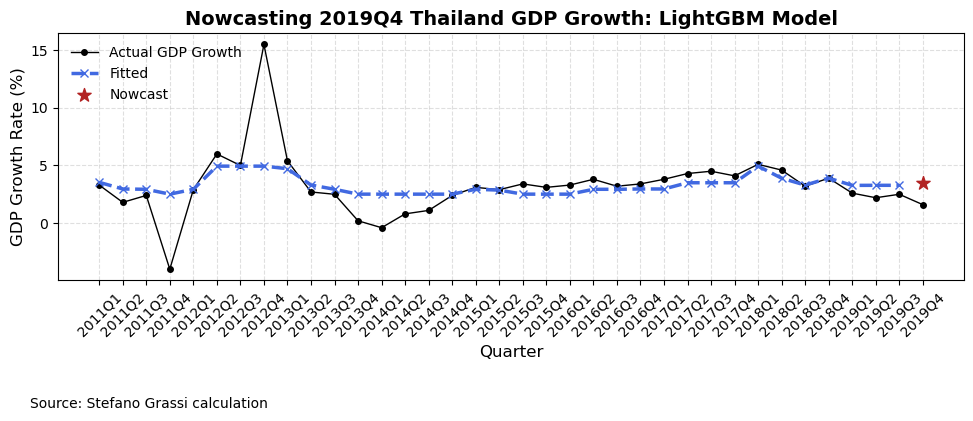

In [83]:
# Plot LightGBM Nowcast
plot_nowcast(
    actual_dates=df_gdp['quarter'],                     
    actual_values=df_gdp['gdp_growth'],               
    fitted_dates=y_train_full['quarter'],             
    fitted_values=lgbm_fitted_values,                         
    nowcast_date=y_test['quarter'].iloc[0],              
    nowcast_value=nowcast_lgbm.iloc[0],                     
    title="Nowcasting 2019Q4 Thailand GDP Growth: LightGBM Model",
    fitted_label="Fitted",
    source="Source: Stefano Grassi calculation"
)

#### Interpretability

In [84]:
# Run SHAP explanation for LightGBM using TreeExplainer
lgbm_shap_vals, lgbm_explainer = run_shap_explanation(
    model=lgbm_model_final,
    X_train=Xq_train_full_minmax,
    X_explain=X_explain,
    feature_names=feature_names,
    explainer_type='tree',  # LightGBM is tree-based
)

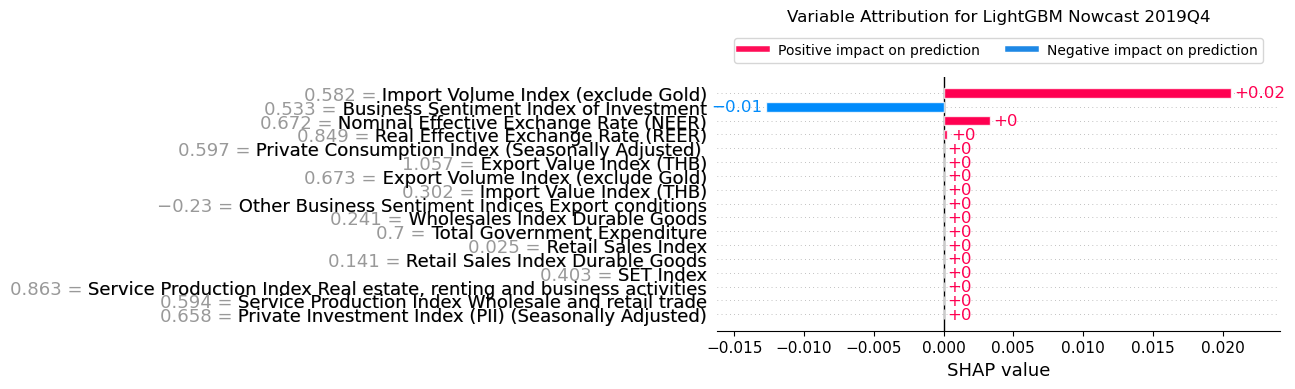

In [85]:
# === Plot LightGBM SHAP summary bar ===
plot_shap_bar(shap_values = lgbm_shap_vals[0], 
              expected_value = lgbm_explainer.expected_value, 
              X_explain_row = X_explain[0], 
              feature_names = feature_names, 
              max_display=17, figsize=(13, 4), title="Variable Attribution for LightGBM Nowcast 2019Q4", 
              save_path=None)

In [86]:
# Print LightGBM SHAP df
create_shap_df(lgbm_shap_vals[0], feature_names, top_n=None)

Feature  SHAP Value
0                  Import Volume Index (exclude Gold)    0.020605
1              Business Sentiment Index of Investment   -0.012744
2              Nominal Effective Exchange Rate (NEER)    0.003318
3                 Real Effective Exchange Rate (REER)    0.000278
4                                  Retail Sales Index    0.000000
5                        Total Government Expenditure    0.000000
6   Service Production Index Wholesale and retail ...    0.000000
7   Service Production Index Real estate, renting ...    0.000000
8                                           SET Index    0.000000
9                    Retail Sales Index Durable Goods    0.000000
10  Private Investment Index (PII) (Seasonally Adj...    0.000000
11                           Export Value Index (THB)    0.000000
12   Private Consumption Index (Seasonally Adjusted)     0.000000
13  Other Business Sentiment Indices Export condit...    0.000000
14                           Import Value Index (THB)    0.000000
15                 Export Volume Index (exclude Gold)    0.000000
16                     Wholesales Index Durable Goods    0.000000

In [87]:
# Define model scores for calculation of model agnostic interpretability scores
lightgbm_lais_scores = [
    {
        'variable_name': 'Service Production Index Wholesale and retail trade',
        'likert_score': 0
    },
    {
        'variable_name': 'Business Sentiment Index of Investment',
        'likert_score': 0
    },
    {
        'variable_name': 'Other Business Sentiment Indices Export conditions',
        'likert_score': 0
    },
    {
        'variable_name': 'Total Government Expenditure',
        'likert_score': 0
    },
    {
        'variable_name': 'Service Production Index Real estate, renting and business activities',
        'likert_score': 0
    },
    {
        'variable_name': 'Retail Sales Index Durable Goods',
        'likert_score': 0  
    },
    {
        'variable_name': 'Real Effective Exchange Rate (REER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Import Volume Index (exclude Gold)',
        'likert_score': -1
    },
    {
        'variable_name': 'SET Index',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Investment Index (PII) (Seasonally Adjusted)',
        'likert_score': 0
    },
    {
        'variable_name': 'Wholesales Index Durable Goods',
        'likert_score': 0
    },
    {
        'variable_name': 'Retail Sales Index',
        'likert_score': 0
    },
    {
        'variable_name': 'Export Volume Index (exclude Gold)',
        'likert_score': 0
    },
    {
        'variable_name': 'Nominal Effective Exchange Rate (NEER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Consumption Index (Seasonally Adjusted)',
        'likert_score': 0
    },
    {
        'variable_name': 'Export Value Index (THB)',
        'likert_score': 0
    },
    {
        'variable_name': 'Import Value Index (THB)',
        'likert_score': 0
    },
]

# Get LAIS score
lightgbm_lais = calculate_relative_lais(lightgbm_lais_scores)
print(f"Interpretability (Relative LAIS) score for LightGBM nowcast for 2019Q4: {lightgbm_lais}")

Interpretability (Relative LAIS) score for LightGBM nowcast for 2019Q4: -1.0


### Deep Learning Models

#### Recurrent Neural Network (RNN)

In [88]:
# === RNN ===

import tensorflow as tf
import random
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense, GaussianNoise
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Seed
seed = 42

# Set environment variables
os.environ['PYTHONHASHSEED'] = str(seed)        
os.environ['TF_DETERMINISTIC_OPS'] = '1'      
os.environ['OMP_NUM_THREADS'] = '1'          

# Set seeds for reproducibility
random.seed(seed)
np.random.seed(42)
tf.random.set_seed(seed)                   

class RNNNowcastModel(Model):
    """
    A custom Recurrent Neural Network (RNN) model for GDP nowcasting.

    This model supports multiple RNN cell types, including:
    - Elman RNN (ERNN) [Elman, 1990]
    - Gated Recurrent Unit (GRU) [Cho et al., 2014]
    - Long Short-Term Memory (LSTM) [Hochreiter & Schmidhuber, 1997]

    The architecture optionally stacks multiple RNN layers, applies Gaussian noise
    to inputs for regularization, and includes L2 regularization on weights.

    Parameters
    ----------
    noise_std : float
        Standard deviation of the Gaussian noise applied to inputs (for regularization).
    model_type : str
        Type of RNN cell to use: 'ERNN', 'GRU', or 'LSTM'.
    cell_dim : int
        Number of hidden units in each recurrent layer.
    initializer_std : float
        Standard deviation of the random normal initializer for weights.
    l2_reg : float
        L2 regularization coefficient applied to RNN weights.
    num_layers : int
        Number of stacked recurrent layers.
    forecast_horizon : int
        Number of time steps to forecast (e.g., 1 for nowcasting).
    seed : int, optional
        Random seed for reproducibility. Used in weight initialization.
    """

    def __init__(
        self,
        noise_std,
        model_type,
        cell_dim,
        initializer_std,
        l2_reg,
        num_layers,
        forecast_horizon,
        seed=None
    ):
        super().__init__()

        # Gaussian noise for input regularization
        self.noise_layer = GaussianNoise(noise_std)

        # Select the appropriate RNN cell type
        rnn_cell_class = {'ERNN': SimpleRNN, 'GRU': GRU, 'LSTM': LSTM}.get(model_type)
        if rnn_cell_class is None:
            raise ValueError("model_type must be one of ['ERNN', 'GRU', 'LSTM']")

        # Weight initializer
        initializer = tf.keras.initializers.RandomNormal(stddev=initializer_std, seed=seed)

        # Build RNN layers
        self.rnn_layers = [
            rnn_cell_class(
                units=cell_dim,
                activation='tanh',
                return_sequences=(i < num_layers - 1),  # Last layer returns a single output
                kernel_initializer=initializer,
                recurrent_initializer=initializer,
                kernel_regularizer=l2(l2_reg)
            )
            for i in range(num_layers)
        ]

        # Final output layer
        self.output_layer = Dense(units=forecast_horizon, activation='linear')

    def call(self, inputs, training=False):
        """
        Executes a forward pass through the RNN model.

        Applies input noise (only during training), passes data through stacked RNN layers, 
        and generates forecasts via a fully connected output layer.

        Parameters
        ----------
        inputs : tf.Tensor
            Input tensor of shape (batch_size, timesteps, features).
        training : bool, default=False
            Whether the model is in training mode. If True, Gaussian noise is applied.

        Returns
        -------
        tf.Tensor
            Output tensor of shape (batch_size, forecast_horizon).
        """
        x = self.noise_layer(inputs, training=training)
        for rnn in self.rnn_layers:
            x = rnn(x)
        output = self.output_layer(x)
        return output

In [89]:
# --- Define the function that performs hyperparameter optimization

def optimize_rnn(model_type, optimizer_name, pbounds, 
                 X_train, y_train, X_val, y_val, 
                 forecast_horizon, seed=seed):
    """
    Performs Bayesian hyperparameter optimization for a recurrent neural network (RNN)
    applied to GDP nowcasting.

    This function supports multiple RNN architectures and optimizers, and tunes 
    key hyperparameters including batch size, number of epochs, cell dimension,
    regularization strength, and learning rate.

    Supported RNN Types
    -------------------
    - 'ERNN' : Elman RNN [Elman, 1990]
    - 'GRU'  : Gated Recurrent Unit [Cho et al., 2014]
    - 'LSTM' : Long Short-Term Memory [Hochreiter & Schmidhuber, 1997]

    Supported Optimizers
    --------------------
    - 'Adam'    : Adaptive Moment Estimation [Kingma & Ba, 2015]
    - 'Adagrad' : Adaptive Gradient Algorithm [Duchi et al., 2011]

    Parameters
    ----------
    model_type : str
        Type of RNN cell to use ('ERNN', 'GRU', or 'LSTM').
    optimizer_name : str
        Name of the optimizer to use ('Adam' or 'Adagrad').
    pbounds : dict
        Dictionary defining the parameter search space for Bayesian optimization.
        The function adds optimizer-specific learning rate bounds automatically.
    X_train : np.ndarray or tf.Tensor
        Input features for the training set.
    y_train : np.ndarray or tf.Tensor
        Target values for the training set.
    X_val : np.ndarray or tf.Tensor
        Input features for the validation set.
    y_val : np.ndarray or tf.Tensor
        Target values for the validation set.
    forecast_horizon : int
        Number of time steps to forecast (typically 1 for nowcasting).
    seed : int, optional
        Random seed for reproducibility (default is global `seed`).

    Returns
    -------
    dict
        Dictionary containing the best hyperparameter configuration and corresponding
        negative validation loss. The dictionary also includes the model type and optimizer.
    """

    # Define bounds for learning rate per optimizer
    learning_rate_bounds = {
        'Adam': (0.001, 0.1),
        'Adagrad': (0.001, 0.1)
    }

    if optimizer_name not in learning_rate_bounds:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # Add optimizer-specific learning rate bounds
    pbounds['learning_rate'] = learning_rate_bounds[optimizer_name]

    def rnn_val_loss(batch_size, epochs, learning_rate, noise_std, 
                     l2_reg, cell_dim, num_layers, initializer_std):
        """
        Objective function for Bayesian Optimization.

        Builds and trains an RNN model using the given hyperparameters, then returns 
        the negative minimum validation loss. This loss guides the optimizer to select
        better hyperparameter combinations.

        Parameters
        ----------
        batch_size : float
            Training batch size (will be cast to int).
        epochs : float
            Number of training epochs (will be cast to int).
        learning_rate : float
            Learning rate for the optimizer.
        noise_std : float
            Standard deviation of Gaussian noise added to inputs.
        l2_reg : float
            L2 regularization coefficient.
        cell_dim : float
            Number of hidden units in each RNN layer (will be cast to int).
        num_layers : float
            Number of stacked RNN layers (will be cast to int).
        initializer_std : float
            Standard deviation of weight initializer.

        Returns
        -------
        float
            Negative of the minimum validation loss achieved during training.
        """

        model = RNNNowcastModel(
            noise_std=noise_std,
            model_type=model_type,
            cell_dim=int(cell_dim),
            initializer_std=initializer_std,
            l2_reg=l2_reg,
            num_layers=int(num_layers),
            forecast_horizon=forecast_horizon,
            seed=seed
        )

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer_name == 'Adagrad':
            optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)

        # Compile and fit model
        model.compile(optimizer=optimizer, loss='mse')

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=int(batch_size),
            epochs=int(epochs),
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
            verbose=0
        )

        # Return the negative of the minimum validation loss
        return -min(history.history['val_loss'])

    # Run Bayesian Optimization
    optimizer = BayesianOptimization(
        f=rnn_val_loss,
        pbounds=pbounds,
        random_state=42,
        verbose=0
    )

    optimizer.maximize(init_points=5, n_iter=10)

    # Return best result with optimizer type
    best_result = optimizer.max
    best_result['params']['optimizer'] = optimizer_name
    best_result['params']['model_type'] = model_type
    return best_result

In [90]:
# --- Define function to run RNN experiments

import math

def run_rnn_hyperparameter_optimization(
    model_types,
    learning_algorithms,
    pbounds,
    X_train,
    y_train,
    X_val,
    y_val,
    seed=42,
    forecast_horizon=1,
    int_columns=None,
    optimize_function=None
):
    """
    Run hyperparameter optimization for multiple RNN architectures and optimizers 
    using Bayesian optimization.

    This function loops over combinations of model types and optimizers, calling a user-defined 
    optimization function to search for the best hyperparameter configuration. The best 
    result per model type is retained and cleaned for further usage.

    Parameters
    ----------
    model_types : list of str
        List of RNN model types to evaluate (e.g., ['ERNN', 'GRU', 'LSTM']).
    learning_algorithms : list of str
        List of optimizers to test (e.g., ['Adam', 'Adagrad']).
    pbounds : dict
        Dictionary defining the search space (hyperparameter bounds) for Bayesian optimization.
        This is passed directly to the `optimize_function`.
    X_train : np.ndarray or tf.Tensor
        Training input features.
    y_train : np.ndarray or tf.Tensor
        Training target values.
    X_val : np.ndarray or tf.Tensor
        Validation input features.
    y_val : np.ndarray or tf.Tensor
        Validation target values.
    seed : int, optional
        Random seed for reproducibility (default is 42).
    forecast_horizon : int, optional
        Number of time steps ahead to predict (default is 1, suitable for nowcasting).
    int_columns : list of str, optional
        List of hyperparameter names that should be cast to integers after optimization.
        Default includes common discrete parameters: ['batch_size', 'cell_dim', 'epochs', 'num_layers'].
    optimize_function : callable
        The optimization function to call (e.g., `optimize_rnn`).
        Must accept the following arguments:
            - model_type: str
            - optimizer_name: str
            - pbounds: dict
            - X_train, y_train, X_val, y_val: arrays or tensors
            - seed: int
            - forecast_horizon: int

    Returns
    -------
    dict
        Dictionary mapping each model type to:
        - 'best_params': dict of best hyperparameters
        - 'best_target': float, minimum validation loss (negated)
        - 'best_optimizer': str, optimizer that yielded best result
    """

    if int_columns is None:
        int_columns = ['batch_size', 'cell_dim', 'epochs', 'num_layers']

    best_hyperparameters = {}

    for model_type in model_types:
        best_result = None
        best_optimizer = None

        for learning_algorithm in learning_algorithms:
            print(f"\nOptimizing {model_type} with {learning_algorithm}...")

            result = optimize_function(
                model_type=model_type,
                optimizer_name=learning_algorithm,
                pbounds=pbounds,
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
                seed=seed,
                forecast_horizon=forecast_horizon
            )

            # Check if this optimizer beats previous best for this model_type
            if best_result is None or result['target'] < best_result['target']:
                best_result = result
                best_optimizer = learning_algorithm

        # Clean up result params and cast integers
        if 'model_type' in best_result['params']:
            best_result['params'].pop('model_type')

        for col in int_columns:
            if col in best_result['params']:
                best_result['params'][col] = math.floor(best_result['params'][col])

        best_hyperparameters[model_type] = {
            'best_params': best_result['params'],
            'best_target': best_result['target'],
            'best_optimizer': best_optimizer
        }

        print(f"Best optimizer for {model_type}: {best_optimizer} "
              f"with validation loss = {best_result['target']:.4f}")

    return best_hyperparameters

In [91]:
# --- Define the function to retrain the RNN model with given hyperparameters

def retrain_model(model_type, hyperparams, X_full_train, y_full_train):
    """
    Retrain an RNN model with the best hyperparameters on the full training dataset.

    This function instantiates a new RNN model using the provided architecture (`model_type`)
    and hyperparameter dictionary, compiles it with the selected optimizer, and fits the 
    model on the full training data. An early stopping callback is used to prevent overfitting.

    Parameters
    ----------
    model_type : str
        Type of RNN to use, e.g. 'ERNN', 'GRU', or 'LSTM'.
    hyperparams : dict
        Dictionary of best hyperparameters, must contain the following keys:
            - 'noise_std': float, standard deviation of Gaussian noise for data augmentation.
            - 'cell_dim': int or float, dimensionality of the RNN hidden units.
            - 'initializer_std': float, standard deviation for weight initialization.
            - 'l2_reg': float, L2 regularization strength.
            - 'num_layers': int or float, number of RNN layers.
            - 'forecast_horizon': int (optional), horizon to forecast (defaults to 1 in this function).
            - 'optimizer': str, either 'Adam' or 'Adagrad'.
            - 'learning_rate': float, learning rate for optimizer.
            - 'batch_size': int or float, training batch size.
            - 'epochs': int or float, maximum number of training epochs.
    X_full_train : np.ndarray or tf.Tensor
        Full input feature array used for retraining.
    y_full_train : np.ndarray or tf.Tensor
        Full target values used for retraining.

    Returns
    -------
    model : tf.keras.Model
        Trained RNN model ready for evaluation or prediction.
    """
    
    model = RNNNowcastModel(
        noise_std=hyperparams['noise_std'],
        model_type=model_type,
        cell_dim=int(hyperparams['cell_dim']),
        initializer_std=hyperparams['initializer_std'],
        l2_reg=hyperparams['l2_reg'],
        num_layers=int(hyperparams['num_layers']),
        forecast_horizon=1,
    )

    # Build model by running a forward pass
    model(X_full_train[:1])

    # Set optimizer and compile
    if hyperparams['optimizer'] == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparams['learning_rate'])
    elif hyperparams['optimizer'] == 'Adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=hyperparams['learning_rate'])
    else:
        raise ValueError("Invalid optimizer. Choose 'Adam' or 'Adagrad'.")

    model.compile(optimizer=optimizer, loss='mse')

    # Train the model
    history = model.fit(
        X_full_train,
        y_full_train,
        batch_size=int(hyperparams['batch_size']),
        epochs=int(hyperparams['epochs']),
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)]
    )

    return model

In [92]:
# --- Define the function to generate nowcasts using the trained model 

def generate_nowcast(rnn_model, X_test):
    """
    Generate a one-step-ahead nowcast using a trained RNN model.

    This function takes the latest available input sequence from the test set 
    and uses the trained RNN model to produce a one-step-ahead forecast (nowcast) 
    for the target variable.

    Parameters
    ----------
    rnn_model : tf.keras.Model
        A trained instance of the RNNNowcastModel or any compatible Keras model.
    X_test : np.ndarray
        Input test data as a 3D array of shape (n_samples, n_timesteps, n_features).
        The function uses only the last available sample to generate the nowcast.

    Returns
    -------
    float
        The nowcasted value (scalar) for the next time step.
    """
    # Extract the last available input sequence from test set
    last_input = X_test[-1].reshape((1, X_test.shape[1], X_test.shape[2]))

    # Predict the next step
    nowcast = rnn_model.predict(last_input, verbose=0)

    # Return scalar nowcast
    return nowcast[0, 0]

In [93]:
# --- Define function to retrain the best RNN models and generate final nowcasts

def retrain_rnn_models_and_nowcast(
    model_types,
    best_hyperparams,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    retrain_function,
    forecast_function
):
    """
    Retrain RNN models using the best hyperparameters and generate final nowcasts.

    This function merges training and validation data to retrain each specified RNN 
    model type using its corresponding best hyperparameters. After retraining, it 
    uses the final model to generate a one-step-ahead nowcast from the test data.

    Parameters
    ----------
    model_types : list of str
        List of RNN architectures to retrain, e.g., ['ERNN', 'GRU', 'LSTM'].
    best_hyperparams : dict
        Dictionary containing the best hyperparameters for each model type,
        as returned from the hyperparameter optimization function.
    X_train : np.ndarray
        Feature matrix for the training set (3D array: [samples, timesteps, features]).
    y_train : np.ndarray
        Target vector for the training set.
    X_val : np.ndarray
        Feature matrix for the validation set.
    y_val : np.ndarray
        Target vector for the validation set.
    X_test : np.ndarray
        Input matrix for test data used to generate the nowcast.
    retrain_function : callable
        Function that retrains an RNN model given:
        (model_type: str, hyperparams: dict, X: np.ndarray, y: np.ndarray) → trained model.
    forecast_function : callable
        Function that generates a nowcast given:
        (trained_model, X_test) → float.

    Returns
    -------
    final_models : dict
        Dictionary mapping each model type to its trained RNN model.
    nowcasts_scaled : dict
        Dictionary mapping each model type to its corresponding nowcasted value (scaled).
    X_full_train : np.ndarray
        Combined training and validation set used to retrain the models.
    """
    # Merge training and validation data for final training
    X_full_train = np.concatenate((X_train, X_val), axis=0)
    y_full_train = np.concatenate((y_train, y_val), axis=0)

    final_models = {}
    nowcasts_scaled = {}

    for model_type in model_types:
        print(f"\nRetraining {model_type} on full dataset...")

        # Retrieve best hyperparameters
        hyperparams = best_hyperparams[model_type]['best_params']

        # Retrain model
        model =  retrain_function(model_type, hyperparams, X_full_train, y_full_train)

        # Generate nowcast
        forecast = forecast_function(model, X_test)

        # Store results
        final_models[model_type] = model
        nowcasts_scaled[model_type] = forecast

    return final_models, nowcasts_scaled, X_full_train 

In [94]:
# --- Define function to generate fitted values for each RNN model 

def generate_fitted_values_rnn(final_models, X_full_train, scaler_y, df_gdp, model_types):
    """
    Generate fitted values on the training data for each trained RNN model, 
    and transform them back to the original GDP scale.

    This function uses the trained RNN models to predict fitted values on the full 
    training dataset (`X_full_train`), then applies the inverse scaling to convert 
    predictions from the normalized scale back to the original GDP scale. It aligns 
    these fitted values with the corresponding quarters from the GDP DataFrame 
    (excluding the forecast quarter) and returns them as DataFrames indexed by 
    quarterly periods.

    Parameters
    ----------
    final_models : dict
        Dictionary of trained RNN models, keyed by model type 
        (e.g., {'ERNN': model1, 'GRU': model2, 'LSTM': model3}).
    X_full_train : np.ndarray
        Input feature array used for training and generating fitted values 
        (shape: [samples, timesteps, features]).
    scaler_y : sklearn.preprocessing.StandardScaler or similar object
        Fitted scaler instance used for target variable scaling, to perform 
        inverse transformation of predictions.
    df_gdp : pandas.DataFrame
        DataFrame containing the GDP data including a 'quarter' column 
        (e.g., PeriodIndex or datetime-like), used to align fitted predictions 
        with their corresponding time periods.
    model_types : list of str
        List of model type names to process (e.g., ['ERNN', 'GRU', 'LSTM']).

    Returns
    -------
    fitted_values_rnn : dict
        Dictionary where keys are model types and values are pandas DataFrames 
        containing the fitted values in original GDP scale. Each DataFrame has a 
        'fitted' column indexed by quarterly periods aligned with `df_gdp`, excluding 
        the forecast quarter.
    """
    fitted_values_rnn = {}

    for model_type in model_types:
        model = final_models[model_type]
        fitted_scaled = model.predict(X_full_train)
        fitted_original = scaler_y.inverse_transform(fitted_scaled).flatten()

        # Align with quarters: exclude forecast quarter
        fitted_index = df_gdp['quarter'].iloc[-len(fitted_original)-1:-1].reset_index(drop=True)
        fitted_values_rnn[model_type] = pd.DataFrame(
            {'fitted': fitted_original},
            index=pd.PeriodIndex(fitted_index, freq='Q')
        )

    return fitted_values_rnn

#### RNN-MF (Mixed frequency)

##### Accuracy

In [95]:
#--- Define Moving Window Strategy for RNN-MF

def create_multivariate_patches_mixed_frequency(X_monthly, y_quarterly, m):
    """
    Generate multivariate input-output pairs for RNN models using a moving window approach
    on mixed-frequency data (monthly inputs with quarterly targets).

    This function slices the monthly input data into overlapping windows of length `m` months, 
    each window aligned to predict the corresponding quarterly target. Typically, `m=3` to align 
    three months per quarter.

    Parameters
    ----------
    X_monthly : np.ndarray, shape (time_steps_monthly, n_features)
        Preprocessed and standardized monthly feature matrix.
    y_quarterly : np.ndarray, shape (n_quarters,)
        Quarterly target values aligned with the last month of each quarter 
        (e.g., targets correspond to March, June, September, December).
    m : int
        Window length in months for each sample (usually 3 for quarterly aggregation).

    Returns
    -------
    X_train : np.ndarray, shape (n_samples - 1, m, n_features)
        Training input sequences formed by sliding windows of monthly data, excluding the last quarter.
    y_train : np.ndarray, shape (n_samples - 1,)
        Training targets corresponding to each input window. 
    X_val : np.ndarray, shape (1, m, n_features)
        Validation input sequence representing the most recent quarter.  
    y_val : np.ndarray, shape (1,)
        Validation target corresponding to the last quarter.

    Raises
    ------
    ValueError
        If the data is insufficient to create at least one training and one validation sample 
        (i.e., fewer than 2 quarters available).

    Notes
    -----
    - The number of available quarterly samples is the minimum of the length of `y_quarterly` 
      and the number of complete `m`-month windows in `X_monthly`.
    - This function assumes that the inputs are properly aligned in time and preprocessed.
    """
    X_out, y_out = [], []

    # Determine how many complete quarters (m-month windows) can be extracted
    n_quarters = min(len(y_quarterly), len(X_monthly) // m)

    for i in range(n_quarters):
        start_idx = i * m
        end_idx = start_idx + m
        X_out.append(X_monthly[start_idx:end_idx])
        y_out.append(y_quarterly[i])

    X_out = np.array(X_out)
    y_out = np.array(y_out)

    if len(X_out) < 2:
        raise ValueError("Not enough data to create at least 1 training and 1 validation sample.")

    # Use the last sample for validation
    X_train = X_out[:-1]
    y_train = y_out[:-1]
    X_val = X_out[-1:]
    y_val = y_out[-1:]

    return X_train, y_train, X_val, y_val

In [96]:
# Reshape X_test (samples, timesteps, features)
X_test_mf = Xm_test_minmax.reshape(1, Xm_test_minmax.shape[0], Xm_test_minmax.shape[1])

In [97]:
# Define m
m = 3  # months per quarter

# Get train and validation patches
X_train_patch_mf, y_train_patch_mf, X_val_patch_mf, y_val_patch_mf = create_multivariate_patches_mixed_frequency(
    Xm_train_minmax, y_train_full_minmax, m
)

# Print patches for verification purpose
print(f"Train X shape: {X_train_patch_mf.shape}, Train y shape: {y_train_patch_mf.shape}")
print(f"Val X shape: {X_val_patch_mf.shape}, Val y shape: {y_val_patch_mf.shape}")

Train X shape: (33, 3, 17), Train y shape: (33,)
Val X shape: (1, 3, 17), Val y shape: (1,)


In [98]:
# Define models
model_types = ['ERNN', 'GRU', 'LSTM']

# Define the hyperparameter bounds for Bayesian Optimization
pbounds = {
    'batch_size': (5, 90),            
    'epochs': (30, 100),               
    'learning_rate': None,             
    'noise_std': (0.0, 0.3),            
    'l2_reg': (1e-6, 1e-2),             
    'cell_dim': (8, 128),              
    'num_layers': (1, 2),               
    'initializer_std': (0.001, 0.2)     
}

# --- Run RNN Experiments for Mixed-Frequency Nowcasting

best_hyperparams_mf = run_rnn_hyperparameter_optimization(
    model_types=model_types,
    learning_algorithms=['Adam', 'Adagrad'],
    pbounds=pbounds,
    X_train=X_train_patch_mf,
    y_train=y_train_patch_mf,
    X_val=X_val_patch_mf,
    y_val=y_val_patch_mf,
    seed=42,
    forecast_horizon=1,
    int_columns=['batch_size', 'cell_dim', 'epochs', 'num_layers'],
    optimize_function=optimize_rnn 
)


Optimizing ERNN with Adam...


2025-09-09 11:21:54.644892: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-09 11:21:54.645083: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Optimizing ERNN with Adagrad...


2025-09-09 11:22:05.057863: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-09 11:22:05.058036: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Best optimizer for ERNN: Adam with validation loss = -0.0036

Optimizing GRU with Adam...


2025-09-09 11:22:15.414756: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-09 11:22:15.415166: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Optimizing GRU with Adagrad...


2025-09-09 11:22:25.777491: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-09 11:22:25.777684: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Best optimizer for GRU: Adam with validation loss = -0.0074

Optimizing LSTM with Adam...


2025-09-09 11:22:36.321989: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-09 11:22:36.322174: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Optimizing LSTM with Adagrad...


2025-09-09 11:22:51.765689: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-09 11:22:51.766109: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Best optimizer for LSTM: Adam with validation loss = -0.0089


In [99]:
# --- Display the best hyperparameters for each model type ---

from IPython.display import HTML, display

# Build data list
data = []
for model_type, info in best_hyperparams_mf.items():
    params = info['best_params'].copy()
    
    row = {
        'Model Type': model_type,
        'Target Loss': info['best_target'],
        **params
    }
    data.append(row)

# Create DataFrame
best_hyperparam_df = pd.DataFrame(data)

# Convert all column names to strings (to avoid .str accessor error)
best_hyperparam_df.columns = best_hyperparam_df.columns.astype(str)

# Replace underscores with spaces and capitalize
best_hyperparam_df.columns = best_hyperparam_df.columns.str.replace('_', ' ').str.title()

# Generate HTML table with bootstrap classes
table_1 = best_hyperparam_df.to_html(classes='table table-striped', escape=False, index=False)

# Display the table
display(HTML(table_1))

In [100]:
# --- Retrain the best RNN models and generate nowcasts ---

final_rnn_models_mf, nowcasts_scaled_rnn_mf, X_full_train_patch_mf = retrain_rnn_models_and_nowcast(
    model_types=model_types,
    best_hyperparams=best_hyperparams_mf,
    X_train=X_train_patch_mf,
    y_train=y_train_patch_mf,
    X_val=X_val_patch_mf,
    y_val=y_val_patch_mf,
    X_test=X_test_mf,
    retrain_function=retrain_model,
    forecast_function=generate_nowcast
)


Retraining ERNN on full dataset...

Retraining GRU on full dataset...

Retraining LSTM on full dataset...


In [101]:
# Parse the last observed quarter from the GDP dataset (e.g., '2019Q4')
last_quarter_str = df_gdp['quarter'].iloc[-1]
last_quarter = pd.Period(last_quarter_str, freq='Q')

# Initialize dictionary to store nowcast results for each RNN model
nowcast_rnn_mf = {}

# Loop over each RNN model architecture to invert scaling and store nowcast
for model_type in model_types:
    # Extract the scalar scaled nowcast for the current model
    nowcast_scaled_scalar = nowcasts_scaled_rnn_mf[model_type]
    
    # Convert scalar to 2D array shape (1,1) as required by inverse_transform
    nowcast_scaled = np.array([[nowcast_scaled_scalar]])
    
    # Invert MinMax scaling to get nowcast in original GDP units
    nowcast_value = scaler_y.inverse_transform(nowcast_scaled).flatten()[0]
    
    # Store nowcast as a one-row DataFrame with the proper quarter as index
    nowcast_rnn_mf[model_type] = pd.DataFrame(
        {'nowcast': [nowcast_value]},
        index=[last_quarter]         
    )
    
    # Print the nowcast result for the current model and quarter
    print(f"{model_type} nowcast for {last_quarter}: {nowcast_value:.4f}")

ERNN nowcast for 2019Q4: 2.5504
GRU nowcast for 2019Q4: 7.7939
LSTM nowcast for 2019Q4: 2.5142


In [102]:
# --- Generate fitted values for each RNN model ---

fitted_values_rnn_mf = generate_fitted_values_rnn(
    final_models=final_rnn_models_mf,
    X_full_train=X_full_train_patch_mf,
    scaler_y=scaler_y,
    df_gdp=df_gdp,
    model_types=model_types
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


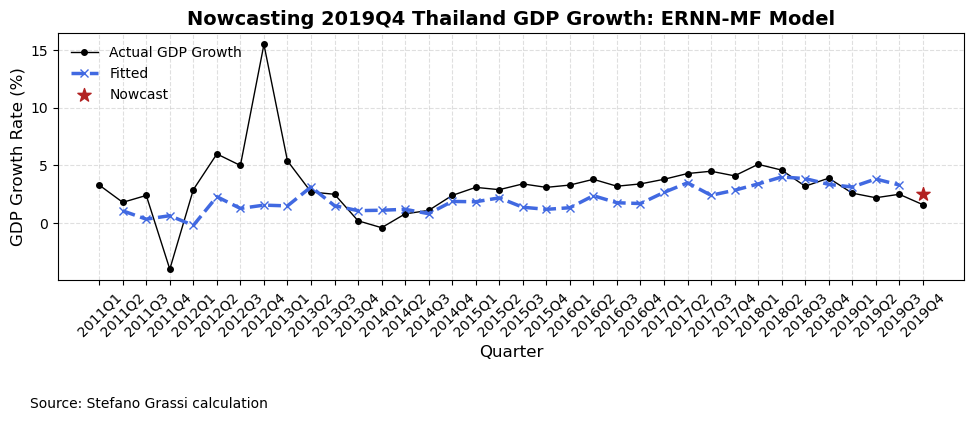

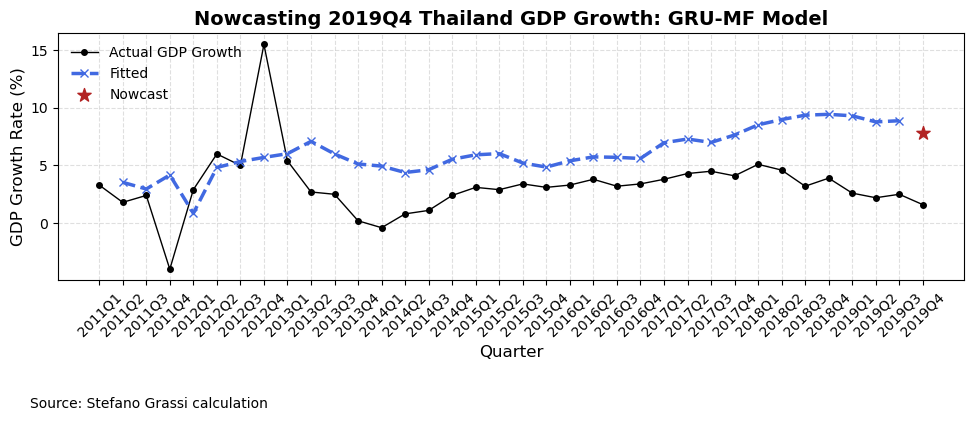

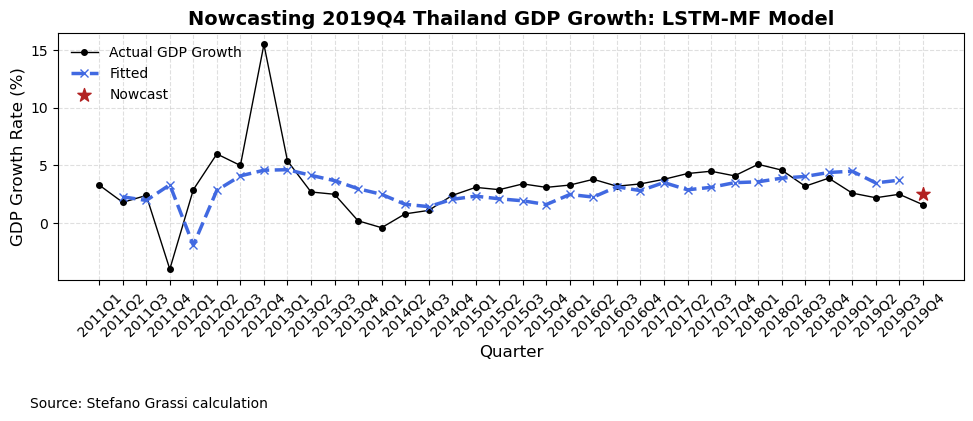

In [103]:
# --- Plot Nowcasts for each RNN-MF Model ---

for model_type in model_types:
    # Extract fitted values DataFrame and convert index (PeriodIndex) to string for plotting
    fitted_df = fitted_values_rnn_mf[model_type]
    fitted_dates = fitted_df.index.astype(str)  # convert PeriodIndex to string like '2019Q1'
    fitted_values = fitted_df['fitted'].values

    # Extract nowcast value and date from nowcast_rnn (updated variable)
    nowcast_value = nowcast_rnn_mf[model_type]['nowcast'].values[0]
    nowcast_date = nowcast_rnn_mf[model_type].index[0].strftime('%YQ%q')  # format Period to e.g. '2019Q4'

    # Plot the nowcast alongside actual and fitted values
    plot_nowcast(
        actual_dates=df_gdp['quarter'],       
        actual_values=df_gdp['gdp_growth'], 
        fitted_dates=fitted_dates,              
        fitted_values=fitted_values,           
        nowcast_date=nowcast_date,            
        nowcast_value=nowcast_value,           
        title=f"Nowcasting {nowcast_date} Thailand GDP Growth: {model_type}-MF Model",
        fitted_label="Fitted",
        source="Source: Stefano Grassi calculation"
    )

##### Interpretability

In [104]:
#==== Interpretability ====
# === Gradient x Input integration (Shrikumar et al. 2017) ===

def compute_gradients_times_inputs(model, input_sequence, output_neuron=0):
    """
    Compute Gradient × Input attributions for a specific output neuron given an input sequence.

    This method uses TensorFlow's automatic differentiation to compute the gradient
    of the selected output neuron with respect to the input features, then multiplies
    element-wise by the input itself to obtain attributions per timestep and feature.

    Parameters
    ----------
    model : tf.keras.Model
        Trained TensorFlow/Keras model.
    input_sequence : np.ndarray, shape (1, timesteps, features)
        Input data for which to compute attributions. Batch size must be 1.
    output_neuron : int, optional
        Index of the output neuron to explain (default is 0).

    Returns
    -------
    np.ndarray, shape (timesteps, features)
        Attribution values representing Gradient × Input at each timestep and feature.
    """
    # Convert input to TensorFlow tensor with float32 dtype
    input_tf = tf.convert_to_tensor(input_sequence, dtype=tf.float32)

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        tape.watch(input_tf)  # Ensure gradients are tracked w.r.t. input
        preds = model(input_tf)  # Forward pass
        output = preds[:, output_neuron]  # Select output neuron to explain

    # Compute gradients of output neuron w.r.t input
    grads = tape.gradient(output, input_tf).numpy()[0]  # Shape: (timesteps, features)
    inputs_np = input_sequence[0]  # Original input shape: (timesteps, features)

    # Element-wise multiply gradients by inputs to get attribution scores
    grads_times_inputs = grads * inputs_np
    return grads_times_inputs


def aggregate_feature_contributions(grads_times_inputs, feature_names):
    """
    Aggregate Gradient × Input attributions over all timesteps for each feature,
    separating positive and negative contributions.

    Parameters
    ----------
    grads_times_inputs : np.ndarray, shape (timesteps, features)
        Attribution matrix of Gradient × Input values.
    feature_names : list of str
        Names of the features corresponding to columns in the attribution matrix.

    Returns
    -------
    pd.DataFrame
        DataFrame indexed by feature name containing:
        - 'positive': sum of positive contributions per feature
        - 'negative': sum of absolute value of negative contributions per feature
        - 'total_abs': sum of absolute contributions (positive + negative)
        Sorted ascending by 'total_abs' for visualization convenience.
    """
    # Sum contributions over all timesteps to get total per feature
    summed_attributions = np.sum(grads_times_inputs, axis=0)

    # Separate positive contributions (keep positives, zero out negatives)
    pos_contrib = np.clip(summed_attributions, a_min=0, a_max=None)

    # Separate negative contributions (keep negatives, zero out positives)
    neg_contrib = np.clip(summed_attributions, a_max=0, a_min=None)

    # Convert negative values to positive for visualization
    neg_contrib_abs = -neg_contrib

    # Construct DataFrame with positive, negative, and total absolute contributions
    df = pd.DataFrame({
        'feature': feature_names,
        'positive': pos_contrib,
        'negative': neg_contrib_abs
    })
    df['total_abs'] = df['positive'] + df['negative']

    # Sort features by total absolute contribution ascending for plotting
    df = df.sort_values('total_abs', ascending=True)
    return df


def plot_feature_attributions(df_contrib, title="Feature Attribution", figsize=(10, 8), save_path=None, show=True):
    """
    Plot horizontal bar chart of positive and negative feature attributions,
    optionally saving the plot to a file.

    Parameters
    ----------
    df_contrib : pd.DataFrame
        DataFrame with columns 'feature', 'positive', and 'negative' containing attribution scores.
    title : str, optional
        Title of the plot (default "Feature Attribution").
    figsize : tuple of int, optional
        Size of the matplotlib figure (default (10, 8)).
    save_path : str or None, optional
        File path to save the figure. If None, the figure is not saved.
    show : bool, optional
        Whether to display the plot.
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Plot positive contributions (red)
    ax.barh(df_contrib['feature'], df_contrib['positive'], color='#FF0034', label='Positive contribution')

    # Plot negative contributions (blue, extending left)
    ax.barh(df_contrib['feature'], -df_contrib['negative'], color='#008BFB', label='Negative contribution')

    ax.set_xlabel('Aggregated Gradient × Input')
    ax.set_title(title, pad=40)
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.18),
        ncol=2,
        frameon=True
    )
    ax.grid(axis='both', linestyle='--', alpha=0.5)

    # Annotate bars with numerical contribution values
    for i, (pos, neg) in enumerate(zip(df_contrib['positive'], df_contrib['negative'])):
        if pos > 0:
            ax.text(pos, i, f"{pos:.3f}", va='center', ha='left', color='#FF0034', fontsize=9)
        if neg > 0:
            ax.text(-neg, i, f"-{neg:.3f}", va='center', ha='right', color='#008BFB', fontsize=9)

    plt.tight_layout()

    # Save figure if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    # Show or close plot
    if show:
        plt.show()
    else:
        plt.close(fig)


def explain_and_plot_nowcast(model, input_sequence, feature_names, output_neuron=0, plot_title=None, 
                             figsize=(10, 8), save_path=None, show=True):
    """
    Compute Gradient × Input attributions and visualize feature importance for a nowcast.

    Runs the full interpretability pipeline: computing attributions, aggregating over time,
    and plotting the positive and negative contributions of each feature.

    Parameters
    ----------
    model : tf.keras.Model
        Trained TensorFlow/Keras model.
    input_sequence : np.ndarray, shape (1, timesteps, features)
        Single input sequence for which to compute attributions.
    feature_names : list of str
        Names of the input features.
    output_neuron : int, optional
        Index of the output neuron to explain (default 0).
    plot_title : str or None, optional
        Title for the attribution plot. If None, a default title is generated.
    figsize : tuple of int, optional
        Size of the matplotlib figure (default (10, 8)).
    save_path : str or None, optional
        File path to save the figure. If None, the figure is not saved.
    show : bool, optional
        Whether to display the plot.
    """
    # Compute attributions using Gradient × Input method
    attributions = compute_gradients_times_inputs(model, input_sequence, output_neuron)

    # Aggregate attributions over time per feature, separate positive/negative
    df_contrib = aggregate_feature_contributions(attributions, feature_names)

    # Use default plot title if none provided
    if plot_title is None:
        plot_title = "Feature Attribution for Nowcast (Aggregated over time steps)"

    # Plot the feature attribution bar chart
    plot_feature_attributions(df_contrib, title=plot_title, figsize=figsize, save_path=save_path, show=show)

    # Create the final DataFrame with the desired format
    final_df_contrib = pd.DataFrame({
        'Feature': df_contrib['feature'],
        'Gradient x Input Value': df_contrib['positive'] - df_contrib['negative']
    })
    
    # Sort and reset index for clean output
    final_df_contrib['Absolute Value'] = final_df_contrib['Gradient x Input Value'].abs()
    final_df_contrib = final_df_contrib.sort_values(by='Absolute Value', 
                                                    ascending=False).drop(columns='Absolute Value')
    final_df_contrib = final_df_contrib.reset_index(drop=True)
    
    return final_df_contrib

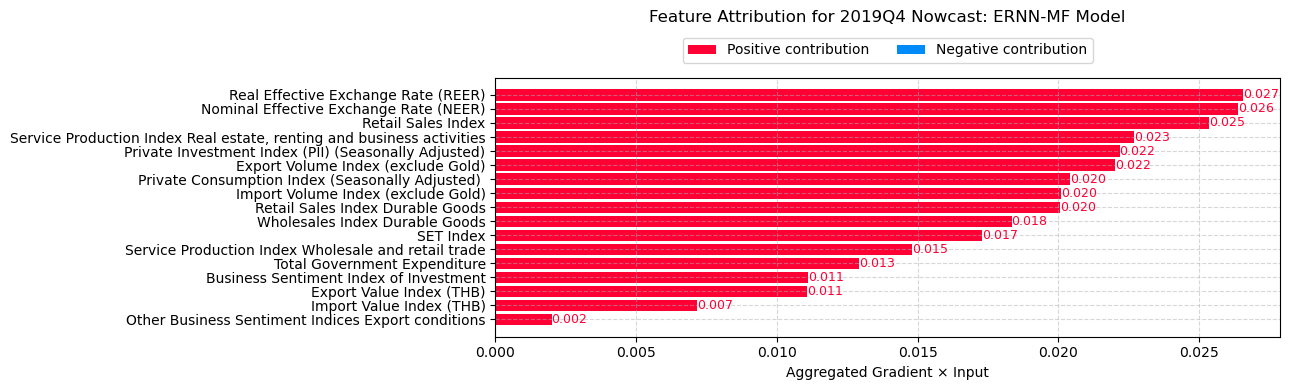

In [105]:
# === Plot ERNN-MF Gradient x Input summary bar ===
ernnmf_contrib = explain_and_plot_nowcast(
    model=final_rnn_models_mf["ERNN"],
    input_sequence=X_test_mf,
    feature_names=feature_names,
    output_neuron=0,
    plot_title="Feature Attribution for 2019Q4 Nowcast: ERNN-MF Model",
    figsize=(13, 4),
    save_path=None
)

In [106]:
# Print ERNN-MF Contributions df
ernnmf_contrib

Feature  Gradient x Input Value
0                 Real Effective Exchange Rate (REER)                0.026541
1              Nominal Effective Exchange Rate (NEER)                0.026365
2                                  Retail Sales Index                0.025336
3   Service Production Index Real estate, renting ...                0.022670
4   Private Investment Index (PII) (Seasonally Adj...                0.022169
5                  Export Volume Index (exclude Gold)                0.022001
6    Private Consumption Index (Seasonally Adjusted)                 0.020406
7                  Import Volume Index (exclude Gold)                0.020079
8                    Retail Sales Index Durable Goods                0.020043
9                      Wholesales Index Durable Goods                0.018335
10                                          SET Index                0.017283
11  Service Production Index Wholesale and retail ...                0.014793
12                       Total Government Expenditure                0.012931
13             Business Sentiment Index of Investment                0.011098
14                           Export Value Index (THB)                0.011065
15                           Import Value Index (THB)                0.007177
16  Other Business Sentiment Indices Export condit...                0.001994

In [107]:
# Define model scores for calculation of model agnostic interpretability scores
ernnmf_lais_scores = [
    {
        'variable_name': 'Service Production Index Wholesale and retail trade',
        'likert_score': -1
    },
    {
        'variable_name': 'Business Sentiment Index of Investment',
        'likert_score': 0
    },
    {
        'variable_name': 'Other Business Sentiment Indices Export conditions',
        'likert_score': -1
    },
    {
        'variable_name': 'Total Government Expenditure',
        'likert_score': -1
    },
    {
        'variable_name': 'Service Production Index Real estate, renting and business activities',
        'likert_score': 1
    },
    {
        'variable_name': 'Retail Sales Index Durable Goods',
        'likert_score': -1   
    },
    {
        'variable_name': 'Real Effective Exchange Rate (REER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Import Volume Index (exclude Gold)',
        'likert_score': -1
    },
    {
        'variable_name': 'SET Index',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Investment Index (PII) (Seasonally Adjusted)',
        'likert_score': 0
    },
    {
        'variable_name': 'Wholesales Index Durable Goods',
        'likert_score': 0
    },
    {
        'variable_name': 'Retail Sales Index',
        'likert_score': -1
    },
    {
        'variable_name': 'Export Volume Index (exclude Gold)',
        'likert_score': -1
    },
    {
        'variable_name': 'Nominal Effective Exchange Rate (NEER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Consumption Index (Seasonally Adjusted)',
        'likert_score': -1
    },
    {
        'variable_name': 'Export Value Index (THB)',
        'likert_score': -1
    },
    {
        'variable_name': 'Import Value Index (THB)',
        'likert_score': -1
    },
]

# Get LAIS score
ernnmf_lais = calculate_relative_lais(ernnmf_lais_scores)
print(f"Interpretability (Relative LAIS) score for ERNN-MF nowcast for 2019Q4: {ernnmf_lais}")

Interpretability (Relative LAIS) score for ERNN-MF nowcast for 2019Q4: -0.818


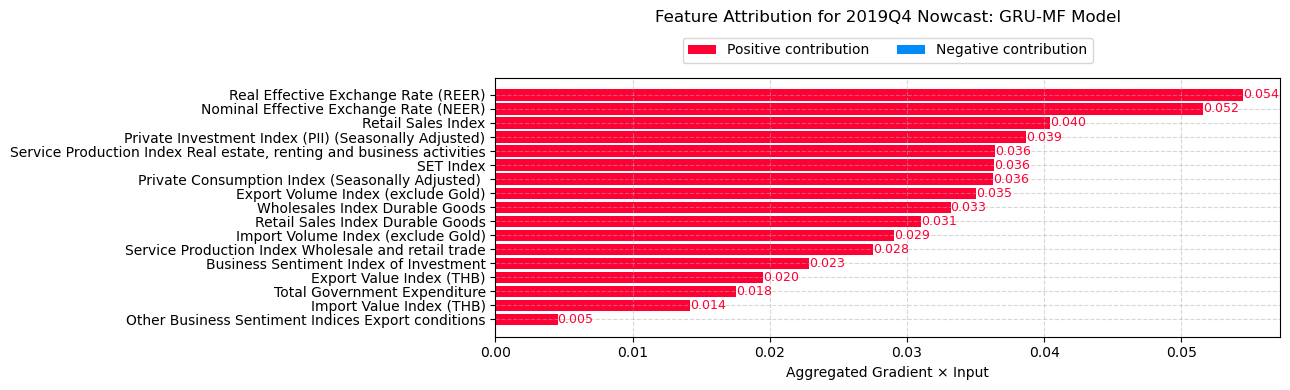

In [108]:
# === Plot GRU-MF Gradient x Input summary bar ===
grumf_contrib = explain_and_plot_nowcast(
    model=final_rnn_models_mf["GRU"],
    input_sequence=X_test_mf,
    feature_names=feature_names,
    output_neuron=0,
    plot_title="Feature Attribution for 2019Q4 Nowcast: GRU-MF Model",
    figsize=(13, 4),
    save_path=None
)

In [109]:
# Print GRU-MF Contributions df
grumf_contrib

Feature  Gradient x Input Value
0                 Real Effective Exchange Rate (REER)                0.054467
1              Nominal Effective Exchange Rate (NEER)                0.051597
2                                  Retail Sales Index                0.040449
3   Private Investment Index (PII) (Seasonally Adj...                0.038700
4   Service Production Index Real estate, renting ...                0.036419
5                                           SET Index                0.036375
6    Private Consumption Index (Seasonally Adjusted)                 0.036304
7                  Export Volume Index (exclude Gold)                0.035056
8                      Wholesales Index Durable Goods                0.033176
9                    Retail Sales Index Durable Goods                0.031045
10                 Import Volume Index (exclude Gold)                0.029074
11  Service Production Index Wholesale and retail ...                0.027515
12             Business Sentiment Index of Investment                0.022884
13                           Export Value Index (THB)                0.019512
14                       Total Government Expenditure                0.017551
15                           Import Value Index (THB)                0.014212
16  Other Business Sentiment Indices Export condit...                0.004538

In [110]:
# Define model scores for calculation of model agnostic interpretability scores
grumf_lais_scores = [
    {
        'variable_name': 'Service Production Index Wholesale and retail trade',
        'likert_score': -1
    },
    {
        'variable_name': 'Business Sentiment Index of Investment',
        'likert_score': 0
    },
    {
        'variable_name': 'Other Business Sentiment Indices Export conditions',
        'likert_score': -1
    },
    {
        'variable_name': 'Total Government Expenditure',
        'likert_score': -1
    },
    {
        'variable_name': 'Service Production Index Real estate, renting and business activities',
        'likert_score': 1
    },
    {
        'variable_name': 'Retail Sales Index Durable Goods',
        'likert_score': -1   
    },
    {
        'variable_name': 'Real Effective Exchange Rate (REER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Import Volume Index (exclude Gold)',
        'likert_score': -1
    },
    {
        'variable_name': 'SET Index',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Investment Index (PII) (Seasonally Adjusted)',
        'likert_score': 0
    },
    {
        'variable_name': 'Wholesales Index Durable Goods',
        'likert_score': 0
    },
    {
        'variable_name': 'Retail Sales Index',
        'likert_score': -1
    },
    {
        'variable_name': 'Export Volume Index (exclude Gold)',
        'likert_score': -1
    },
    {
        'variable_name': 'Nominal Effective Exchange Rate (NEER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Consumption Index (Seasonally Adjusted)',
        'likert_score': -1
    },
    {
        'variable_name': 'Export Value Index (THB)',
        'likert_score': -1
    },
    {
        'variable_name': 'Import Value Index (THB)',
        'likert_score': -1
    },
]

# Get LAIS score
grumf_lais = calculate_relative_lais(grumf_lais_scores)
print(f"Interpretability (Relative LAIS) score for GRU-MF nowcast for 2019Q4: {grumf_lais}")

Interpretability (Relative LAIS) score for GRU-MF nowcast for 2019Q4: -0.818


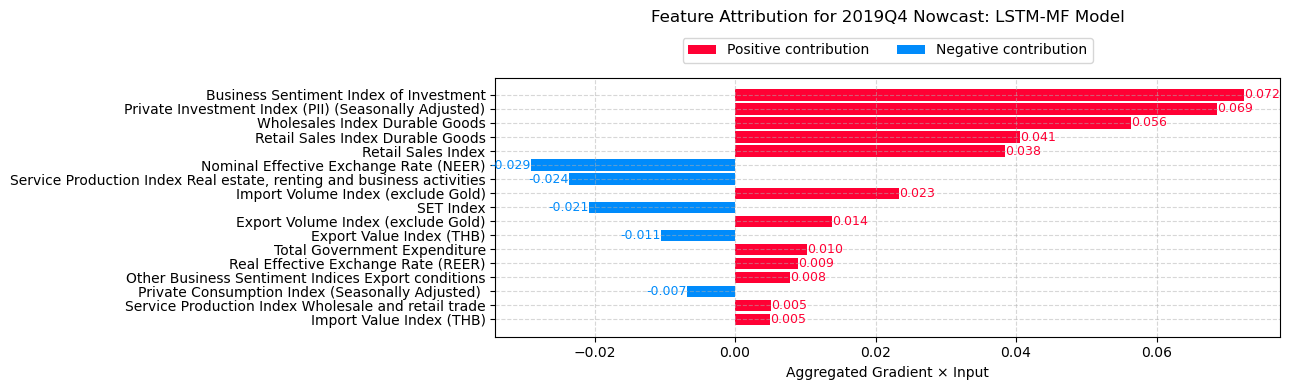

In [111]:
# === Plot LSTM-MF Gradient x Input summary bar ===
lstmmf_contrib = explain_and_plot_nowcast(
    model=final_rnn_models_mf["LSTM"],
    input_sequence=X_test_mf,
    feature_names=feature_names,
    output_neuron=0,
    plot_title="Feature Attribution for 2019Q4 Nowcast: LSTM-MF Model",
    figsize=(13, 4),
    save_path=None
)

In [112]:
# Print LSTM-MF Contributions df
lstmmf_contrib

Feature  Gradient x Input Value
0              Business Sentiment Index of Investment                0.072497
1   Private Investment Index (PII) (Seasonally Adj...                0.068558
2                      Wholesales Index Durable Goods                0.056318
3                    Retail Sales Index Durable Goods                0.040542
4                                  Retail Sales Index                0.038479
5              Nominal Effective Exchange Rate (NEER)               -0.029045
6   Service Production Index Real estate, renting ...               -0.023668
7                  Import Volume Index (exclude Gold)                0.023294
8                                           SET Index               -0.020822
9                  Export Volume Index (exclude Gold)                0.013813
10                           Export Value Index (THB)               -0.010593
11                       Total Government Expenditure                0.010288
12                Real Effective Exchange Rate (REER)                0.008993
13  Other Business Sentiment Indices Export condit...                0.007795
14   Private Consumption Index (Seasonally Adjusted)                -0.006864
15  Service Production Index Wholesale and retail ...                0.005131
16                           Import Value Index (THB)                0.005040

In [113]:
# Define model scores for calculation of model agnostic interpretability scores
lstmmf_lais_scores = [
    {
        'variable_name': 'Service Production Index Wholesale and retail trade',
        'likert_score': -1
    },
    {
        'variable_name': 'Business Sentiment Index of Investment',
        'likert_score': 0
    },
    {
        'variable_name': 'Other Business Sentiment Indices Export conditions',
        'likert_score': -1
    },
    {
        'variable_name': 'Total Government Expenditure',
        'likert_score': -1
    },
    {
        'variable_name': 'Service Production Index Real estate, renting and business activities',
        'likert_score': -1
    },
    {
        'variable_name': 'Retail Sales Index Durable Goods',
        'likert_score': -1   
    },
    {
        'variable_name': 'Real Effective Exchange Rate (REER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Import Volume Index (exclude Gold)',
        'likert_score': -1
    },
    {
        'variable_name': 'SET Index',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Investment Index (PII) (Seasonally Adjusted)',
        'likert_score': 0
    },
    {
        'variable_name': 'Wholesales Index Durable Goods',
        'likert_score': 0
    },
    {
        'variable_name': 'Retail Sales Index',
        'likert_score': -1
    },
    {
        'variable_name': 'Export Volume Index (exclude Gold)',
        'likert_score': -1
    },
    {
        'variable_name': 'Nominal Effective Exchange Rate (NEER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Consumption Index (Seasonally Adjusted)',
        'likert_score': 1
    },
    {
        'variable_name': 'Export Value Index (THB)',
        'likert_score': 1
    },
    {
        'variable_name': 'Import Value Index (THB)',
        'likert_score': -1
    },
]

# Get LAIS score
lstmmf_lais = calculate_relative_lais(lstmmf_lais_scores)
print(f"Interpretability (Relative LAIS) score for LSTM-MF nowcast for 2019Q4: {lstmmf_lais}")


Interpretability (Relative LAIS) score for LSTM-MF nowcast for 2019Q4: -0.636


#### RNN-SF (Single Frequency)

##### Accuracy

In [114]:
# --- Define Moving Window Strategy for RNN (Same Frequency)

def create_patches_single_frequency(X, y, m):
    """
    Generate sequential input-output samples for time series modeling using a moving window approach,
    assuming the input features and targets have the same temporal frequency (e.g., quarterly).

    The function splits the data into training and validation sets by using the last available 
    input-output pair as the validation sample, and the preceding pairs for training.

    Parameters
    ----------
    X : np.ndarray, shape (n_periods, n_features)
        Time-aligned feature matrix, where n_periods is the total number of time steps
        and n_features is the number of features.

    y : np.ndarray, shape (n_periods,)
        Target vector aligned with X in time, containing the values to predict.

    m : int
        Size of the input window (number of past periods to include in each input sample).

    Returns
    -------
    X_train : np.ndarray, shape (n_samples - 1, m, n_features)
        Training input sequences composed of sliding windows of length m.

    y_train : np.ndarray, shape (n_samples - 1,)
        Training target values corresponding to each input sequence in X_train.

    X_val : np.ndarray, shape (1, m, n_features)
        Validation input sequence corresponding to the last available window.

    y_val : np.ndarray, shape (1,)
        Validation target value for the last available window.

    Raises
    ------
    ValueError
        If the available data is insufficient to form at least one training sample and one validation sample.
    """
    X_seq, y_seq = [], []

    for i in range(len(y) - m):
        X_seq.append(X[i:i + m])
        y_seq.append(y[i + m])

    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)

    if len(X_seq) < 2:
        raise ValueError("Not enough data to create at least 1 training and 1 validation sample.")

    X_train = X_seq[:-1]
    y_train = y_seq[:-1]
    X_val = X_seq[-1:]
    y_val = y_seq[-1:]

    return X_train, y_train, X_val, y_val

In [115]:
# Define m
m = 1 # quarter

# Get train and validation patches
X_train_patch_sf, y_train_patch_sf, X_val_patch_sf, y_val_patch_sf = create_patches_single_frequency(
    Xq_train_minmax, y_train_full_minmax, m)

# Print patches for verification purpose
print(f"Train X shape: {X_train_patch_sf.shape}, Train y shape: {y_train_patch_sf.shape}")
print(f"Val X shape: {X_val_patch_sf.shape}, Val y shape: {y_val_patch_sf.shape}")

Train X shape: (33, 1, 17), Train y shape: (33,)
Val X shape: (1, 1, 17), Val y shape: (1,)


In [116]:
# Reshape X_test (samples, timesteps, features)
X_test_sf = Xq_test_minmax.reshape(1, Xq_test_minmax.shape[0], Xq_test_minmax.shape[1])

In [117]:
# --- Run RNN Experiments for Single Frequency Nowcasting ---

best_hyperparams_sf = run_rnn_hyperparameter_optimization(
    model_types=['ERNN', 'GRU', 'LSTM'],
    learning_algorithms=['Adam', 'Adagrad'],
    pbounds=pbounds,
    X_train=X_train_patch_sf,
    y_train=y_train_patch_sf,
    X_val=X_val_patch_sf,
    y_val=y_val_patch_sf,
    seed=42,
    forecast_horizon=1,
    int_columns=['batch_size', 'cell_dim', 'epochs', 'num_layers'],
    optimize_function=optimize_rnn  
)


Optimizing ERNN with Adam...


2025-09-09 11:23:01.837825: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-09 11:23:01.838016: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Optimizing ERNN with Adagrad...


2025-09-09 11:23:11.990004: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-09 11:23:11.990354: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Best optimizer for ERNN: Adam with validation loss = -0.0058

Optimizing GRU with Adam...


2025-09-09 11:23:22.715374: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-09 11:23:22.715755: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Optimizing GRU with Adagrad...


2025-09-09 11:23:32.883714: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-09 11:23:32.883905: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Best optimizer for GRU: Adam with validation loss = -0.0012

Optimizing LSTM with Adam...


2025-09-09 11:23:48.600700: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-09 11:23:48.600873: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Optimizing LSTM with Adagrad...


2025-09-09 11:23:58.856191: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-09-09 11:23:58.856387: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Best optimizer for LSTM: Adam with validation loss = -0.0035


In [118]:
# Build a list of dictionaries, each representing one model's best hyperparameters and results
data = []
for model_type, info in best_hyperparams_sf.items():
    # Copy the parameters dictionary to avoid modifying the original
    params = info['best_params'].copy()
    # Remove 'model_type' key if present to avoid redundancy in the table
    params.pop('model_type', None)
    
    # Create a row dictionary with model type, target loss, and all hyperparameters
    row = {
        'Model Type': model_type,
        'Target Loss': info['best_target'],  
        **params                      
    }
    data.append(row)

# Convert the list of rows into a DataFrame
best_hyperparam_df = pd.DataFrame(data)

# Ensure all column names are strings (important for string operations)
best_hyperparam_df.columns = best_hyperparam_df.columns.astype(str)

# Format column names: replace underscores with spaces and capitalize words for readability
best_hyperparam_df.columns = best_hyperparam_df.columns.str.replace('_', ' ').str.title()

# Convert DataFrame to an HTML table with Bootstrap styling for better visuals
table_2 = best_hyperparam_df.to_html(classes='table table-striped', escape=False, index=False)

# Display the HTML table inline (works in Jupyter notebooks)
display(HTML(table_2))

In [119]:
# --- Retrain the best RNN models and generate nowcasts ---

final_rnn_models_sf, nowcasts_scaled_sf, X_full_train_patch_sf = retrain_rnn_models_and_nowcast(
    model_types=model_types,
    best_hyperparams=best_hyperparams_sf,
    X_train=X_train_patch_sf,
    y_train=y_train_patch_sf,
    X_val=X_val_patch_sf,
    y_val=y_val_patch_sf,
    X_test=X_test_sf,
    retrain_function=retrain_model,
    forecast_function=generate_nowcast
)


Retraining ERNN on full dataset...

Retraining GRU on full dataset...

Retraining LSTM on full dataset...


In [120]:
# Initialize dictionary to store nowcast results for each RNN model
nowcast_rnn_sf = {}

# Loop through each model type to invert scaling and save the nowcast
for model_type in model_types:
    # Extract the scalar scaled nowcast prediction for the current model
    nowcast_scaled_scalar = nowcasts_scaled_sf[model_type]  # single scalar value
    
    # Reshape the scalar to a 2D array of shape (1,1), required by the scaler's inverse_transform method
    nowcast_scaled = np.array([[nowcast_scaled_scalar]])
    
    # Apply inverse MinMax scaling to convert prediction back to original GDP units
    nowcast_value = scaler_y.inverse_transform(nowcast_scaled).flatten()[0]
    
    # Create a one-row DataFrame to store the nowcast value
    # Use the last observed quarter as the index for clarity
    nowcast_rnn_sf[model_type] = pd.DataFrame(
        {'nowcast': [nowcast_value]}, 
        index=[last_quarter]          
    )
    
    # Print the nowcast value with the corresponding model type and quarter
    print(f"{model_type} nowcast for {last_quarter}: {nowcast_value:.4f}")

ERNN nowcast for 2019Q4: 10.6951
GRU nowcast for 2019Q4: -4.3806
LSTM nowcast for 2019Q4: 6.5549


In [121]:
# --- Generate fitted values for each RNN-SF model ---

fitted_values_rnn_sf = generate_fitted_values_rnn(
    final_models=final_rnn_models_sf,
    X_full_train=X_full_train_patch_sf,
    scaler_y=scaler_y,
    df_gdp=df_gdp,
    model_types=model_types
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


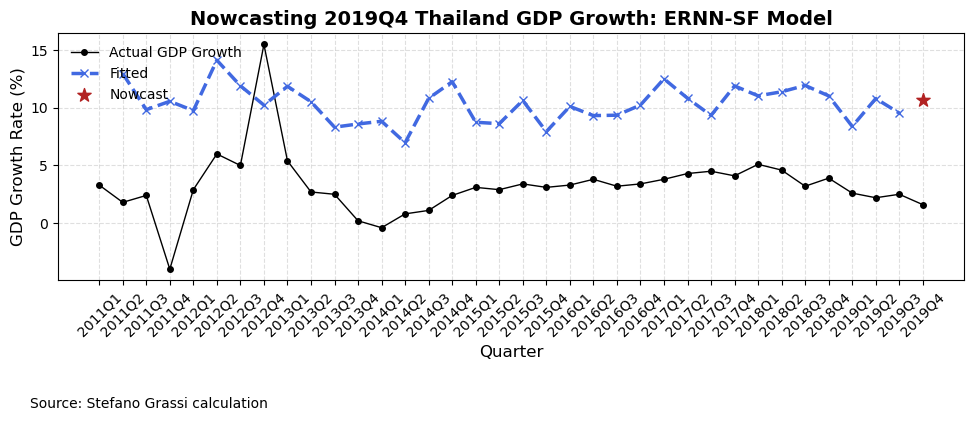

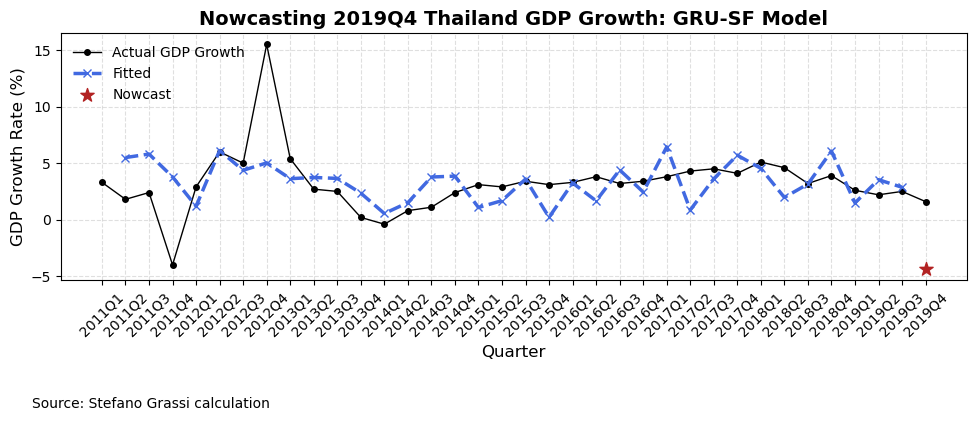

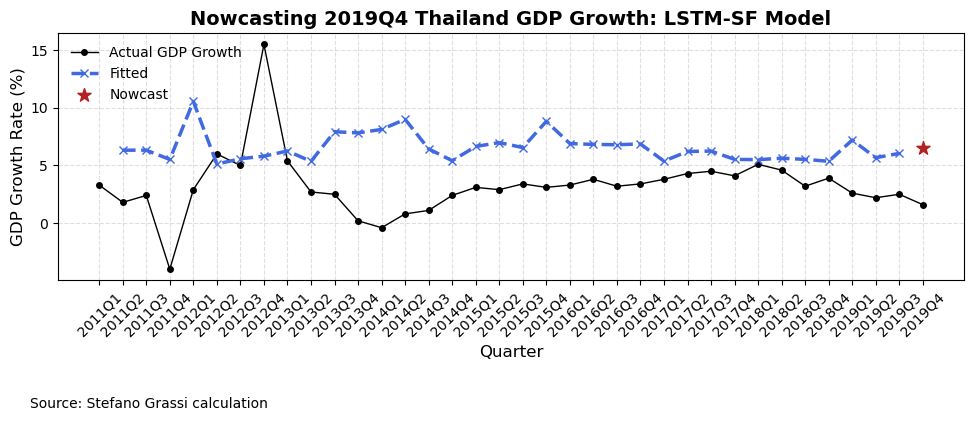

In [122]:
# --- Plot Nowcasts for each RNN-SF Model

for model_type in model_types:
    # Get fitted values DataFrame and convert PeriodIndex to string for x-axis labels
    fitted_df = fitted_values_rnn_sf[model_type]
    fitted_dates = fitted_df.index.astype(str) 
    fitted_values = fitted_df['fitted'].values

    # Extract the single nowcast value and its date string (e.g. '2019Q4')
    nowcast_value = nowcast_rnn_sf[model_type]['nowcast'].values[0]
    nowcast_date = str(nowcast_rnn_sf[model_type].index[0])  

    # Call your plotting function to visualize actual, fitted, and nowcast values
    plot_nowcast(
        actual_dates=df_gdp['quarter'],      
        actual_values=df_gdp['gdp_growth'],   
        fitted_dates=fitted_dates,             
        fitted_values=fitted_values,           
        nowcast_date=nowcast_date,             
        nowcast_value=nowcast_value,            
        title=f"Nowcasting {nowcast_date} Thailand GDP Growth: {model_type}-SF Model",
        fitted_label="Fitted",
        source="Source: Stefano Grassi calculation"
    )

##### Interpretability

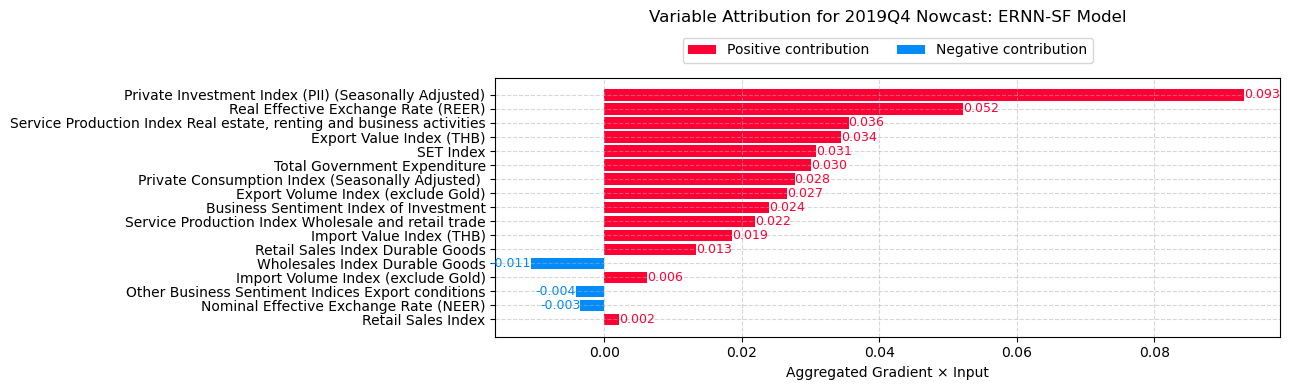

In [123]:
# === Plot ERNN-SF Gradient x Input summary bar ===
ernnsf_contrib = explain_and_plot_nowcast(
    model=final_rnn_models_sf["ERNN"],
    input_sequence=X_test_sf,
    feature_names=feature_names,
    output_neuron=0,
    plot_title="Variable Attribution for 2019Q4 Nowcast: ERNN-SF Model",
    figsize=(13, 4),
    save_path=None
)

In [124]:
# Print ERNN-SF Contributions df
ernnsf_contrib

Feature  Gradient x Input Value
0   Private Investment Index (PII) (Seasonally Adj...                0.093099
1                 Real Effective Exchange Rate (REER)                0.052171
2   Service Production Index Real estate, renting ...                0.035521
3                            Export Value Index (THB)                0.034483
4                                           SET Index                0.030779
5                        Total Government Expenditure                0.030025
6    Private Consumption Index (Seasonally Adjusted)                 0.027670
7                  Export Volume Index (exclude Gold)                0.026614
8              Business Sentiment Index of Investment                0.023922
9   Service Production Index Wholesale and retail ...                0.021926
10                           Import Value Index (THB)                0.018610
11                   Retail Sales Index Durable Goods                0.013282
12                     Wholesales Index Durable Goods               -0.010672
13                 Import Volume Index (exclude Gold)                0.006214
14  Other Business Sentiment Indices Export condit...               -0.004129
15             Nominal Effective Exchange Rate (NEER)               -0.003481
16                                 Retail Sales Index                0.002183

In [125]:
# Define model scores for calculation of model agnostic interpretability scores
ernnsf_lais_scores = [
    {
        'variable_name': 'Service Production Index Wholesale and retail trade',
        'likert_score': -1
    },
    {
        'variable_name': 'Business Sentiment Index of Investment',
        'likert_score': 0
    },
    {
        'variable_name': 'Other Business Sentiment Indices Export conditions',
        'likert_score': 1
    },
    {
        'variable_name': 'Total Government Expenditure',
        'likert_score': -1
    },
    {
        'variable_name': 'Service Production Index Real estate, renting and business activities',
        'likert_score': 1
    },
    {
        'variable_name': 'Retail Sales Index Durable Goods',
        'likert_score': -1   
    },
    {
        'variable_name': 'Real Effective Exchange Rate (REER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Import Volume Index (exclude Gold)',
        'likert_score': -1
    },
    {
        'variable_name': 'SET Index',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Investment Index (PII) (Seasonally Adjusted)',
        'likert_score': 0
    },
    {
        'variable_name': 'Wholesales Index Durable Goods',
        'likert_score': 0
    },
    {
        'variable_name': 'Retail Sales Index',
        'likert_score': -1
    },
    {
        'variable_name': 'Export Volume Index (exclude Gold)',
        'likert_score': -1
    },
    {
        'variable_name': 'Nominal Effective Exchange Rate (NEER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Consumption Index (Seasonally Adjusted)',
        'likert_score': -1
    },
    {
        'variable_name': 'Export Value Index (THB)',
        'likert_score': -1
    },
    {
        'variable_name': 'Import Value Index (THB)',
        'likert_score': -1
    },
]

# Get LAIS score
ernnsf_lais = calculate_relative_lais(ernnsf_lais_scores)
print(f"Interpretability (Relative LAIS) score for ERNN-SF nowcast for 2019Q4: {ernnsf_lais}")


Interpretability (Relative LAIS) score for ERNN-SF nowcast for 2019Q4: -0.636


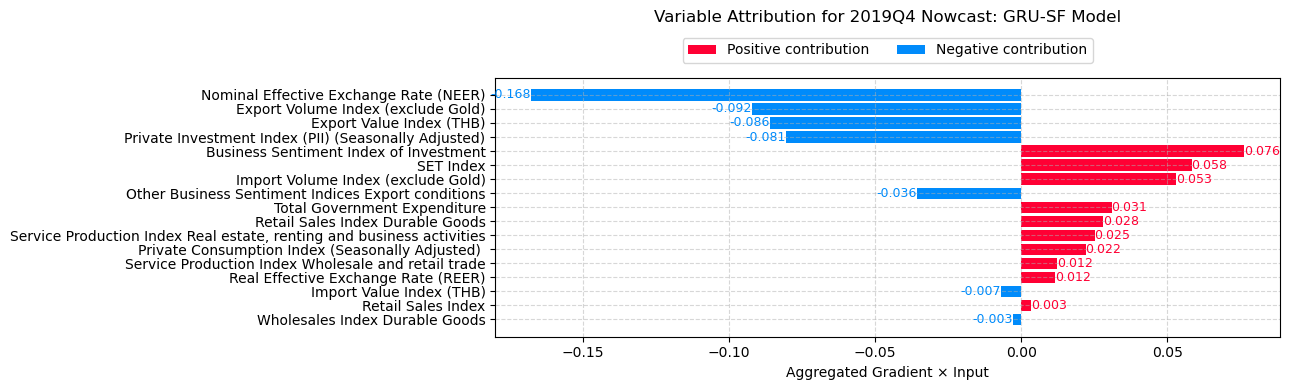

In [126]:
# === Plot GRU-SF Gradient x Input summary bar ===
grusf_contrib = explain_and_plot_nowcast(
    model=final_rnn_models_sf["GRU"],
    input_sequence=X_test_sf,
    feature_names=feature_names,
    output_neuron=0,
    plot_title="Variable Attribution for 2019Q4 Nowcast: GRU-SF Model",
    figsize=(13, 4),
    save_path=None
)

In [127]:
# Print GRU-SF Contributions df
grusf_contrib

Feature  Gradient x Input Value
0              Nominal Effective Exchange Rate (NEER)               -0.167802
1                  Export Volume Index (exclude Gold)               -0.092119
2                            Export Value Index (THB)               -0.086065
3   Private Investment Index (PII) (Seasonally Adj...               -0.080546
4              Business Sentiment Index of Investment                0.076375
5                                           SET Index                0.058293
6                  Import Volume Index (exclude Gold)                0.053026
7   Other Business Sentiment Indices Export condit...               -0.035739
8                        Total Government Expenditure                0.030907
9                    Retail Sales Index Durable Goods                0.027950
10  Service Production Index Real estate, renting ...                0.025124
11   Private Consumption Index (Seasonally Adjusted)                 0.022009
12  Service Production Index Wholesale and retail ...                0.012382
13                Real Effective Exchange Rate (REER)                0.011728
14                           Import Value Index (THB)               -0.007040
15                                 Retail Sales Index                0.003283
16                     Wholesales Index Durable Goods               -0.002712

In [128]:
# Define model scores for calculation of model agnostic interpretability scores
grusf_lais_scores = [
    {
        'variable_name': 'Service Production Index Wholesale and retail trade',
        'likert_score': -1
    },
    {
        'variable_name': 'Business Sentiment Index of Investment',
        'likert_score': 0
    },
    {
        'variable_name': 'Other Business Sentiment Indices Export conditions',
        'likert_score': 1
    },
    {
        'variable_name': 'Total Government Expenditure',
        'likert_score': -1
    },
    {
        'variable_name': 'Service Production Index Real estate, renting and business activities',
        'likert_score': 1
    },
    {
        'variable_name': 'Retail Sales Index Durable Goods',
        'likert_score': -1   
    },
    {
        'variable_name': 'Real Effective Exchange Rate (REER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Import Volume Index (exclude Gold)',
        'likert_score': -1
    },
    {
        'variable_name': 'SET Index',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Investment Index (PII) (Seasonally Adjusted)',
        'likert_score': 0
    },
    {
        'variable_name': 'Wholesales Index Durable Goods',
        'likert_score': 0
    },
    {
        'variable_name': 'Retail Sales Index',
        'likert_score': -1
    },
    {
        'variable_name': 'Export Volume Index (exclude Gold)',
        'likert_score': 1
    },
    {
        'variable_name': 'Nominal Effective Exchange Rate (NEER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Consumption Index (Seasonally Adjusted)',
        'likert_score': -1
    },
    {
        'variable_name': 'Export Value Index (THB)',
        'likert_score': 1
    },
    {
        'variable_name': 'Import Value Index (THB)',
        'likert_score': 1
    },
]

# Get LAIS score
grusf_lais = calculate_relative_lais(grusf_lais_scores)
print(f"Interpretability (Relative LAIS) score for GRU-SF nowcast for 2019Q4: {grusf_lais}")


Interpretability (Relative LAIS) score for GRU-SF nowcast for 2019Q4: -0.091


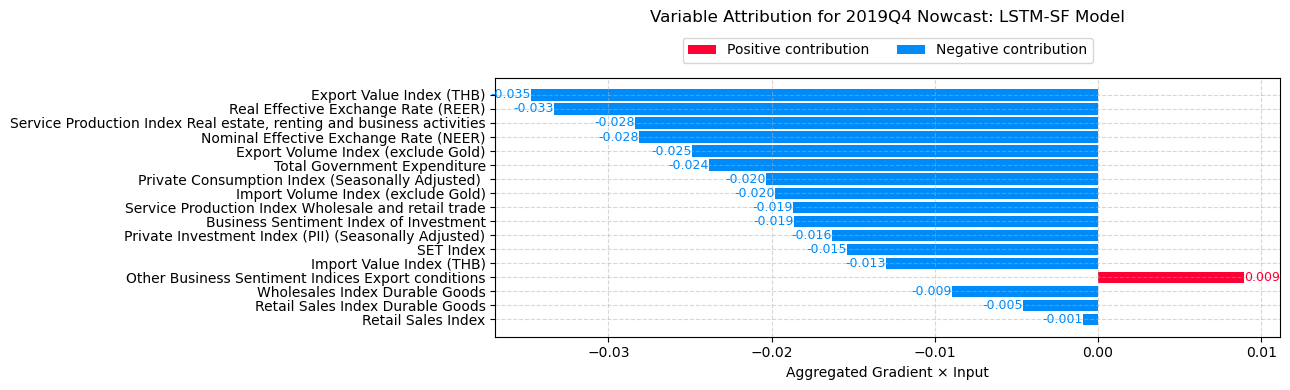

In [129]:
# === Plot LSTM-SF Gradient x Input summary bar ===
lstmsf_contrib = explain_and_plot_nowcast(
    model=final_rnn_models_sf["LSTM"],
    input_sequence=X_test_sf,
    feature_names=feature_names,
    output_neuron=0,
    plot_title="Variable Attribution for 2019Q4 Nowcast: LSTM-SF Model",
    figsize=(13, 4),
    save_path=None
)

In [130]:
# Print LSTM-SF Contributions df
lstmsf_contrib

Feature  Gradient x Input Value
0                            Export Value Index (THB)               -0.034740
1                 Real Effective Exchange Rate (REER)               -0.033350
2   Service Production Index Real estate, renting ...               -0.028368
3              Nominal Effective Exchange Rate (NEER)               -0.028108
4                  Export Volume Index (exclude Gold)               -0.024893
5                        Total Government Expenditure               -0.023830
6    Private Consumption Index (Seasonally Adjusted)                -0.020346
7                  Import Volume Index (exclude Gold)               -0.019772
8   Service Production Index Wholesale and retail ...               -0.018682
9              Business Sentiment Index of Investment               -0.018655
10  Private Investment Index (PII) (Seasonally Adj...               -0.016322
11                                          SET Index               -0.015365
12                           Import Value Index (THB)               -0.012970
13  Other Business Sentiment Indices Export condit...                0.008966
14                     Wholesales Index Durable Goods               -0.008937
15                   Retail Sales Index Durable Goods               -0.004597
16                                 Retail Sales Index               -0.000930

In [131]:
# Define model scores for calculation of model agnostic interpretability scores
lstmsf_interp_scores = [
    {
        'variable_name': 'Service Production Index Wholesale and retail trade',
        'likert_score': 1
    },
    {
        'variable_name': 'Business Sentiment Index of Investment',
        'likert_score': 0
    },
    {
        'variable_name': 'Other Business Sentiment Indices Export conditions',
        'likert_score': -1
    },
    {
        'variable_name': 'Total Government Expenditure',
        'likert_score': 1
    },
    {
        'variable_name': 'Service Production Index Real estate, renting and business activities',
        'likert_score': -1
    },
    {
        'variable_name': 'Retail Sales Index Durable Goods',
        'likert_score': 1   
    },
    {
        'variable_name': 'Real Effective Exchange Rate (REER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Import Volume Index (exclude Gold)',
        'likert_score': 1
    },
    {
        'variable_name': 'SET Index',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Investment Index (PII) (Seasonally Adjusted)',
        'likert_score': 0
    },
    {
        'variable_name': 'Wholesales Index Durable Goods',
        'likert_score': 0
    },
    {
        'variable_name': 'Retail Sales Index',
        'likert_score': 1
    },
    {
        'variable_name': 'Export Volume Index (exclude Gold)',
        'likert_score': 1
    },
    {
        'variable_name': 'Nominal Effective Exchange Rate (NEER)',
        'likert_score': 0
    },
    {
        'variable_name': 'Private Consumption Index (Seasonally Adjusted)',
        'likert_score': 1
    },
    {
        'variable_name': 'Export Value Index (THB)',
        'likert_score': 1
    },
    {
        'variable_name': 'Import Value Index (THB)',
        'likert_score': 1
    },
]
# Get LAIS score
lstmsf_lais = calculate_relative_lais(lstmsf_interp_scores)
print(f"Interpretability (Relative LAIS) score for LSTM-SF nowcast for 2019Q4: {lstmsf_lais}")

Interpretability (Relative LAIS) score for LSTM-SF nowcast for 2019Q4: 0.636


## Export Results

In [132]:
# Accuracy results

# Get fitted values dfs from models

actual_df = y_train_full[['quarter', 'gdp_growth']].copy()

ar_fitted_df = pd.DataFrame({
    'quarter': y_train_full['quarter'].iloc[-len(ar1_model_fitted_values):].values,
    'AR(1)': ar1_model_fitted_values
})

dfm_fitted_df = pd.DataFrame({
    'quarter': y_train_full['quarter'].iloc[-len(dfm_model_fitted_values):].values,
    'DFM': dfm_model_fitted_values
 })

midas_fitted_df = pd.DataFrame({
    'quarter': midas_model_fitted_dates,
    'Factor-MIDAS': midas_model_fitted_values
 })

ml_fitted_df = pd.DataFrame({
    'quarter': y_train_full['quarter'],
    'SVR': svr_fitted_values,
    'kNN': knn_fitted_values,
    'Ridge': ridge_fitted_values,
    'LASSO': lasso_fitted_values,
    'RF': rf_fitted_values,
    'XGBoost': xgb_fitted_values,
    'LightGBM': lgbm_fitted_values,
})

rnn_fitted_df = pd.DataFrame({
    'ERNN-MF': fitted_values_rnn_mf['ERNN'].squeeze(),
    'GRU-MF': fitted_values_rnn_mf['GRU'].squeeze(),
    'LSTM-MF': fitted_values_rnn_mf['LSTM'].squeeze(),
    'ERNN-SF': fitted_values_rnn_sf['ERNN'].squeeze(),
    'GRU-SF': fitted_values_rnn_sf['GRU'].squeeze(),
    'LSTM-SF': fitted_values_rnn_sf['LSTM'].squeeze()
}).reset_index()
rnn_fitted_df['quarter'] = rnn_fitted_df['quarter'].astype(str)

# Now merge all on 'quarter'
final_fitted_df = actual_df.merge(ar_fitted_df, on='quarter', how='outer') \
                     .merge(dfm_fitted_df, on='quarter', how='outer') \
                     .merge(midas_fitted_df, on='quarter', how='outer') \
                     .merge(ml_fitted_df, on='quarter', how='outer') \
                     .merge(rnn_fitted_df, on='quarter', how='outer')

# Sort by quarter
final_fitted_df = final_fitted_df.sort_values('quarter').reset_index(drop=True)

In [133]:
# Get Nowcasts dataframe 
nowcasts = {
    'nowcast_date': '2019-12-17',
    'quarter': df_gdp['quarter'].iloc[-1], 
    'Actual': df_gdp['gdp_growth'].iloc[-1],
    'AR(1)': nowcast_ar1.iloc[-1].item(),
    'DFM': nowcast_dfm.iloc[-1].item(),
    'Factor-MIDAS': nowcast_midas.iloc[-1].item(),
    'SVR': nowcast_svr.iloc[-1].item(),
    'kNN': nowcast_knn.iloc[-1].item(),
    'Ridge': nowcast_ridge.iloc[-1].item(),
    'LASSO': nowcast_lasso.iloc[-1].item(),
    'RF': nowcast_rf.iloc[-1].item(),
    'XGBoost': nowcast_xgb.iloc[-1].item(),
    'LightGBM': nowcast_lgbm.iloc[-1].item(),
    'ERNN-MF': nowcast_rnn_mf['ERNN'].iloc[-1, 0].item(),
    'GRU-MF': nowcast_rnn_mf['GRU'].iloc[-1, 0].item(),
    'LSTM-MF': nowcast_rnn_mf['LSTM'].iloc[-1, 0].item(),
    'ERNN-SF': nowcast_rnn_sf['ERNN'].iloc[-1, 0].item(),
    'GRU-SF': nowcast_rnn_sf['GRU'].iloc[-1, 0].item(),
    'LSTM-SF': nowcast_rnn_sf['LSTM'].iloc[-1, 0].item()
}

# Convert to a DataFrame
nowcast_df = pd.DataFrame([nowcasts])

In [134]:
# Display nowcast_df
nowcast_df 

nowcast_date quarter  Actual     AR(1)       DFM  Factor-MIDAS       SVR  \
0   2019-12-17  2019Q4     1.6  2.980137  1.594503       1.79446  2.738192   

        kNN     Ridge     LASSO  Random Forest   XGBoost  LightGBM   ERNN-MF  \
0  3.228571  3.975085  2.732954       2.732954  3.252808  3.500731  2.550437   

     GRU-MF   LSTM-MF    ERNN-SF    GRU-SF  LSTM-SF  
0  7.793903  2.514167  10.695107 -4.380569  6.55491

In [135]:
# Interpretability results
lais_scores = {
    'nowcast_date': '2019-12-17',
    'SVR': svr_lais,
    'kNN': knn_lais,
    'Ridge': ridge_lais,
    'LASSO': lasso_lais,
    'RF': rf_lais,
    'XGBoost': xgboost_lais,
    'LightGBM': lightgbm_lais,
    'ERNN-MF': ernnmf_lais,
    'GRU-MF': grumf_lais,
    'LSTM-MF': lstmmf_lais,
    'ERNN-SF': ernnsf_lais,
    'GRU-SF': grusf_lais,
    'LSTM-SF':lstmsf_lais 
}

# Convert to a DataFrame
interpretability_df = pd.DataFrame([lais_scores])

In [136]:
# Display interpretability_df
interpretability_df

nowcast_date  SVR  kNN  Ridge  LASSO  Random Forest  XGBoost  LightGBM  \
0   2019-12-17  0.0  0.2 -0.636    0.0          0.091   -0.667      -1.0   

   ERNN-MF  GRU-MF  LSTM-MF  ERNN-SF  GRU-SF  LSTM-SF  
0   -0.818  -0.818   -0.636   -0.636  -0.091    0.636

In [137]:
# Export df to CSV
# Uncomment if needed
#final_fitted_df.to_csv('fitted-nowcast-thai-gdp-final-dec.csv', index=False)
#nowcast_df.to_csv('results-nowcast-thai-gdp-final-dec.csv', index=False)
#interpretability_df.to_csv('interpretability-results-nowcast-thai-gdp-final-dec.csv', index=False)

## Appendix 

### A. Narrative Alignment of Model Variables (BOT, 17-12-2019, 2019Q4)

This appendix summarizes how each variable in the nowcasting model aligns with the tone of the Bank of Thailand’s December 2019 monetary policy report. Variables are rated based on whether they are explicitly or implicitly mentioned and whether the tone is positive, negative, or neutral in terms of GDP impact.

| Variable | Narrative Summary | Tone | Score |
| :--- | :--- | :--- | :--- |
| **Service Production Index – Wholesale and Retail Trade** | Retail trade is a component of private consumption, which is described as decelerating due to negative factors. | Negative | -1 |
| **Business Sentiment Index of Investment** | While overall sentiment is weak, the report notes positive support from public-private partnerships and business relocations. | Neutral | 0 |
| **Other Business Sentiment Indices – Export Conditions** | Exports continued to contract due to weak global trade and competition; export-linked jobs also declined. | Negative | -1 |
| **Total Government Expenditure** | Public investment slowed due to budget delay and SOE underperformance; strong negative tone. | Negative | -1 |
| **Service Production Index – Real Estate, Renting and Business Activities** | Real estate activities supported by government stimulus (e.g., Taste-Shop-Spend, real estate measures); indirect but positive tone. | Positive | +1 |
| **Retail Sales Index – Durable Goods** | Durable goods demand constrained by household debt and falling income. | Negative | -1 |
| **Real Effective Exchange Rate (REER)** | REER appreciated, a known headwind for exports, though the report does not explicitly assign a tone. | Neutral | 0 |
| **Import Volume Index (exclude Gold)** | Imports expected to decline due to reduced demand for raw/intermediate goods tied to weak export manufacturing. | Negative | -1 |
| **SET Index** | Not discussed. | Neutral | 0 |
| **Private Investment Index (PII) (SA)** | Private investment growth was largely unchanged due to positive support from infrastructure projects and production relocations. | Neutral | 0 |
| **Wholesales Index – Durable Goods** | Durable goods demand likely subdued, but not directly mentioned. | Neutral | 0 |
| **Retail Sales Index** | Although non-durable sales were supported by stimulus, the overall context of private consumption is negative. | Negative | -1 |
| **Export Volume Index (exclude Gold)** | Merchandise exports continued to contract, driven by weak demand and competition. | Negative | -1 |
| **Nominal Effective Exchange Rate (NEER)** | Appreciated slightly (0.7%) in line with regional peers; tone neutral. | Neutral | 0 |
| **Private Consumption Index (SA)** | Private consumption decelerated due to weak income and employment, elevated household debt, and insufficient policy support. | Negative | -1 |
| **Export Value Index (THB)** | Exports contracted due to trade slowdown and regional competition. | Negative | -1 |
| **Import Value Index (THB)** | Imports projected to decline due to reduced demand for intermediate goods linked to export manufacturing. | Negative | -1 |

#### Important Notes on the Narrative Score

* This score reflects the BOT's view, not model behavior.
* "Less contraction" still means negative in the BOT's GDP framing.
* Only clearly expansionary sectors such as construction and imports, get a positive score.
* Mixed or ambiguous mentions tied to slowing, high base effects, or indirect effects default to neutral, depending on context.

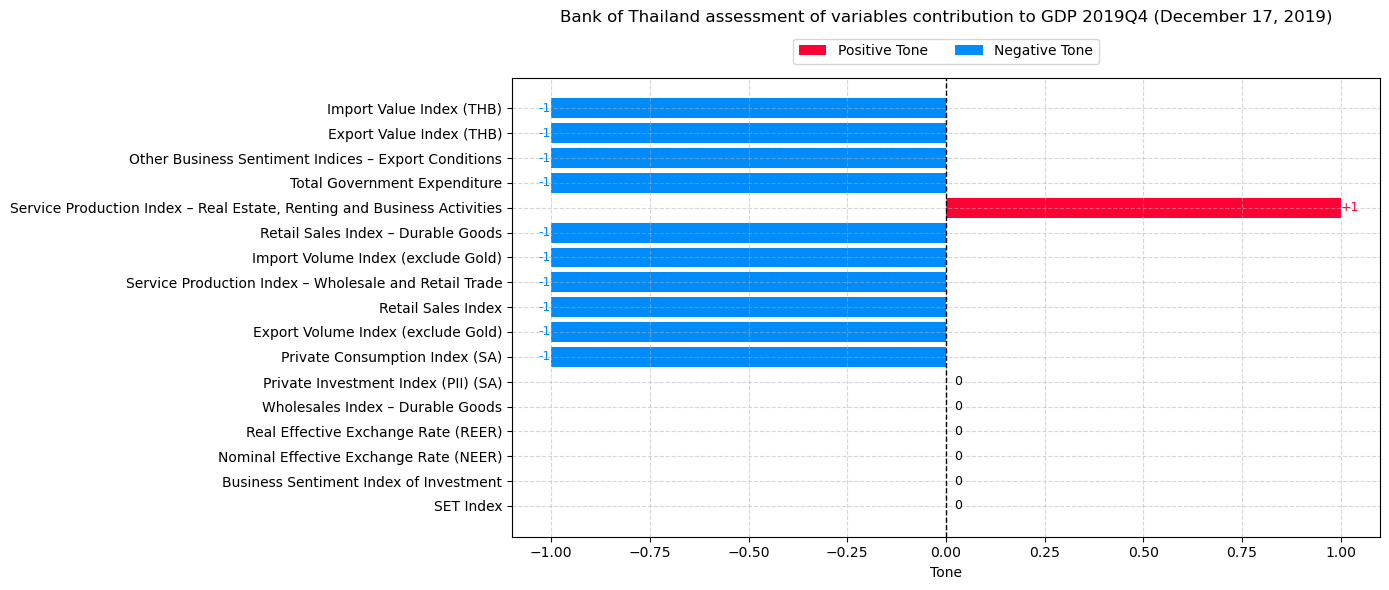

In [138]:
# Get the BOT tone data
data = {
    'Variable': [
        'Service Production Index – Wholesale and Retail Trade',
        'Business Sentiment Index of Investment',
        'Other Business Sentiment Indices – Export Conditions',
        'Total Government Expenditure',
        'Service Production Index – Real Estate, Renting and Business Activities',
        'Retail Sales Index – Durable Goods',
        'Real Effective Exchange Rate (REER)',
        'Import Volume Index (exclude Gold)',
        'SET Index',
        'Private Investment Index (PII) (SA)',
        'Wholesales Index – Durable Goods',
        'Retail Sales Index',
        'Export Volume Index (exclude Gold)',
        'Nominal Effective Exchange Rate (NEER)',
        'Private Consumption Index (SA)',
        'Export Value Index (THB)',
        'Import Value Index (THB)'
    ],
    'Tone': [
        -1, 0, -1, -1, 1, -1, 0, -1, 0, 0, 0, -1, -1, 0, -1, -1, -1
    ]
}

# Get DataFrame
df_narrative = pd.DataFrame(data)

# Define function to plot the BOT narrative attribution
def plot_narrative_attributions(df, title, figsize=(14, 6), save_path=None):
    """
    Plots a horizontal bar chart of positive and negative tone.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with 'Variable Name' and 'tone' columns.
    title : str
        Title of the plot.
    figsize : tuple, optional
        Size of the matplotlib figure.
    save_path : str or None, optional
        File path to save the figure.
    """
    # Separate positive and negative scores for plotting
    df['positive'] = df['Tone'].apply(lambda x: x if x > 0 else 0)
    df['negative'] = df['Tone'].apply(lambda x: x if x < 0 else 0)

    # Sort the data by absolute score for better visualization
    df['total_abs'] = df['Tone'].abs()
    df = df.sort_values(by='total_abs', ascending=True)

    fig, ax = plt.subplots(figsize=figsize)

    # Plot positive contributions
    ax.barh(df['Variable'], df['positive'], color='#FF0034', label='Positive Tone')

    # Plot negative contributions
    ax.barh(df['Variable'], df['negative'], color='#008BFB', label='Negative Tone')

    ax.set_xlabel('Tone')
    ax.set_title(title, pad=40)
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.1),
        ncol=2,
        frameon=True
    )
    ax.grid(axis='both', linestyle='--', alpha=0.5)
    
    # Add a vertical middle line at x=0
    ax.axvline(0, color='black', linewidth=1.0, linestyle='--')

    # Add text labels to the bars, including zeros
    for i, (pos, neg, score) in enumerate(zip(df['positive'], df['negative'], df['Tone'])):
        if score > 0:
            ax.text(pos, i, f"+{int(pos)}", va='center', ha='left', color='#FF0034', fontsize=9)
        elif score < 0:
            ax.text(neg, i, f"{int(neg)}", va='center', ha='right', color='#008BFB', fontsize=9)
        else:
            # Place the text for zero scores at the center line
            ax.text(0.03, i, "0", va='center', ha='center', color='black', fontsize=9)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Plot saved to {save_path}")

# Plot the BOT narrative attributions
plot_narrative_attributions(df_narrative,
                            title="Bank of Thailand assessment of variables contribution to GDP 2019Q4 (December 17, 2019)",
                            save_path= None)